In [1]:
## Создаем класс датасета для обучения модели детекции номеров 


import torch 
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import numpy as np
import albumentations as A
import cv2
from torchvision import transforms

import os
import json

from sklearn.model_selection import train_test_split

class PlatesDataset(Dataset):
    
    def __init__(self, root_path: str, json_path: str, sample_type: str='train', val_size: float=0.2, 
                random_state: int=42, transform: A.Compose=None):
        
        self.root_path = root_path
        self.transfrom = transform
        
        with open(json_path, 'r') as f:
            img_list = json.load(f)
        
        if sample_type == 'train':
            self.img_list, _ = train_test_split(img_list, test_size=val_size, random_state=random_state)
        elif sample_type == 'val':
            _, self.img_list = train_test_split(img_list, test_size=val_size, random_state=random_state)
        
    def __len__(self):
        return len(self.img_list)
    
    
    def __getitem__(self, idx):
        
        try:
            img = cv2.imread(os.path.join(self.root_path, self.img_list[idx]['file']))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        except:
            idx = 0
            img = cv2.imread(os.path.join(self.root_path, self.img_list[idx]['file']))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            print('Cant open image')
        
        objects = self.img_list[idx]['nums']
        
        bboxes = np.array([[min([i[0] for i in b['box']]), min([i[1] for i in b['box']]), 
                  max([i[0] for i in b['box']]), max([i[1] for i in b['box']])] for b in objects])
        
        for bbox in bboxes:
            if (bbox[2] - bbox[0] < 0 ) or (bbox[3] - bbox[1] < 0):
                print(idx)
        
        labels = np.ones(shape=(bboxes.shape[0]), dtype=np.int64)
        
        try:
            if self.transfrom is not None:
                sample = self.transfrom(image=img, bboxes=bboxes, labels=labels)
                img, bboxes = sample['image'], sample['bboxes']
        except:
            print('Cant do augmention')
            
        img = transforms.ToTensor()(img)
        
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        targets = {'boxes': bboxes, 'labels': labels, 'image_id': torch.as_tensor([idx])}
        
        return img, targets
        
        
        
def collate_fn(batch):
    return batch

/home/ndubrovnyi/.conda/envs/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## Опеределяем конфигурацию обучения

Config = {
    # detection train dataset params
    'root_path': '../vkcv2022-contest-02-carplates/data/',
    'json_path': '../vkcv2022-contest-02-carplates/data/train.json',
    'val_size': 0.2,
    
    # detection training params
    'model_name': 'faster_rcnn_v5',
    'device': 'cuda:2',
    'num_epochs': 20,
    'lr': 3e-4,
    'batch_size': 16,
    'num_workers': 8
}

In [3]:
## Добавляем аугментацию для расширения датасета

train_transform = A.Compose([A.HorizontalFlip(p=0.25),
                            A.Rotate(limit=(-20, 20), p=0.25),
                            A.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.2, hue=0.05, p=0.25)],
                            bbox_params={
                                        'format': 'pascal_voc',
                                        'label_fields': ['labels']
                                        })

trainset = PlatesDataset(root_path=Config['root_path'], json_path=Config['json_path'],
                         sample_type='train', val_size=Config['val_size'], transform=train_transform)

valset = PlatesDataset(root_path=Config['root_path'], json_path=Config['json_path'],
                       sample_type='val', val_size=Config['val_size'])

print('Train size:', len(trainset))
print('Val size:', len(valset))

Train size: 20506
Val size: 5127


In [4]:
## Определяем необходимые функции и классы для обучения и валидации модели детекции

from tqdm import tqdm
import pandas as pd

from sklearn.metrics import auc


def get_iou(true_box, pred_box):
    
    ix1 = np.maximum(true_box[0], pred_box[0])
    iy1 = np.maximum(true_box[1], pred_box[1])
    ix2 = np.minimum(true_box[2], pred_box[2])
    iy2 = np.minimum(true_box[3], pred_box[3])
    
    i_height = np.maximum(iy2 - iy1 + 1, np.array(0.))
    i_width = np.maximum(ix2 - ix1 + 1, np.array(0.))
    
    area_of_intersection = i_height * i_width
    
    gt_height = true_box[3] - true_box[1] + 1
    gt_width = true_box[2] - true_box[0] + 1
    
    pd_height = pred_box[3] - pred_box[1] + 1
    pd_width = pred_box[2] - pred_box[0] + 1
    
    area_of_union = gt_height * gt_width + pd_height * pd_width - area_of_intersection
    
    iou = area_of_intersection / area_of_union
    
    return iou


class ModelTrainer():
    
    def __init__(self, model, model_name, train_loader, val_loader, optimizer, device, scheduller=None,
                 conf_thresh=0.5, val_classes=None):
        
        self.model = model
        self.model_name = model_name
        self.device = device
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.scheduller = scheduller
        
        self.conf_thresh = conf_thresh
        self.val_classes = val_classes
        
        
    def fit_epoch(self):
        
        obj_loss = []
        reg_loss = []
        global_loss = []
        
        self.model.train()
        for idx, batch in tqdm(enumerate(self.train_loader)):
            images = [b[0].to(self.device) for b in batch]
            targets = [{k: v.to(self.device) for k, v in b[1].items()} for b in batch]
            
            self.optimizer.zero_grad()
            try:
                losses = self.model(images, targets)
            except:
                print('Error in training step')
                continue
            
            
            loss = sum([v for v in losses.values()])
            loss.backward()
            
            self.optimizer.step()
            if self.scheduller is not None:
                self.scheduller.step()            
            
            global_loss.append(loss.item())
            obj_loss.append(losses['loss_objectness'].item())
            reg_loss.append(losses['loss_rpn_box_reg'].item())
            
            if idx % 20 == 0:
                print('Global Loss:', np.mean(global_loss))
                print('Object Loss:', np.mean(obj_loss))
                print('Reg Loss:', np.mean(reg_loss))
            
        return np.mean(global_loss)
    
    
    def eval_sample(self, pred, target, iou_thresh, result_dict):
        pred_bboxes = pred['boxes'].cpu().numpy()
        scores = pred['scores'].cpu().numpy()
        pred_labels = pred['labels'].cpu().numpy()
        
        true_bboxes = target['boxes'].cpu().numpy()
        true_labels = target['labels'].cpu().numpy()
        image_id = target['image_id'].cpu().numpy()[0]
        
        for i in range(len(pred_bboxes)):
            
            pred_box = pred_bboxes[i]
            pred_label = pred_labels[i]
            
            result_dict['image_id'].append(image_id)
            result_dict['pred_label'].append(pred_label)
            result_dict['score'].append(scores[i])
            
            max_iou = 0
            max_id = -1
            for j in range(len(true_bboxes)):
                
                true_box = true_bboxes[j]
                true_label = true_labels[j]
                
                if true_label != pred_label:
                    continue
                       
                IoU = get_iou(true_box, pred_box)
                if (IoU >= iou_thresh) and (IoU > max_iou):
                    max_iou = IoU
                    max_id = j
            
            if max_id >= 0:
                result_dict['TP'].append(1)
                true_bboxes = np.delete(true_bboxes, max_id, axis=0)
                true_labels = np.delete(true_labels, max_id, axis=0)
                
            else:
                result_dict['TP'].append(0)
                
            
        return result_dict
    
    
    def compute_metrics(self, predictions, targets):
        

        iou_list_results = {str(round(iou, 2)): {class_id: {'precision_list': [], 'recall_list': []} 
                                                 for class_id in self.val_classes} 
                            for iou in np.linspace(0.5, 0.95, 10)}
        result_metrics = {'map_list': [], 'map@50': 0, 'map@50_95': 0, 'precsion': 0, 'recall': 0}
        
        for iou in tqdm(iou_list_results):
            result_dict = {'image_id': [], 'pred_label': [], 'score': [], 'TP': []}
            n_boxes = {label: 0 for label in self.val_classes}
        
            for pred, true in zip(predictions, targets):
                result_dict = self.eval_sample(pred, true, float(iou), result_dict)
                for label in true['labels']:
                    n_boxes[label.item()] += 1
        
            df = pd.DataFrame(result_dict)
            iou_list_results[iou]['ap_list'] = []
            
            if iou == '0.5':
                iou_list_results[iou]['precision_list'] = []
                iou_list_results[iou]['recall_list'] = []
            
            for class_id in self.val_classes:
                df_per_class = df[df['pred_label'] == class_id]
                df_per_class = df_per_class.sort_values(by='score', ascending=False)
                
                
                TP = 0
                preds_count = 0
                for idx, row in df_per_class.iterrows():
                    TP += row['TP']
                    preds_count += 1
                    
                    precision = TP/preds_count
                    recall = TP/n_boxes[class_id]
                    
                    iou_list_results[iou][class_id]['precision_list'].append(precision)
                    iou_list_results[iou][class_id]['recall_list'].append(recall)
                    
                    if (iou == '0.5') and (row['score'] >= self.conf_thresh-0.02) and (row['score'] <= self.conf_thresh+0.02):
                        iou_list_results[iou][class_id]['precision'] = precision
                        iou_list_results[iou][class_id]['recall'] = recall
                
                
                iou_list_results[iou][class_id]['AP'] = auc(iou_list_results[iou][class_id]['recall_list'],
                                                                iou_list_results[iou][class_id]['precision_list'])
                
                iou_list_results[iou]['ap_list'].append(iou_list_results[iou][class_id]['AP'])
                
                if iou == '0.5':
                    try:
                        iou_list_results[iou]['precision_list'].append(iou_list_results[iou][class_id]['precision'])
                        iou_list_results[iou]['recall_list'].append(iou_list_results[iou][class_id]['recall'])
                    except:
                        iou_list_results[iou]['precision_list'].append(0)
                        iou_list_results[iou]['recall_list'].append(0)
            
        for iou in iou_list_results:
            if iou == '0.5':
                result_metrics['precision'] = np.mean(iou_list_results[iou]['precision_list'])
                result_metrics['recall'] = np.mean(iou_list_results[iou]['recall_list'])
            
            result_metrics['map_list'].append(np.mean(iou_list_results[iou]['ap_list']))
        
        result_metrics['map@50'] = result_metrics['map_list'][0]
        result_metrics['map@50_95'] = np.mean(result_metrics['map_list'])
        
            
        return result_metrics
            
        
    @torch.no_grad()
    def eval_epoch(self):
        
        self.model.eval()
        
        predictions = []
        answers = []
        for idx, batch in tqdm(enumerate(self.val_loader)):
            images = [b[0].to(self.device) for b in batch]
            targets = [{k: v.to(self.device) for k, v in b[1].items()} for b in batch]
            
            outputs = self.model(images)
            predictions.extend(outputs)
            answers.extend(targets)
        print(predictions)
        result = self.compute_metrics(predictions, answers)
        
        return result
    
    
    def train_net(self, num_epochs):
        
        best_map = 0
        for epoch in range(1, num_epochs+1):
            
            train_loss = self.fit_epoch()
            result_metrics = self.eval_epoch()
            
            if result_metrics['map@50_95'] >= best_map:
                best_map = result_metrics['map@50_95']
                torch.save(self.model, f'DetectionModels/{self.model_name}_{epoch}.pth')
            
            with open(f'Logs/{self.model_name}.txt', 'a') as f:
                string = f"Precision={result_metrics['precision']} Recall={result_metrics['recall']} MAP50={result_metrics['map@50']} MAP50_95={result_metrics['map@50_95']}\n"
                f.write(string)
            
            print('Epoch:', epoch)
            print('Precsion:', result_metrics['precision'])
            print('Recall:', result_metrics['recall'])
            print('MAP@50:', result_metrics['map@50'])
            print('MAP@50_95:', result_metrics['map@50_95'])
            
                        
            

    

In [4]:
## Запускаем обучение модели

from torch import nn
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


faster_rcnn_model = fasterrcnn_resnet50_fpn_v2(pretrained=True)
in_features = faster_rcnn_model.roi_heads.box_predictor.cls_score.in_features
faster_rcnn_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

    
for param in faster_rcnn_model.backbone.body.parameters():
    param.requires_grad = False
    
for param in faster_rcnn_model.backbone.body.layer4.parameters():
    param.requires_grad = True
    
for name, param in faster_rcnn_model.named_parameters():
    print(name, param.requires_grad)
    

faster_rcnn_model.to(Config['device'])
optimizer = torch.optim.AdamW(faster_rcnn_model.parameters(), lr=Config['lr'])


train_loader = DataLoader(trainset, batch_size=Config['batch_size'], shuffle=True, 
                          collate_fn=collate_fn, num_workers=Config['num_workers'])
val_loader = DataLoader(valset, batch_size=Config['batch_size'], shuffle=False, 
                        collate_fn=collate_fn, num_workers=Config['num_workers'])


scheduller = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=Config['lr'], 
                                                 steps_per_epoch=len(train_loader), 
                                                epochs=Config['num_epochs'], pct_start=0.05, anneal_strategy='cos')


model_trainer = ModelTrainer(model=faster_rcnn_model, model_name=Config['model_name'], 
                             train_loader=train_loader, val_loader=val_loader,
                            optimizer=optimizer, scheduller=scheduller, device=Config['device'], val_classes=[1])

model_trainer.train_net(num_epochs=Config['num_epochs'])



backbone.body.conv1.weight False
backbone.body.bn1.weight False
backbone.body.bn1.bias False
backbone.body.layer1.0.conv1.weight False
backbone.body.layer1.0.bn1.weight False
backbone.body.layer1.0.bn1.bias False
backbone.body.layer1.0.conv2.weight False
backbone.body.layer1.0.bn2.weight False
backbone.body.layer1.0.bn2.bias False
backbone.body.layer1.0.conv3.weight False
backbone.body.layer1.0.bn3.weight False
backbone.body.layer1.0.bn3.bias False
backbone.body.layer1.0.downsample.0.weight False
backbone.body.layer1.0.downsample.1.weight False
backbone.body.layer1.0.downsample.1.bias False
backbone.body.layer1.1.conv1.weight False
backbone.body.layer1.1.bn1.weight False
backbone.body.layer1.1.bn1.bias False
backbone.body.layer1.1.conv2.weight False
backbone.body.layer1.1.bn2.weight False
backbone.body.layer1.1.bn2.bias False
backbone.body.layer1.1.conv3.weight False
backbone.body.layer1.1.bn3.weight False
backbone.body.layer1.1.bn3.bias False
backbone.body.layer1.2.conv1.weight False


1it [00:03,  3.18s/it]

Global Loss: 1.308502197265625
Object Loss: 0.6906710863113403
Reg Loss: 0.013857861049473286


21it [00:37,  1.71s/it]

Global Loss: 0.7964806812150138
Object Loss: 0.6772641993704296
Reg Loss: 0.014434877916106157


41it [01:11,  1.70s/it]

Global Loss: 0.7434949060765709
Object Loss: 0.6612376265409516
Reg Loss: 0.01305288383055751


61it [01:46,  1.76s/it]

Global Loss: 0.7027639140848254
Object Loss: 0.6361982138430486
Reg Loss: 0.01208514120185473


81it [02:21,  1.71s/it]

Global Loss: 0.6523959033283186
Object Loss: 0.5943618931888063
Reg Loss: 0.012376666804890574


101it [02:56,  1.77s/it]

Global Loss: 0.5842781567042417
Object Loss: 0.5318639389064053
Reg Loss: 0.012190105176835072


121it [03:30,  1.74s/it]

Global Loss: 0.517916825499909
Object Loss: 0.4676386757084161
Reg Loss: 0.012001837923168397


141it [04:07,  1.79s/it]

Global Loss: 0.4652301407557853
Object Loss: 0.4140295197672032
Reg Loss: 0.011690459266991903


161it [04:42,  1.76s/it]

Global Loss: 0.4249658957586525
Object Loss: 0.3713433631227253
Reg Loss: 0.011422871264935651


181it [05:18,  1.73s/it]

Global Loss: 0.39347492722351907
Object Loss: 0.3372373554382206
Reg Loss: 0.011444225755535602


201it [05:54,  1.72s/it]

Global Loss: 0.3669673625880213
Object Loss: 0.3082876532194923
Reg Loss: 0.01127030398344519


221it [06:29,  1.86s/it]

Global Loss: 0.3454270163609971
Object Loss: 0.28451067728424506
Reg Loss: 0.011193535181091112


241it [07:04,  1.75s/it]

Global Loss: 0.32715236627461997
Object Loss: 0.2641461107771674
Reg Loss: 0.011009637424838245


261it [07:39,  1.71s/it]

Global Loss: 0.3110458696996115
Object Loss: 0.2466635562094121
Reg Loss: 0.010856742840402998


281it [08:14,  1.76s/it]

Global Loss: 0.2972176790343485
Object Loss: 0.23141216677596985
Reg Loss: 0.010758800244827182


301it [08:49,  1.73s/it]

Global Loss: 0.28467858043124905
Object Loss: 0.21808178250080723
Reg Loss: 0.010620694052106222


321it [09:24,  1.76s/it]

Global Loss: 0.273922154070618
Object Loss: 0.2064077278187156
Reg Loss: 0.010601899901410779


341it [10:02,  1.84s/it]

Global Loss: 0.2646145900585784
Object Loss: 0.1958682790201955
Reg Loss: 0.010573271104841988


361it [10:37,  1.78s/it]

Global Loss: 0.2556885667867608
Object Loss: 0.1864909726527837
Reg Loss: 0.010489336687070512


381it [11:12,  1.70s/it]

Global Loss: 0.24785597291909492
Object Loss: 0.17794486055067518
Reg Loss: 0.01043134229746586


401it [11:46,  1.72s/it]

Global Loss: 0.2410310985627317
Object Loss: 0.17028621332417998
Reg Loss: 0.010324592493065724


421it [12:22,  1.77s/it]

Global Loss: 0.23479400840621095
Object Loss: 0.16330447665364825
Reg Loss: 0.01029274916174576


441it [12:59,  1.79s/it]

Global Loss: 0.22932049400614501
Object Loss: 0.15693050593585453
Reg Loss: 0.010257179928043869


461it [13:33,  1.86s/it]

Global Loss: 0.2237973034769749
Object Loss: 0.15101133130385727
Reg Loss: 0.010173696428618177


481it [14:09,  1.75s/it]

Global Loss: 0.21863544098800533
Object Loss: 0.1455493774904004
Reg Loss: 0.010064234725720484


501it [14:45,  1.87s/it]

Global Loss: 0.2140344940646442
Object Loss: 0.14053555210855254
Reg Loss: 0.009937693594495752


521it [15:21,  1.75s/it]

Global Loss: 0.20949703374888298
Object Loss: 0.13592092699555397
Reg Loss: 0.009862413620951652


541it [15:56,  1.81s/it]

Global Loss: 0.2052021424480595
Object Loss: 0.1315277050621119
Reg Loss: 0.0097793612126502


561it [16:31,  1.72s/it]

Global Loss: 0.20129558150515411
Object Loss: 0.12746502197664664
Reg Loss: 0.00971083023955584


581it [17:06,  1.75s/it]

Global Loss: 0.19771445595151177
Object Loss: 0.12378457449809384
Reg Loss: 0.009684528807649412


601it [17:41,  1.72s/it]

Global Loss: 0.1941728163727508
Object Loss: 0.12017237266661993
Reg Loss: 0.009623535023924714


621it [18:16,  1.79s/it]

Global Loss: 0.19096170969295426
Object Loss: 0.11686407744317599
Reg Loss: 0.009569778251079257


641it [18:52,  1.80s/it]

Global Loss: 0.1880235215314837
Object Loss: 0.1137574290858172
Reg Loss: 0.00951213579096028


661it [19:27,  1.77s/it]

Global Loss: 0.18523299588107486
Object Loss: 0.11086277892170601
Reg Loss: 0.009488876064346029


681it [20:03,  1.82s/it]

Global Loss: 0.18260787867239392
Object Loss: 0.10812319371857504
Reg Loss: 0.009469423912159235


701it [20:39,  1.79s/it]

Global Loss: 0.1799357938507144
Object Loss: 0.10544656881977527
Reg Loss: 0.009413543494734462


721it [21:15,  1.86s/it]

Global Loss: 0.1773708010926822
Object Loss: 0.10295359580486951
Reg Loss: 0.009383653148481733


725it [21:20,  1.31s/it]

Error in training step


741it [21:48,  1.78s/it]

Global Loss: 0.17477411275377144
Object Loss: 0.1007782698225079
Reg Loss: 0.009357015421689563


761it [22:24,  1.71s/it]

Global Loss: 0.17253369456647258
Object Loss: 0.09862252449506502
Reg Loss: 0.009379688306638089


781it [23:01,  1.90s/it]

Global Loss: 0.17023268003876393
Object Loss: 0.09645479573235394
Reg Loss: 0.009369542586426131


801it [23:36,  1.79s/it]

Global Loss: 0.1680545955337584
Object Loss: 0.0943584673985606
Reg Loss: 0.009310681633651256
Cant do augmention


821it [24:11,  1.74s/it]

Global Loss: 0.16607397791997688
Object Loss: 0.0924478629995819
Reg Loss: 0.009291960311508397


841it [24:45,  1.75s/it]

Global Loss: 0.1640713609222855
Object Loss: 0.09053346307260828
Reg Loss: 0.0092364686330603


861it [25:20,  1.80s/it]

Global Loss: 0.16216631821508323
Object Loss: 0.08876263216614377
Reg Loss: 0.009198534563941837


881it [25:56,  1.88s/it]

Global Loss: 0.16036323799159038
Object Loss: 0.08704787933542817
Reg Loss: 0.009173926412106745


901it [26:32,  1.86s/it]

Global Loss: 0.15866706713206238
Object Loss: 0.08537692074146536
Reg Loss: 0.00913684567488316


921it [27:08,  1.72s/it]

Global Loss: 0.15702138044264005
Object Loss: 0.08376949355461756
Reg Loss: 0.009106783808775894


941it [27:43,  1.82s/it]

Global Loss: 0.15548462635104326
Object Loss: 0.08224120125412307
Reg Loss: 0.009067887055905575


961it [28:18,  1.75s/it]

Global Loss: 0.15377980707756553
Object Loss: 0.08073883762360007
Reg Loss: 0.009022753420867956


981it [28:53,  1.70s/it]

Global Loss: 0.15224184918464448
Object Loss: 0.07933044220910085
Reg Loss: 0.00898613358980843


1001it [29:27,  1.70s/it]

Global Loss: 0.15063003927841784
Object Loss: 0.0779548581384588
Reg Loss: 0.00894547277642414


1021it [30:03,  1.88s/it]

Global Loss: 0.1492498632337825
Object Loss: 0.07666570473366471
Reg Loss: 0.008907975655450833


1041it [30:38,  1.78s/it]

Global Loss: 0.14792285967761507
Object Loss: 0.07541650654636145
Reg Loss: 0.008893790268428767


1061it [31:13,  1.75s/it]

Global Loss: 0.1467117105803962
Object Loss: 0.07422192011287718
Reg Loss: 0.008859990189677843


1081it [31:48,  1.73s/it]

Global Loss: 0.14543808612075668
Object Loss: 0.07305203381800783
Reg Loss: 0.00882529992679203


1101it [32:23,  1.75s/it]

Global Loss: 0.14413710058074106
Object Loss: 0.07194820840610192
Reg Loss: 0.008803595980544658


1121it [32:58,  1.86s/it]

Global Loss: 0.14288976652481195
Object Loss: 0.07087557316928204
Reg Loss: 0.008773932155703993


1141it [33:34,  1.76s/it]

Global Loss: 0.14178519541430368
Object Loss: 0.06979502011274331
Reg Loss: 0.008744210015426863


1161it [34:09,  1.74s/it]

Global Loss: 0.140735962958043
Object Loss: 0.06878251041353937
Reg Loss: 0.008710000741472147


1181it [34:44,  1.73s/it]

Global Loss: 0.139639125151907
Object Loss: 0.0678321371571224
Reg Loss: 0.008699904377493312


1201it [35:18,  1.76s/it]

Global Loss: 0.13845828561422727
Object Loss: 0.06685161643952597
Reg Loss: 0.008666634521214292


1221it [35:53,  1.75s/it]

Global Loss: 0.13753762149603152
Object Loss: 0.06595278426023872
Reg Loss: 0.008652381238634469


1241it [36:29,  1.72s/it]

Global Loss: 0.13651740020441433
Object Loss: 0.06508488835289984
Reg Loss: 0.008646973291592253
Cant open image


1261it [37:04,  1.73s/it]

Global Loss: 0.1354823977376024
Object Loss: 0.06422664254870532
Reg Loss: 0.008621954045162373


1281it [37:38,  1.81s/it]

Global Loss: 0.13449732925218996
Object Loss: 0.06337732867887098
Reg Loss: 0.008588649785269808


1282it [37:40,  1.76s/it]
321it [05:19,  1.00it/s]
100%|███████████████████████████████████████████| 10/10 [00:26<00:00,  2.70s/it]


Epoch: 1
Precsion: 0.5494709283298789
Recall: 0.937465103294249
MAP@50: 0.9196139221940076
MAP@50_95: 0.58074951956315


1it [00:02,  2.82s/it]

Global Loss: 0.06409768015146255
Object Loss: 0.010576291009783745
Reg Loss: 0.004725808277726173


21it [00:38,  1.73s/it]

Global Loss: 0.06218695072900681
Object Loss: 0.009006946890925368
Reg Loss: 0.0068117704552908736


41it [01:12,  1.73s/it]

Global Loss: 0.06711465129401625
Object Loss: 0.009536976011742542
Reg Loss: 0.006860146094567892


61it [01:47,  1.70s/it]

Global Loss: 0.06977719025777988
Object Loss: 0.010442407572733575
Reg Loss: 0.00689862153233319


81it [02:24,  1.76s/it]

Global Loss: 0.0689210548169083
Object Loss: 0.009749137822331654
Reg Loss: 0.006718280900522698


101it [02:58,  1.72s/it]

Global Loss: 0.07212076074268559
Object Loss: 0.013358845165700163
Reg Loss: 0.007912783304893293


121it [03:33,  1.80s/it]

Global Loss: 0.07163696862326181
Object Loss: 0.012907102648245771
Reg Loss: 0.007870523361027363


122it [03:35,  1.79s/it]

Cant do augmention


141it [04:09,  1.77s/it]

Global Loss: 0.07052782996960566
Object Loss: 0.012624673568478502
Reg Loss: 0.007812005953189541


161it [04:43,  1.74s/it]

Global Loss: 0.06985475671309863
Object Loss: 0.012342864800799892
Reg Loss: 0.007612829142892213


181it [05:19,  1.89s/it]

Global Loss: 0.07009198172892654
Object Loss: 0.012030842207186953
Reg Loss: 0.007446930814503553


201it [05:54,  1.74s/it]

Global Loss: 0.06953392561469506
Object Loss: 0.012092324292324298
Reg Loss: 0.007361971308704262


221it [06:28,  1.78s/it]

Global Loss: 0.0689458843674595
Object Loss: 0.011766186789967693
Reg Loss: 0.007270387884827828


241it [07:03,  1.73s/it]

Global Loss: 0.06866645146764165
Object Loss: 0.011976753524794433
Reg Loss: 0.007215199624941804


261it [07:38,  1.71s/it]

Global Loss: 0.06803245491337502
Object Loss: 0.011651280376225197
Reg Loss: 0.007115727233418559


281it [08:13,  1.77s/it]

Global Loss: 0.06813800471480207
Object Loss: 0.011554231316189273
Reg Loss: 0.007114370799295312


301it [08:48,  1.74s/it]

Global Loss: 0.06756536549953528
Object Loss: 0.011261895110991557
Reg Loss: 0.007043768015946958


321it [09:24,  1.72s/it]

Global Loss: 0.06741105151185736
Object Loss: 0.011030134858093529
Reg Loss: 0.006979745258562662


341it [10:00,  1.73s/it]

Global Loss: 0.06712305564378714
Object Loss: 0.010828321664443901
Reg Loss: 0.006880176099306764


361it [10:36,  1.78s/it]

Global Loss: 0.06706915809218243
Object Loss: 0.010677459043479031
Reg Loss: 0.006857435358301259


381it [11:11,  1.83s/it]

Global Loss: 0.06696324619486577
Object Loss: 0.010549655704810394
Reg Loss: 0.006813113033170189


401it [11:48,  1.82s/it]

Global Loss: 0.06654928405385957
Object Loss: 0.010321357807706568
Reg Loss: 0.006751230512014091


421it [12:22,  1.71s/it]

Global Loss: 0.06639653521273595
Object Loss: 0.010287184805792896
Reg Loss: 0.00676065455898731


441it [12:58,  1.84s/it]

Global Loss: 0.06638747392023772
Object Loss: 0.010146817351879379
Reg Loss: 0.006728612883818967


461it [13:34,  1.75s/it]

Global Loss: 0.06636226864899317
Object Loss: 0.009974206636160806
Reg Loss: 0.006685620561189578


481it [14:09,  1.83s/it]

Global Loss: 0.06624504764275839
Object Loss: 0.009814480182147447
Reg Loss: 0.006631302939178015


501it [14:45,  1.70s/it]

Global Loss: 0.06616837349153326
Object Loss: 0.009755955398837458
Reg Loss: 0.0065875760444110915


521it [15:20,  1.75s/it]

Global Loss: 0.06578493746794803
Object Loss: 0.009668161165042497
Reg Loss: 0.0065519047526539


541it [15:55,  1.71s/it]

Global Loss: 0.06564854380851973
Object Loss: 0.00958155759402797
Reg Loss: 0.006530543033105912


561it [16:31,  1.74s/it]

Global Loss: 0.0656667550471271
Object Loss: 0.009505919118763783
Reg Loss: 0.006523372957801675


581it [17:07,  1.85s/it]

Global Loss: 0.06578074855386903
Object Loss: 0.009480718626454793
Reg Loss: 0.006508366712537336


601it [17:42,  1.84s/it]

Global Loss: 0.06575556495498104
Object Loss: 0.009603066923687183
Reg Loss: 0.006550169014100748


615it [18:06,  1.29s/it]

Error in training step


621it [18:16,  1.64s/it]

Global Loss: 0.06567271402886798
Object Loss: 0.009481846630730997
Reg Loss: 0.0065261595856188044


641it [18:51,  1.76s/it]

Global Loss: 0.06570281069725752
Object Loss: 0.00947936785651109
Reg Loss: 0.006493097427301109


661it [19:25,  1.76s/it]

Global Loss: 0.06580014570870182
Object Loss: 0.009426774486553657
Reg Loss: 0.006472086217113291


681it [20:00,  1.74s/it]

Global Loss: 0.06586416667217718
Object Loss: 0.009397103325361112
Reg Loss: 0.006473590641775552


701it [20:35,  1.77s/it]

Global Loss: 0.06586150600441865
Object Loss: 0.009323266070901549
Reg Loss: 0.006449287934894008


721it [21:10,  1.80s/it]

Global Loss: 0.06600006701838639
Object Loss: 0.00931647124703482
Reg Loss: 0.006433167570503428


734it [21:33,  1.72s/it]

Cant open image


741it [21:45,  1.73s/it]

Global Loss: 0.0659250586872568
Object Loss: 0.009268195436468247
Reg Loss: 0.0064146021116726305


761it [22:21,  1.80s/it]

Global Loss: 0.06593476889262859
Object Loss: 0.009169298810057194
Reg Loss: 0.006404906903442584


781it [22:57,  1.75s/it]

Global Loss: 0.06592097280976864
Object Loss: 0.009111916933071394
Reg Loss: 0.006381065279352837


801it [23:32,  1.76s/it]

Global Loss: 0.06587735287379473
Object Loss: 0.009031339953944553
Reg Loss: 0.006350367628620006


821it [24:08,  1.78s/it]

Global Loss: 0.06583843508780729
Object Loss: 0.00903043175462588
Reg Loss: 0.006328989191707678


841it [24:43,  1.78s/it]

Global Loss: 0.06581155357971077
Object Loss: 0.008989517917923098
Reg Loss: 0.006302582755285714


861it [25:18,  1.72s/it]

Global Loss: 0.06590046575076358
Object Loss: 0.008985249422014107
Reg Loss: 0.0062916091502492515


881it [25:52,  1.72s/it]

Global Loss: 0.06577842991629784
Object Loss: 0.0089370865623509
Reg Loss: 0.006270887083585628


901it [26:27,  1.74s/it]

Global Loss: 0.06575133936686649
Object Loss: 0.008965339706175857
Reg Loss: 0.006276677273627784


921it [27:04,  1.84s/it]

Global Loss: 0.06553323453535205
Object Loss: 0.008909994911696034
Reg Loss: 0.006257225306319963


941it [27:39,  1.81s/it]

Global Loss: 0.06543595428638002
Object Loss: 0.008848551031761862
Reg Loss: 0.00624062583553902


961it [28:13,  1.67s/it]

Global Loss: 0.06573185202432796
Object Loss: 0.009016137086170299
Reg Loss: 0.0063016776638202526


981it [28:48,  1.73s/it]

Global Loss: 0.06574867081125171
Object Loss: 0.009036505883155695
Reg Loss: 0.006306875597124882


1001it [29:23,  1.70s/it]

Global Loss: 0.06567178121581674
Object Loss: 0.009036919486592524
Reg Loss: 0.006294531620340422


1021it [29:59,  1.79s/it]

Global Loss: 0.06552781618255026
Object Loss: 0.00903772318806481
Reg Loss: 0.0063044044424268395


1041it [30:34,  1.74s/it]

Global Loss: 0.06541180374960487
Object Loss: 0.008991386618827864
Reg Loss: 0.0062829071633481925


1061it [31:09,  1.86s/it]

Global Loss: 0.0654420243013861
Object Loss: 0.009009879004794507
Reg Loss: 0.006267911903691952


1081it [31:44,  1.76s/it]

Global Loss: 0.06537094825050897
Object Loss: 0.009014642833305213
Reg Loss: 0.006251992497386204


1101it [32:21,  1.87s/it]

Global Loss: 0.06540526705032045
Object Loss: 0.00899690120195208
Reg Loss: 0.006248148505745286


1121it [32:56,  1.82s/it]

Global Loss: 0.0652476305075522
Object Loss: 0.008920114157185058
Reg Loss: 0.006226949537605313


1141it [33:31,  1.76s/it]

Global Loss: 0.06517774854508931
Object Loss: 0.00886108972869503
Reg Loss: 0.006216037871618347


1161it [34:06,  1.75s/it]

Global Loss: 0.06514735196171136
Object Loss: 0.008848459455124424
Reg Loss: 0.006213624145562664


1181it [34:41,  1.77s/it]

Global Loss: 0.06510074101388455
Object Loss: 0.00880039520729412
Reg Loss: 0.006189763900958065


1201it [35:16,  1.82s/it]

Global Loss: 0.06506319318587582
Object Loss: 0.008769100359155952
Reg Loss: 0.006176613941788673


1221it [35:51,  1.73s/it]

Global Loss: 0.06492893403304405
Object Loss: 0.008737345497776586
Reg Loss: 0.00616325016580064


1241it [36:27,  1.75s/it]

Global Loss: 0.06488561033301296
Object Loss: 0.008714132074495748
Reg Loss: 0.006156168075563807


1261it [37:03,  1.75s/it]

Global Loss: 0.06484399136924554
Object Loss: 0.008697434832131312
Reg Loss: 0.006139924919920131


1281it [37:38,  1.72s/it]

Global Loss: 0.064800760691287
Object Loss: 0.008677640097175754
Reg Loss: 0.006123341943202831


1282it [37:39,  1.76s/it]
321it [05:21,  1.00s/it]
100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.78s/it]


Epoch: 2
Precsion: 0.6732416298987802
Recall: 0.965568583659036
MAP@50: 0.9584541770740116
MAP@50_95: 0.6545871366697108


1it [00:03,  3.21s/it]

Global Loss: 0.0698515847325325
Object Loss: 0.008029923774302006
Reg Loss: 0.004636893980205059


21it [00:38,  1.72s/it]

Global Loss: 0.05918522658092635
Object Loss: 0.007325302731866638
Reg Loss: 0.004863623296841979


41it [01:13,  1.74s/it]

Global Loss: 0.05752972804191636
Object Loss: 0.00712998395376816
Reg Loss: 0.005213469391824995


61it [01:48,  1.76s/it]

Global Loss: 0.05968446828058509
Object Loss: 0.007228074095318796
Reg Loss: 0.005382279365430357


81it [02:22,  1.74s/it]

Global Loss: 0.06076299077198829
Object Loss: 0.006868550114126669
Reg Loss: 0.005527276560135278


101it [02:57,  1.76s/it]

Global Loss: 0.06079602735762549
Object Loss: 0.006474917434100615
Reg Loss: 0.00534666671721947


115it [03:22,  1.90s/it]

Cant do augmention


121it [03:32,  1.72s/it]

Global Loss: 0.06049578319773201
Object Loss: 0.006420614091056006
Reg Loss: 0.0052401724152174615


141it [04:08,  1.77s/it]

Global Loss: 0.05987287259905051
Object Loss: 0.006232324119901668
Reg Loss: 0.005194039427483759


161it [04:43,  1.79s/it]

Global Loss: 0.05985475949341466
Object Loss: 0.0061849299471200625
Reg Loss: 0.005193238082972372


181it [05:18,  1.77s/it]

Global Loss: 0.0598084137296479
Object Loss: 0.0060661580845795945
Reg Loss: 0.005205835622236215


201it [05:54,  1.78s/it]

Global Loss: 0.06000895677736742
Object Loss: 0.006104149736362088
Reg Loss: 0.005176566011823751


221it [06:28,  1.72s/it]

Global Loss: 0.05998793510694849
Object Loss: 0.006056604708852541
Reg Loss: 0.005157046591045495


241it [07:04,  1.95s/it]

Global Loss: 0.06015411161535508
Object Loss: 0.005931458878427496
Reg Loss: 0.005124070297122868


261it [07:38,  1.71s/it]

Global Loss: 0.06026171861480479
Object Loss: 0.005818128514449715
Reg Loss: 0.00514738359827534


281it [08:14,  1.77s/it]

Global Loss: 0.060399838706670705
Object Loss: 0.005893237907041752
Reg Loss: 0.005139069834697554


301it [08:49,  1.71s/it]

Global Loss: 0.06066793267711056
Object Loss: 0.005784072927926417
Reg Loss: 0.005133334824976285


321it [09:24,  1.78s/it]

Global Loss: 0.0609499260411827
Object Loss: 0.005880751509967947
Reg Loss: 0.005148952167533407


339it [09:54,  1.30s/it]

Error in training step


341it [09:58,  1.53s/it]

Global Loss: 0.0610463510870057
Object Loss: 0.0060052580658949035
Reg Loss: 0.00519567106727182


361it [10:34,  1.77s/it]

Global Loss: 0.06098550395626161
Object Loss: 0.005995504214014444
Reg Loss: 0.005163213798207127


381it [11:10,  1.75s/it]

Global Loss: 0.06062963026526727
Object Loss: 0.005931607240774228
Reg Loss: 0.005136944338875382


401it [11:46,  1.81s/it]

Global Loss: 0.06038418320938945
Object Loss: 0.005926619818492327
Reg Loss: 0.00513493319042027


421it [12:21,  1.70s/it]

Global Loss: 0.06064574392955928
Object Loss: 0.006066862778970972
Reg Loss: 0.00515874217630231


441it [12:56,  1.83s/it]

Global Loss: 0.06080464127219536
Object Loss: 0.006144930581318807
Reg Loss: 0.005180569795828143


461it [13:32,  1.82s/it]

Global Loss: 0.0605884696478429
Object Loss: 0.006130712404695299
Reg Loss: 0.005158510907937813


481it [14:07,  1.73s/it]

Global Loss: 0.06056746781493227
Object Loss: 0.00618973862559263
Reg Loss: 0.005153770045823573


501it [14:43,  1.74s/it]

Global Loss: 0.06057128047943115
Object Loss: 0.006198448010487482
Reg Loss: 0.005144140494987369


521it [15:18,  1.73s/it]

Global Loss: 0.06029529269211567
Object Loss: 0.006160381736117415
Reg Loss: 0.0051203667016055145


539it [15:49,  1.81s/it]

Error in training step


541it [15:51,  1.41s/it]

Global Loss: 0.06024361669270802
Object Loss: 0.006186963425964767
Reg Loss: 0.005113882669256326


561it [16:27,  1.71s/it]

Global Loss: 0.060257260975876095
Object Loss: 0.006147882433596512
Reg Loss: 0.0051070283052939685


581it [17:02,  1.71s/it]

Global Loss: 0.06023580640142651
Object Loss: 0.0061240178596836375
Reg Loss: 0.005088656619979336


601it [17:37,  1.72s/it]

Global Loss: 0.06011785729127456
Object Loss: 0.00622941821736621
Reg Loss: 0.005089145524968364


621it [18:13,  1.75s/it]

Global Loss: 0.060166861067536576
Object Loss: 0.006291406397084872
Reg Loss: 0.00508775580817343


641it [18:48,  1.80s/it]

Global Loss: 0.05995921608124727
Object Loss: 0.006313897214402883
Reg Loss: 0.00507850606389437


661it [19:23,  1.78s/it]

Global Loss: 0.059690809462428635
Object Loss: 0.006312139506299156
Reg Loss: 0.005060143732043246


681it [19:59,  1.78s/it]

Global Loss: 0.059546918648024895
Object Loss: 0.00629620987010519
Reg Loss: 0.005071027030199985


701it [20:34,  1.76s/it]

Global Loss: 0.05944919646937448
Object Loss: 0.006310736082823353
Reg Loss: 0.005053339611661643


721it [21:10,  1.74s/it]

Global Loss: 0.05951585545514157
Object Loss: 0.006308399043849025
Reg Loss: 0.005068855608524612


741it [21:45,  1.90s/it]

Global Loss: 0.059352854193668404
Object Loss: 0.006276857732172617
Reg Loss: 0.005065967769932924


761it [22:20,  1.79s/it]

Global Loss: 0.05928451807406266
Object Loss: 0.006275887985447513
Reg Loss: 0.005053442148847582


781it [22:54,  1.72s/it]

Global Loss: 0.05925884765880099
Object Loss: 0.006277520122276727
Reg Loss: 0.005047728563688782


801it [23:29,  1.78s/it]

Global Loss: 0.05932824500138231
Object Loss: 0.006249502566975258
Reg Loss: 0.005052322746185733


808it [23:42,  1.79s/it]

Cant open image


821it [24:05,  1.81s/it]

Global Loss: 0.059404751360962245
Object Loss: 0.006260539304126186
Reg Loss: 0.005036086503584597


841it [24:40,  1.79s/it]

Global Loss: 0.05943195040074662
Object Loss: 0.0062589836050173505
Reg Loss: 0.005033409305658365


861it [25:16,  1.78s/it]

Global Loss: 0.05936405729671574
Object Loss: 0.0062473331646109055
Reg Loss: 0.005026831532035964


881it [25:51,  1.76s/it]

Global Loss: 0.05921937424405579
Object Loss: 0.006213250146586495
Reg Loss: 0.005027428620089104


901it [26:26,  1.72s/it]

Global Loss: 0.05909323685277291
Object Loss: 0.006217198966571375
Reg Loss: 0.00501671008707684


921it [27:03,  1.78s/it]

Global Loss: 0.05892446510680222
Object Loss: 0.0061945348225079955
Reg Loss: 0.005005029047878867


941it [27:38,  1.78s/it]

Global Loss: 0.058782784694744246
Object Loss: 0.006169298000081271
Reg Loss: 0.004992912246233707


961it [28:13,  1.75s/it]

Global Loss: 0.058738893167940245
Object Loss: 0.0061544028646871056
Reg Loss: 0.005003965650350089


981it [28:48,  1.81s/it]

Global Loss: 0.058785909864827
Object Loss: 0.006184709173474038
Reg Loss: 0.005009551264537808


1001it [29:23,  1.75s/it]

Global Loss: 0.058703209544803285
Object Loss: 0.006191255969207014
Reg Loss: 0.005006091609537542


1021it [29:58,  1.73s/it]

Global Loss: 0.058737973001684124
Object Loss: 0.006179121260552267
Reg Loss: 0.005011493399084872


1041it [30:34,  1.78s/it]

Global Loss: 0.05876334330301886
Object Loss: 0.006186922462778103
Reg Loss: 0.00500075785574056


1061it [31:09,  1.73s/it]

Global Loss: 0.058848817531121464
Object Loss: 0.006279262658573575
Reg Loss: 0.005040533714017517


1081it [31:43,  1.73s/it]

Global Loss: 0.0587624565433224
Object Loss: 0.006267950095540988
Reg Loss: 0.005029633476815779


1101it [32:19,  1.73s/it]

Global Loss: 0.05867136826228564
Object Loss: 0.006245377597999035
Reg Loss: 0.005024304366234124


1121it [32:54,  1.74s/it]

Global Loss: 0.05865014830672443
Object Loss: 0.00624627748205076
Reg Loss: 0.005004745727684599


1141it [33:29,  1.72s/it]

Global Loss: 0.05859601996590476
Object Loss: 0.0062363608105556224
Reg Loss: 0.005001123705134777


1161it [34:04,  1.77s/it]

Global Loss: 0.058585668757326445
Object Loss: 0.006249762200179885
Reg Loss: 0.004992665882271372


1181it [34:39,  1.92s/it]

Global Loss: 0.05854298869042047
Object Loss: 0.006234798808795407
Reg Loss: 0.0049819705245164846


1201it [35:15,  1.75s/it]

Global Loss: 0.058459281338824644
Object Loss: 0.006214035816103829
Reg Loss: 0.004965917551789038


1221it [35:51,  1.78s/it]

Global Loss: 0.05841703554485497
Object Loss: 0.006199570754894389
Reg Loss: 0.0049598152469232425


1241it [36:25,  1.71s/it]

Global Loss: 0.05842829358112293
Object Loss: 0.006195413302577569
Reg Loss: 0.004954263747762212


1261it [37:01,  1.77s/it]

Global Loss: 0.05833303858988383
Object Loss: 0.006168909096643566
Reg Loss: 0.004941274529593724


1281it [37:36,  1.75s/it]

Global Loss: 0.05837848236852786
Object Loss: 0.0061720837809821185
Reg Loss: 0.00494158174514922


1282it [37:37,  1.76s/it]
321it [05:21,  1.00s/it]
100%|███████████████████████████████████████████| 10/10 [00:14<00:00,  1.41s/it]


Epoch: 3
Precsion: 0.7695019832525342
Recall: 0.9748743718592965
MAP@50: 0.9741729515136632
MAP@50_95: 0.7076812791205679


1it [00:03,  3.46s/it]

Global Loss: 0.061157405376434326
Object Loss: 0.003299313597381115
Reg Loss: 0.00421910360455513


21it [00:38,  1.77s/it]

Global Loss: 0.0579262249881313
Object Loss: 0.0038879471110357415
Reg Loss: 0.004614595545544511


41it [01:15,  1.92s/it]

Global Loss: 0.05708042741185281
Object Loss: 0.004208262978553227
Reg Loss: 0.004378508333480213


61it [01:50,  1.74s/it]

Global Loss: 0.056548902734381255
Object Loss: 0.0046690929868090595
Reg Loss: 0.004416456827741178


81it [02:25,  1.75s/it]

Global Loss: 0.056150944190628736
Object Loss: 0.004757588094008373
Reg Loss: 0.004374033782953098


101it [03:00,  1.88s/it]

Global Loss: 0.05677040917153406
Object Loss: 0.005465193750742491
Reg Loss: 0.004505524310366352


121it [03:36,  1.75s/it]

Global Loss: 0.05692093582315878
Object Loss: 0.005652733491579733
Reg Loss: 0.004544943286306109


141it [04:11,  1.72s/it]

Global Loss: 0.05659193590494758
Object Loss: 0.005549684341118427
Reg Loss: 0.004563379662890806


161it [04:46,  1.75s/it]

Global Loss: 0.05604699716804931
Object Loss: 0.00543776658285548
Reg Loss: 0.004551402928006852


181it [05:21,  1.88s/it]

Global Loss: 0.05601537357295416
Object Loss: 0.005586466624643345
Reg Loss: 0.00456672043987236


201it [05:56,  1.81s/it]

Global Loss: 0.056261423178276614
Object Loss: 0.005549103530142364
Reg Loss: 0.004564010879877417


221it [06:31,  1.75s/it]

Global Loss: 0.05638782622722479
Object Loss: 0.005536870337702435
Reg Loss: 0.004572318434900692


241it [07:06,  1.73s/it]

Global Loss: 0.05647377198353348
Object Loss: 0.005507409029651851
Reg Loss: 0.004568009974465887


261it [07:42,  1.76s/it]

Global Loss: 0.055943740310568466
Object Loss: 0.005467405512846892
Reg Loss: 0.004544635159695


281it [08:17,  1.81s/it]

Global Loss: 0.05606029771294882
Object Loss: 0.005432708029389991
Reg Loss: 0.0045624533113012644


301it [08:53,  1.81s/it]

Global Loss: 0.05631331147694112
Object Loss: 0.005474633164781199
Reg Loss: 0.00455405706372669


321it [09:27,  1.70s/it]

Global Loss: 0.05618770427514459
Object Loss: 0.005444022861303547
Reg Loss: 0.0045218094269457824


341it [10:03,  1.73s/it]

Global Loss: 0.05620917833008724
Object Loss: 0.005373458368116525
Reg Loss: 0.004500879759318537


361it [10:38,  1.71s/it]

Global Loss: 0.05610308888009711
Object Loss: 0.005281499226789127
Reg Loss: 0.004465929802682591


381it [11:13,  1.76s/it]

Global Loss: 0.056047869049345105
Object Loss: 0.005249473663215621
Reg Loss: 0.004440449796045038
Cant open image


401it [11:48,  1.73s/it]

Global Loss: 0.05583304677743864
Object Loss: 0.00519637759522932
Reg Loss: 0.004409416705866964


421it [12:23,  1.73s/it]

Global Loss: 0.05604325444603476
Object Loss: 0.0052198743994619845
Reg Loss: 0.004409414821695935


441it [12:59,  1.72s/it]

Global Loss: 0.05616005535433893
Object Loss: 0.005302757692371248
Reg Loss: 0.004434687102872397


461it [13:33,  1.74s/it]

Global Loss: 0.056072437000378096
Object Loss: 0.005276433145475863
Reg Loss: 0.004422438894590432


471it [13:51,  1.85s/it]

Cant do augmention


481it [14:09,  1.81s/it]

Global Loss: 0.0561717960696954
Object Loss: 0.005270923823050442
Reg Loss: 0.004417730424177529


501it [14:43,  1.72s/it]

Global Loss: 0.05595826457241576
Object Loss: 0.00523869905080795
Reg Loss: 0.004422469951766366


521it [15:19,  1.77s/it]

Global Loss: 0.05589134923241418
Object Loss: 0.005294381644650078
Reg Loss: 0.004441491350077536


541it [15:55,  1.86s/it]

Global Loss: 0.05593186251254487
Object Loss: 0.00525409827123322
Reg Loss: 0.004428667634339958


561it [16:31,  1.80s/it]

Global Loss: 0.05597969274735493
Object Loss: 0.00526746940374069
Reg Loss: 0.004433942307533825


581it [17:06,  1.79s/it]

Global Loss: 0.05605301544352366
Object Loss: 0.005255394917191447
Reg Loss: 0.004433330914274935


601it [17:43,  1.81s/it]

Global Loss: 0.05602989590629167
Object Loss: 0.005246861745020725
Reg Loss: 0.0044154915176084055


621it [18:17,  1.82s/it]

Global Loss: 0.05606310697641349
Object Loss: 0.005269147537239256
Reg Loss: 0.004413899645770205


641it [18:53,  1.79s/it]

Global Loss: 0.05596104237525586
Object Loss: 0.005333800711698086
Reg Loss: 0.004425008053340704


661it [19:28,  1.74s/it]

Global Loss: 0.05592096636970718
Object Loss: 0.005339110875995365
Reg Loss: 0.00440557675369918


681it [20:03,  1.73s/it]

Global Loss: 0.056054859374281944
Object Loss: 0.005335490587003332
Reg Loss: 0.004402333010492707


701it [20:38,  1.76s/it]

Global Loss: 0.056133351061551616
Object Loss: 0.005312603525684538
Reg Loss: 0.004421305063993706


721it [21:13,  1.77s/it]

Global Loss: 0.05613010591115601
Object Loss: 0.005262895815020192
Reg Loss: 0.004400683732751122


741it [21:48,  1.72s/it]

Global Loss: 0.056310451163454095
Object Loss: 0.005332957878118122
Reg Loss: 0.004420242514731501


761it [22:22,  1.76s/it]

Global Loss: 0.05619877685992226
Object Loss: 0.005357234310126238
Reg Loss: 0.004420356786596918


781it [22:58,  1.78s/it]

Global Loss: 0.056089822827777545
Object Loss: 0.005367640960692081
Reg Loss: 0.004410004018920399


801it [23:32,  1.71s/it]

Global Loss: 0.05603910171974464
Object Loss: 0.00534298918128581
Reg Loss: 0.0044189892721172895


821it [24:08,  1.74s/it]

Global Loss: 0.056002359292793215
Object Loss: 0.005346213776820161
Reg Loss: 0.004413543319376129


841it [24:45,  1.75s/it]

Global Loss: 0.05592913584568838
Object Loss: 0.005321355148990429
Reg Loss: 0.004400977195023507


861it [25:20,  1.80s/it]

Global Loss: 0.05583730603932781
Object Loss: 0.0052928595199832704
Reg Loss: 0.0043913085122065975


881it [25:54,  1.72s/it]

Global Loss: 0.05580204950643452
Object Loss: 0.005290071001761592
Reg Loss: 0.0043826350419244025


901it [26:29,  1.77s/it]

Global Loss: 0.05571607275391525
Object Loss: 0.005304054698669615
Reg Loss: 0.004384918448093506


921it [27:05,  1.78s/it]

Global Loss: 0.055703717147391474
Object Loss: 0.005286614033335417
Reg Loss: 0.0043748284652920175


941it [27:39,  1.73s/it]

Global Loss: 0.055739094807066646
Object Loss: 0.005438689888649453
Reg Loss: 0.004414520665481647


961it [28:15,  1.81s/it]

Global Loss: 0.05550801867578454
Object Loss: 0.0053976698364635095
Reg Loss: 0.004409507311309778


981it [28:51,  1.78s/it]

Global Loss: 0.055388887996702746
Object Loss: 0.005383561332968788
Reg Loss: 0.004408524692448751


1001it [29:26,  1.71s/it]

Global Loss: 0.05531838624463691
Object Loss: 0.005360806731427634
Reg Loss: 0.004399297041023014


1021it [30:02,  1.83s/it]

Global Loss: 0.055331332038040845
Object Loss: 0.00535311807001951
Reg Loss: 0.004393644501723306


1041it [30:37,  1.75s/it]

Global Loss: 0.055305227458362506
Object Loss: 0.005324395217628135
Reg Loss: 0.004386962631312052


1061it [31:11,  1.70s/it]

Global Loss: 0.055358631815497994
Object Loss: 0.00537220067965634
Reg Loss: 0.004397006914314518


1081it [31:47,  1.72s/it]

Global Loss: 0.05535478423677805
Object Loss: 0.005396230906488462
Reg Loss: 0.0043937062269988215


1101it [32:22,  1.72s/it]

Global Loss: 0.055360495336996655
Object Loss: 0.005405941057876666
Reg Loss: 0.004391927054688186


1121it [32:57,  1.75s/it]

Global Loss: 0.05533445322758167
Object Loss: 0.005424954138058973
Reg Loss: 0.004391134402529402


1141it [33:32,  1.71s/it]

Global Loss: 0.05542406294165109
Object Loss: 0.005426760046990992
Reg Loss: 0.00438759400363192


1161it [34:07,  1.75s/it]

Global Loss: 0.05546407266475844
Object Loss: 0.005406209940297736
Reg Loss: 0.004384678663745279


1181it [34:42,  1.78s/it]

Global Loss: 0.055492790950545816
Object Loss: 0.00538060268853254
Reg Loss: 0.004387224300872537


1201it [35:18,  1.74s/it]

Global Loss: 0.05550852759766837
Object Loss: 0.005362401419605356
Reg Loss: 0.004389074768678756


1221it [35:52,  1.73s/it]

Global Loss: 0.05559182706777919
Object Loss: 0.005395191806093175
Reg Loss: 0.004392790184779601


1241it [36:27,  1.74s/it]

Global Loss: 0.055602584202307834
Object Loss: 0.005406878876599643
Reg Loss: 0.004390401195353505


1261it [37:03,  1.80s/it]

Global Loss: 0.05566147477628219
Object Loss: 0.005385713259416982
Reg Loss: 0.004385335568093431


1281it [37:38,  1.89s/it]

Global Loss: 0.055690689028402865
Object Loss: 0.00538437648039823
Reg Loss: 0.004390217872572064


1282it [37:40,  1.76s/it]
321it [05:21,  1.00s/it]
100%|███████████████████████████████████████████| 10/10 [00:12<00:00,  1.28s/it]


Epoch: 4
Precsion: 0.8316594930655189
Recall: 0.9709659408151871
MAP@50: 0.9728991270784462
MAP@50_95: 0.7106055167054015


1it [00:02,  2.85s/it]

Global Loss: 0.043696872889995575
Object Loss: 0.007010189816355705
Reg Loss: 0.005414790473878384


21it [00:38,  1.79s/it]

Global Loss: 0.048955337632270085
Object Loss: 0.004617616977720033
Reg Loss: 0.004419190365643729


41it [01:13,  1.76s/it]

Global Loss: 0.0504494358490153
Object Loss: 0.004494747396831106
Reg Loss: 0.0043019499436656875


61it [01:49,  1.87s/it]

Global Loss: 0.05097760895236594
Object Loss: 0.004316566389847974
Reg Loss: 0.004196695357438971


81it [02:24,  1.77s/it]

Global Loss: 0.05161116718326086
Object Loss: 0.00412229769633232
Reg Loss: 0.004127884867175678


101it [02:59,  1.75s/it]

Global Loss: 0.052799404478899324
Object Loss: 0.004820543836968222
Reg Loss: 0.0042558298953393895


121it [03:33,  1.75s/it]

Global Loss: 0.05361018342173789
Object Loss: 0.00565352318769952
Reg Loss: 0.004514720485245516


141it [04:09,  1.83s/it]

Global Loss: 0.053384151388990116
Object Loss: 0.0054793133679447124
Reg Loss: 0.004487664957286407


161it [04:44,  1.77s/it]

Global Loss: 0.0539174989930221
Object Loss: 0.005403779269924954
Reg Loss: 0.0044764651980551875


181it [05:20,  1.75s/it]

Global Loss: 0.05404660624364463
Object Loss: 0.005153975067454395
Reg Loss: 0.004417399366422253


201it [05:55,  1.72s/it]

Global Loss: 0.05424528945218864
Object Loss: 0.005159376871387534
Reg Loss: 0.004362548115913437


221it [06:31,  1.72s/it]

Global Loss: 0.054592398850761385
Object Loss: 0.005154826198451693
Reg Loss: 0.0043609822205819895


241it [07:06,  1.83s/it]

Global Loss: 0.054573716541667205
Object Loss: 0.005285849309279062
Reg Loss: 0.0043800584822158905


261it [07:40,  1.76s/it]

Global Loss: 0.054189054816390365
Object Loss: 0.00527978348956083
Reg Loss: 0.004366107171283628


281it [08:16,  1.79s/it]

Global Loss: 0.05391787899346538
Object Loss: 0.005214613847006974
Reg Loss: 0.0043548858957365155


301it [08:51,  1.82s/it]

Global Loss: 0.053580786265507094
Object Loss: 0.005078222610341057
Reg Loss: 0.004298271377341964


321it [09:27,  1.75s/it]

Global Loss: 0.05368847430123718
Object Loss: 0.005052468777529756
Reg Loss: 0.004293285655162393


341it [10:02,  1.75s/it]

Global Loss: 0.05366289687733496
Object Loss: 0.0049717704481458905
Reg Loss: 0.004253249076369855


361it [10:38,  1.74s/it]

Global Loss: 0.05362569128996447
Object Loss: 0.0049101336835948054
Reg Loss: 0.0042427042147681285


381it [11:13,  1.78s/it]

Global Loss: 0.053763452340455195
Object Loss: 0.00483289265973381
Reg Loss: 0.00423539645531095


401it [11:48,  1.71s/it]

Global Loss: 0.05390916708996171
Object Loss: 0.004753020333075092
Reg Loss: 0.004223747019530587


421it [12:23,  1.72s/it]

Global Loss: 0.05402082213667396
Object Loss: 0.004728544552947645
Reg Loss: 0.0042178029868632306


441it [12:58,  1.72s/it]

Global Loss: 0.054240576745498745
Object Loss: 0.004679868764628376
Reg Loss: 0.004213451543799655


461it [13:35,  1.81s/it]

Global Loss: 0.05419148626755479
Object Loss: 0.004639486294621581
Reg Loss: 0.004195334025408159


481it [14:10,  1.81s/it]

Global Loss: 0.05413036623857373
Object Loss: 0.004573568957809382
Reg Loss: 0.004185572602755144


501it [14:46,  1.72s/it]

Global Loss: 0.054032059256247655
Object Loss: 0.0045434662553122986
Reg Loss: 0.004159529457108569


521it [15:21,  1.78s/it]

Global Loss: 0.05413154780778912
Object Loss: 0.0045336843845872445
Reg Loss: 0.004164254487467118


541it [15:56,  1.71s/it]

Global Loss: 0.0543371018938128
Object Loss: 0.004597877572951649
Reg Loss: 0.004183714009275705


561it [16:32,  1.83s/it]

Global Loss: 0.05431842620678764
Object Loss: 0.004602713216761868
Reg Loss: 0.004201046112093099


581it [17:08,  1.84s/it]

Global Loss: 0.05424463591200144
Object Loss: 0.004612982149473143
Reg Loss: 0.004200629053417779


601it [17:43,  1.75s/it]

Global Loss: 0.05416599013989856
Object Loss: 0.004665098635761839
Reg Loss: 0.004231191429498601


621it [18:18,  1.81s/it]

Global Loss: 0.054158624231623376
Object Loss: 0.004643439820288244
Reg Loss: 0.004216500737549866


641it [18:53,  1.74s/it]

Global Loss: 0.05413446446383799
Object Loss: 0.0046487332457188345
Reg Loss: 0.004202831328037237


661it [19:27,  1.77s/it]

Global Loss: 0.05403558152436128
Object Loss: 0.0046816338098476925
Reg Loss: 0.004194103018979509


665it [19:34,  1.76s/it]

Cant open image


680it [20:00,  1.72s/it]

Cant do augmention


681it [20:02,  1.73s/it]

Global Loss: 0.05402679522569659
Object Loss: 0.004674636701938372
Reg Loss: 0.004181346286118315


701it [20:38,  1.80s/it]

Global Loss: 0.05393537285919706
Object Loss: 0.0046421061005887075
Reg Loss: 0.004170960169777104


721it [21:13,  1.74s/it]

Global Loss: 0.05389849827127549
Object Loss: 0.004619890282411082
Reg Loss: 0.004159517520676973


741it [21:49,  1.76s/it]

Global Loss: 0.05401770728822501
Object Loss: 0.004609156201069473
Reg Loss: 0.004162707590710437


761it [22:25,  1.81s/it]

Global Loss: 0.05408359071761174
Object Loss: 0.004602850248373839
Reg Loss: 0.004163967207460891


781it [23:01,  1.78s/it]

Global Loss: 0.0540114334485137
Object Loss: 0.004602265178146039
Reg Loss: 0.004161896506800208


801it [23:37,  1.75s/it]

Global Loss: 0.053913308412171485
Object Loss: 0.004587603915560079
Reg Loss: 0.004152290013935022


821it [24:12,  1.76s/it]

Global Loss: 0.05386177493978505
Object Loss: 0.004585270225748206
Reg Loss: 0.004135503605360916


841it [24:48,  1.76s/it]

Global Loss: 0.053791347217793696
Object Loss: 0.004561285371961367
Reg Loss: 0.0041367627239280004


861it [25:23,  1.85s/it]

Global Loss: 0.05379322409612515
Object Loss: 0.004610052096814839
Reg Loss: 0.004142722139393523


881it [25:57,  1.75s/it]

Global Loss: 0.05375439286756326
Object Loss: 0.004604599358464795
Reg Loss: 0.004130429979260466


901it [26:33,  1.76s/it]

Global Loss: 0.053780250209947006
Object Loss: 0.004602965787112543
Reg Loss: 0.004137588364225125


921it [27:08,  1.71s/it]

Global Loss: 0.05381560460719948
Object Loss: 0.004614891242764255
Reg Loss: 0.004132134401154513


941it [27:42,  1.75s/it]

Global Loss: 0.0537200097180705
Object Loss: 0.0045990460786961545
Reg Loss: 0.004133304925838349


961it [28:18,  1.73s/it]

Global Loss: 0.05369107671756526
Object Loss: 0.004583895935107151
Reg Loss: 0.004132071864291149


981it [28:53,  1.78s/it]

Global Loss: 0.05369971021554157
Object Loss: 0.004567569274209425
Reg Loss: 0.004128395823859605


1001it [29:28,  1.79s/it]

Global Loss: 0.053703901133724266
Object Loss: 0.004561501864849085
Reg Loss: 0.0041232197772251905


1021it [30:03,  1.71s/it]

Global Loss: 0.05362805562143111
Object Loss: 0.004520944393664985
Reg Loss: 0.004120904220387624


1041it [30:38,  1.70s/it]

Global Loss: 0.05369678690428349
Object Loss: 0.004544437704581005
Reg Loss: 0.0041246052082595805


1061it [31:13,  1.77s/it]

Global Loss: 0.0536407243871217
Object Loss: 0.004528713689082979
Reg Loss: 0.004118202401203973


1081it [31:48,  1.72s/it]

Global Loss: 0.053642814584372776
Object Loss: 0.004548716621932632
Reg Loss: 0.004112585120128811


1101it [32:23,  1.70s/it]

Global Loss: 0.053539869002490345
Object Loss: 0.004530339570949489
Reg Loss: 0.004105469079766013


1121it [32:58,  1.77s/it]

Global Loss: 0.053486589272568844
Object Loss: 0.0045257565464621305
Reg Loss: 0.004098406428534348


1141it [33:33,  1.71s/it]

Global Loss: 0.0534162094668011
Object Loss: 0.004511084702202812
Reg Loss: 0.004089518428774425


1161it [34:09,  1.76s/it]

Global Loss: 0.05338340223759644
Object Loss: 0.00450426411473964
Reg Loss: 0.004080469927427252


1181it [34:44,  1.74s/it]

Global Loss: 0.05334442108238682
Object Loss: 0.004477000331196021
Reg Loss: 0.0040768743786411986


1201it [35:20,  1.75s/it]

Global Loss: 0.05334117007655069
Object Loss: 0.004465928162481259
Reg Loss: 0.004077404319114059


1221it [35:55,  1.79s/it]

Global Loss: 0.05331254182085944
Object Loss: 0.004462951102377359
Reg Loss: 0.004074904712810991


1241it [36:32,  1.77s/it]

Global Loss: 0.05328955727356946
Object Loss: 0.004445797368013739
Reg Loss: 0.004071875618685166


1261it [37:07,  1.83s/it]

Global Loss: 0.05318986994054089
Object Loss: 0.00442390972374965
Reg Loss: 0.004059692997999436


1281it [37:41,  1.74s/it]

Global Loss: 0.0531969449477769
Object Loss: 0.004426559782518833
Reg Loss: 0.004061115199698544


1282it [37:43,  1.77s/it]
321it [05:21,  1.00s/it]
100%|███████████████████████████████████████████| 10/10 [00:14<00:00,  1.48s/it]


Epoch: 5
Precsion: 0.803473491773309
Recall: 0.981574539363484
MAP@50: 0.9818118271644611
MAP@50_95: 0.7308524091346015


1it [00:02,  2.92s/it]

Global Loss: 0.06112906336784363
Object Loss: 0.007474597077816725
Reg Loss: 0.0036181993782520294


21it [00:37,  1.72s/it]

Global Loss: 0.05178532323666981
Object Loss: 0.004768139965433095
Reg Loss: 0.0037720081108134416


41it [01:12,  1.83s/it]

Global Loss: 0.050606111473426585
Object Loss: 0.00431834814627087
Reg Loss: 0.004019283859922391


61it [01:48,  1.73s/it]

Global Loss: 0.05014980871413575
Object Loss: 0.004122316180804714
Reg Loss: 0.003900416340434649


81it [02:22,  1.73s/it]

Global Loss: 0.04981071764120349
Object Loss: 0.003759762916116067
Reg Loss: 0.0037913556084220794


101it [02:57,  1.71s/it]

Global Loss: 0.05119215981057375
Object Loss: 0.003763863792652172
Reg Loss: 0.0037881823666947017


121it [03:32,  1.77s/it]

Global Loss: 0.05102496963640875
Object Loss: 0.0038139312903296726
Reg Loss: 0.0037382397885349665


141it [04:07,  1.87s/it]

Global Loss: 0.05062978947204901
Object Loss: 0.004388309545412078
Reg Loss: 0.00380471497873201


161it [04:43,  1.78s/it]

Global Loss: 0.050391271502149775
Object Loss: 0.004404414008423593
Reg Loss: 0.003833923096947881


181it [05:17,  1.71s/it]

Global Loss: 0.050034559604542034
Object Loss: 0.004254155972385933
Reg Loss: 0.0038190827362795067


201it [05:53,  1.79s/it]

Global Loss: 0.049818665975361914
Object Loss: 0.004168813928280638
Reg Loss: 0.0038127310930830033


221it [06:28,  1.77s/it]

Global Loss: 0.04969550586596334
Object Loss: 0.004147683870262251
Reg Loss: 0.0038262605698720226


241it [07:05,  1.87s/it]

Global Loss: 0.049324273877618716
Object Loss: 0.004151772407725979
Reg Loss: 0.0038129201693135736


261it [07:40,  1.84s/it]

Global Loss: 0.04905176616605671
Object Loss: 0.004049676886386812
Reg Loss: 0.003785952819971603


281it [08:15,  1.74s/it]

Global Loss: 0.048968591392570544
Object Loss: 0.004014056135761117
Reg Loss: 0.0037807762060228247


301it [08:51,  1.76s/it]

Global Loss: 0.0490860532338041
Object Loss: 0.003934737098824072
Reg Loss: 0.0037799583720136126


321it [09:26,  1.72s/it]

Global Loss: 0.049151498128042044
Object Loss: 0.0038791450124590825
Reg Loss: 0.0037544536160601075


341it [10:01,  1.76s/it]

Global Loss: 0.04896381958401448
Object Loss: 0.0038302384767219797
Reg Loss: 0.003748158289288933


361it [10:36,  1.77s/it]

Global Loss: 0.048939544542426876
Object Loss: 0.0038405832404998282
Reg Loss: 0.003759181688067573


381it [11:12,  1.77s/it]

Global Loss: 0.04921504707513206
Object Loss: 0.003913979728344407
Reg Loss: 0.003732471618058253


401it [11:46,  1.76s/it]

Global Loss: 0.049274946927578375
Object Loss: 0.00393451317103157
Reg Loss: 0.0037338321289962662


421it [12:21,  1.73s/it]

Global Loss: 0.04943269638968477
Object Loss: 0.003946755322264928
Reg Loss: 0.0037579068503698727


441it [12:55,  1.65s/it]

Global Loss: 0.04948303672799718
Object Loss: 0.003921081326255689
Reg Loss: 0.0037718266211745756


461it [13:32,  1.77s/it]

Global Loss: 0.049621325858955526
Object Loss: 0.003880614012786856
Reg Loss: 0.003766921599377391


481it [14:07,  1.77s/it]

Global Loss: 0.049636039108409705
Object Loss: 0.0038746694931102114
Reg Loss: 0.003777576360673394


501it [14:44,  1.84s/it]

Global Loss: 0.04958106918695444
Object Loss: 0.0038599633765564914
Reg Loss: 0.00378626550895398


521it [15:19,  1.75s/it]

Global Loss: 0.04953567240380051
Object Loss: 0.003847272276982036
Reg Loss: 0.003776918644677211


541it [15:55,  1.78s/it]

Global Loss: 0.04946298962682761
Object Loss: 0.003841300912966604
Reg Loss: 0.0037599709500384802


561it [16:31,  1.81s/it]

Global Loss: 0.04980593731165357
Object Loss: 0.0039331122339286454
Reg Loss: 0.003812097416403778


581it [17:08,  1.80s/it]

Global Loss: 0.04983351248189832
Object Loss: 0.003905797372620213
Reg Loss: 0.003800741423293307


601it [17:42,  1.71s/it]

Global Loss: 0.04982799418679688
Object Loss: 0.003859795135261488
Reg Loss: 0.0037973400018644363


621it [18:19,  1.83s/it]

Global Loss: 0.049798773868600335
Object Loss: 0.0038204535629357333
Reg Loss: 0.0037861437489535065


641it [18:55,  1.75s/it]

Global Loss: 0.049831841803517615
Object Loss: 0.0038700309945648177
Reg Loss: 0.0037874412645154316


661it [19:30,  1.74s/it]

Global Loss: 0.049804781545263556
Object Loss: 0.003862900289237702
Reg Loss: 0.0037834080645558106


681it [20:05,  1.76s/it]

Global Loss: 0.04989498475684118
Object Loss: 0.0038554074269891736
Reg Loss: 0.003787451686280152


701it [20:41,  1.77s/it]

Global Loss: 0.049863904448871774
Object Loss: 0.0038683132453490787
Reg Loss: 0.0037828368027183028


721it [21:16,  1.76s/it]

Global Loss: 0.04987488533066645
Object Loss: 0.0038699420551987734
Reg Loss: 0.003775350337760231


741it [21:51,  1.74s/it]

Global Loss: 0.04995234691199825
Object Loss: 0.0039006174749703563
Reg Loss: 0.0037858369508846166


761it [22:26,  1.80s/it]

Global Loss: 0.049990867792032705
Object Loss: 0.003952627238369597
Reg Loss: 0.0037920161666845447


781it [23:01,  1.84s/it]

Global Loss: 0.050020768885499535
Object Loss: 0.003942706869174601
Reg Loss: 0.003791237865883509


801it [23:36,  1.78s/it]

Global Loss: 0.049966826141996774
Object Loss: 0.003955449918491391
Reg Loss: 0.0037855175876066777


821it [24:10,  1.72s/it]

Global Loss: 0.050137879887321254
Object Loss: 0.003997175981436406
Reg Loss: 0.00379013520156132


832it [24:30,  1.82s/it]

Cant open image


841it [24:46,  1.79s/it]

Global Loss: 0.050164000262970306
Object Loss: 0.0040124968764583685
Reg Loss: 0.0037818531955367534


861it [25:22,  1.79s/it]

Global Loss: 0.050072797209578246
Object Loss: 0.004006659155186919
Reg Loss: 0.0037766930911664037


881it [25:57,  1.74s/it]

Global Loss: 0.050141368496837466
Object Loss: 0.004050734341244988
Reg Loss: 0.0037760286550719406


901it [26:32,  1.73s/it]

Global Loss: 0.05015419932138113
Object Loss: 0.0040225108417958335
Reg Loss: 0.003768125261861281


921it [27:07,  1.75s/it]

Global Loss: 0.05024141926282004
Object Loss: 0.004022471283271253
Reg Loss: 0.003777474219315199


941it [27:42,  1.73s/it]

Global Loss: 0.050262716997664235
Object Loss: 0.004014634504626276
Reg Loss: 0.0037803392242204783


961it [28:17,  1.75s/it]

Global Loss: 0.05019100492628258
Object Loss: 0.004014024103344316
Reg Loss: 0.0037643716466573382


981it [28:52,  1.77s/it]

Global Loss: 0.05029295573996477
Object Loss: 0.0040109938523940035
Reg Loss: 0.0037610115363309114


1001it [29:27,  1.76s/it]

Global Loss: 0.05027259520806752
Object Loss: 0.003979731108188503
Reg Loss: 0.0037603168996036065


1021it [30:03,  1.76s/it]

Global Loss: 0.05033217199022693
Object Loss: 0.003970502260488611
Reg Loss: 0.003761283746723498


1041it [30:38,  1.75s/it]

Global Loss: 0.05038691169647616
Object Loss: 0.004002965949489185
Reg Loss: 0.003763264551263134


1061it [31:13,  1.78s/it]

Global Loss: 0.05037293712012505
Object Loss: 0.003998372589350344
Reg Loss: 0.0037637712020500724


1081it [31:49,  1.74s/it]

Global Loss: 0.05041568457501338
Object Loss: 0.00400943071709577
Reg Loss: 0.00376694797836313


1101it [32:24,  1.70s/it]

Global Loss: 0.050368758502139704
Object Loss: 0.004009488417729346
Reg Loss: 0.003764455812136481


1121it [33:00,  1.81s/it]

Global Loss: 0.050448630663111844
Object Loss: 0.004023355020558666
Reg Loss: 0.0037682130357481534


1141it [33:35,  1.75s/it]

Cant do augmention
Global Loss: 0.05042224372822814
Object Loss: 0.00400456327019181
Reg Loss: 0.0037633764706911173


1161it [34:10,  1.72s/it]

Global Loss: 0.05044232300842866
Object Loss: 0.003988549177096491
Reg Loss: 0.0037635780061121057


1181it [34:45,  1.72s/it]

Global Loss: 0.05036107521065709
Object Loss: 0.0039616519161188544
Reg Loss: 0.0037567192080582884


1201it [35:20,  1.75s/it]

Global Loss: 0.05035192019722543
Object Loss: 0.003950940721660936
Reg Loss: 0.0037577248627799166


1221it [35:55,  1.76s/it]

Global Loss: 0.05035975623958234
Object Loss: 0.003948116602176262
Reg Loss: 0.003752519934721151


1241it [36:30,  1.76s/it]

Global Loss: 0.05036519272710699
Object Loss: 0.003982396877864578
Reg Loss: 0.003760777737481533


1261it [37:05,  1.73s/it]

Global Loss: 0.05045137128111014
Object Loss: 0.0039943400419610395
Reg Loss: 0.0037651428874156644


1281it [37:41,  1.84s/it]

Global Loss: 0.05046904821073888
Object Loss: 0.003985687090979292
Reg Loss: 0.0037678983311512735


1282it [37:42,  1.76s/it]
321it [05:22,  1.00s/it]
100%|███████████████████████████████████████████| 10/10 [00:13<00:00,  1.34s/it]


Epoch: 6
Precsion: 0.7723076923076924
Recall: 0.9810161920714685
MAP@50: 0.9775254782720206
MAP@50_95: 0.7419118936744473


1it [00:03,  3.05s/it]

Global Loss: 0.037170328199863434
Object Loss: 0.001682583475485444
Reg Loss: 0.0027877259999513626


2it [00:04,  2.21s/it]

Cant do augmention


21it [00:37,  1.71s/it]

Global Loss: 0.04766592596258436
Object Loss: 0.0033802450412795657
Reg Loss: 0.0035434361392011247


41it [01:13,  1.74s/it]

Global Loss: 0.04682847503118399
Object Loss: 0.003177801371415759
Reg Loss: 0.0036469240922753403


61it [01:49,  1.83s/it]

Global Loss: 0.047644185482478535
Object Loss: 0.0036607403117308365
Reg Loss: 0.00365235854215065


81it [02:23,  1.69s/it]

Global Loss: 0.04716885156561563
Object Loss: 0.003925281180137837
Reg Loss: 0.0036865470997046357


101it [02:59,  1.76s/it]

Global Loss: 0.046961306621975236
Object Loss: 0.0037076938321057816
Reg Loss: 0.0036969014839960796


121it [03:34,  1.77s/it]

Global Loss: 0.04711035061781564
Object Loss: 0.0037140459373539454
Reg Loss: 0.0036866863812358417


141it [04:08,  1.74s/it]

Global Loss: 0.04770247503481013
Object Loss: 0.003614648923332347
Reg Loss: 0.003683129756493454


161it [04:44,  1.80s/it]

Global Loss: 0.048219571410684114
Object Loss: 0.003572928485126518
Reg Loss: 0.0037265545269185157


181it [05:19,  1.73s/it]

Global Loss: 0.04869265632076158
Object Loss: 0.003635152139043621
Reg Loss: 0.0037926042462745426


201it [05:54,  1.78s/it]

Global Loss: 0.04868158560931979
Object Loss: 0.003600095647916578
Reg Loss: 0.003758681238401885


221it [06:30,  1.81s/it]

Global Loss: 0.04829785903721913
Object Loss: 0.003549202925676261
Reg Loss: 0.0037284484986485535


241it [07:05,  1.75s/it]

Global Loss: 0.04832621130520377
Object Loss: 0.0035055794624401127
Reg Loss: 0.003713297992423022


261it [07:40,  1.70s/it]

Global Loss: 0.048258731976665296
Object Loss: 0.0035018582342833037
Reg Loss: 0.0037240523018007136


281it [08:16,  1.89s/it]

Global Loss: 0.04824145806429649
Object Loss: 0.003461553151839416
Reg Loss: 0.003724107884609694


301it [08:51,  1.75s/it]

Global Loss: 0.04838329833310308
Object Loss: 0.0035228787095052346
Reg Loss: 0.0037370400914792405


321it [09:25,  1.71s/it]

Global Loss: 0.04817205337906181
Object Loss: 0.0035276410500468206
Reg Loss: 0.0037157635539596047


341it [10:00,  1.74s/it]

Global Loss: 0.04828778821483386
Object Loss: 0.003535845971313275
Reg Loss: 0.003703572572607689


361it [10:35,  1.82s/it]

Global Loss: 0.04824737287087784
Object Loss: 0.0035607237277721464
Reg Loss: 0.0036917301897769613


381it [11:10,  1.71s/it]

Global Loss: 0.04833673283927084
Object Loss: 0.0035495426834425267
Reg Loss: 0.003672383215982379


401it [11:46,  1.85s/it]

Global Loss: 0.04821863314345888
Object Loss: 0.003491445528206873
Reg Loss: 0.003643681061804815


421it [12:22,  1.81s/it]

Global Loss: 0.04841804564565491
Object Loss: 0.0034741104128073698
Reg Loss: 0.0036821872473754113


441it [12:57,  1.82s/it]

Global Loss: 0.048472084451356985
Object Loss: 0.0034329590300264897
Reg Loss: 0.003687029973183528


461it [13:34,  1.97s/it]

Global Loss: 0.048328424797851974
Object Loss: 0.0033844894098992704
Reg Loss: 0.003668285280550929


481it [14:08,  1.68s/it]

Global Loss: 0.04822378942506725
Object Loss: 0.003346687742473128
Reg Loss: 0.003652628763383274


501it [14:42,  1.69s/it]

Global Loss: 0.048297042700047504
Object Loss: 0.003362366536371001
Reg Loss: 0.0036456371323408156


521it [15:18,  1.84s/it]

Global Loss: 0.048318377897972796
Object Loss: 0.003364666057848899
Reg Loss: 0.003639171047238079


522it [15:20,  1.80s/it]

Cant open image


541it [15:53,  1.71s/it]

Global Loss: 0.04833910557787432
Object Loss: 0.0034203600745679134
Reg Loss: 0.0036319893582116352


561it [16:28,  1.72s/it]

Global Loss: 0.048255778467299254
Object Loss: 0.0034090621620391738
Reg Loss: 0.003635994180889199


581it [17:03,  1.75s/it]

Global Loss: 0.04835448916456478
Object Loss: 0.003445301740911185
Reg Loss: 0.0036446635588112315


601it [17:38,  1.78s/it]

Global Loss: 0.04822751502514183
Object Loss: 0.0034363221230113974
Reg Loss: 0.0036277970645465143


621it [18:12,  1.70s/it]

Global Loss: 0.048365939063606436
Object Loss: 0.003462533269211764
Reg Loss: 0.0036233359199443205


641it [18:48,  1.97s/it]

Global Loss: 0.048367208172094986
Object Loss: 0.0034812658220818686
Reg Loss: 0.003620929962645943


661it [19:24,  1.77s/it]

Global Loss: 0.048307953340405774
Object Loss: 0.0034706909602677726
Reg Loss: 0.0036140084766843406


681it [19:59,  1.75s/it]

Global Loss: 0.048321134573540675
Object Loss: 0.0034855074153391837
Reg Loss: 0.003613449649190566


701it [20:34,  1.76s/it]

Global Loss: 0.048264900137392666
Object Loss: 0.0034819218318377317
Reg Loss: 0.003606161584588732


721it [21:13,  1.99s/it]

Global Loss: 0.048340810695340165
Object Loss: 0.0034692891972800187
Reg Loss: 0.0036096726287474104


741it [21:48,  1.73s/it]

Global Loss: 0.04822760181157132
Object Loss: 0.0034484346354409787
Reg Loss: 0.0036075996948587087


761it [22:23,  1.92s/it]

Global Loss: 0.04825810881260582
Object Loss: 0.0034310234304497315
Reg Loss: 0.003611130542158542


781it [22:58,  1.80s/it]

Global Loss: 0.048243045036546243
Object Loss: 0.0034675409566243174
Reg Loss: 0.0036210412669046834


801it [23:34,  1.80s/it]

Global Loss: 0.04818909826657076
Object Loss: 0.003458248307213673
Reg Loss: 0.0036237820366411453


821it [24:08,  1.72s/it]

Global Loss: 0.04814804692261475
Object Loss: 0.003467090870530246
Reg Loss: 0.00362261344639564


841it [24:44,  1.84s/it]

Global Loss: 0.04813674220529592
Object Loss: 0.003460131595529977
Reg Loss: 0.0036190257104020676


861it [25:19,  1.73s/it]

Global Loss: 0.048200030980954045
Object Loss: 0.003453218158073269
Reg Loss: 0.0036222540652303676


881it [25:54,  1.76s/it]

Global Loss: 0.04826258148080442
Object Loss: 0.003444265763110943
Reg Loss: 0.0036184062238330196


901it [26:29,  1.71s/it]

Global Loss: 0.04831742120908778
Object Loss: 0.0034856158730868026
Reg Loss: 0.00361341688966484


921it [27:05,  1.76s/it]

Global Loss: 0.04838069031838162
Object Loss: 0.003516064386304931
Reg Loss: 0.0036210909054283937


941it [27:41,  1.76s/it]

Global Loss: 0.04850573353786081
Object Loss: 0.0035319505447131364
Reg Loss: 0.0036242160361951


961it [28:15,  1.76s/it]

Global Loss: 0.04856949326515384
Object Loss: 0.003528400612688545
Reg Loss: 0.0036229095450805017


981it [28:51,  1.77s/it]

Global Loss: 0.048480099967085626
Object Loss: 0.0035070880312578438
Reg Loss: 0.0036209264317305263


1001it [29:26,  1.71s/it]

Global Loss: 0.04845064382564712
Object Loss: 0.003531679771550988
Reg Loss: 0.003623708562863122


1021it [30:02,  1.87s/it]

Global Loss: 0.04841709202456486
Object Loss: 0.003538070954846485
Reg Loss: 0.003619368286483194


1041it [30:36,  1.73s/it]

Global Loss: 0.04831621139404238
Object Loss: 0.0035283105653600177
Reg Loss: 0.003610645339325049


1061it [31:12,  1.79s/it]

Global Loss: 0.048291677317663706
Object Loss: 0.00356710542938198
Reg Loss: 0.003613053255847898


1081it [31:47,  1.74s/it]

Global Loss: 0.04843407764059046
Object Loss: 0.0037470037321084945
Reg Loss: 0.00365014632857533


1101it [32:21,  1.68s/it]

Global Loss: 0.04856371326874485
Object Loss: 0.003913708025864287
Reg Loss: 0.0036944332372923325


1121it [32:57,  1.79s/it]

Global Loss: 0.048454790224091056
Object Loss: 0.003896865963491999
Reg Loss: 0.003694523507222387


1141it [33:31,  1.73s/it]

Global Loss: 0.04838904573873508
Object Loss: 0.0038944028965456658
Reg Loss: 0.0036908392349582924


1161it [34:06,  1.75s/it]

Global Loss: 0.04837967151203205
Object Loss: 0.0038954252481685583
Reg Loss: 0.003689204062905538


1181it [34:41,  1.75s/it]

Global Loss: 0.048341263547716354
Object Loss: 0.003893516658613881
Reg Loss: 0.00368590865861451


1201it [35:18,  1.84s/it]

Global Loss: 0.0482771526711941
Object Loss: 0.003896041485880518
Reg Loss: 0.0036808155646871816


1221it [35:54,  1.75s/it]

Global Loss: 0.04817390911293313
Object Loss: 0.003867829898239764
Reg Loss: 0.003672527389015078


1241it [36:29,  1.77s/it]

Global Loss: 0.048132028411188306
Object Loss: 0.0038698912836886315
Reg Loss: 0.003669230359430837


1261it [37:05,  1.75s/it]

Global Loss: 0.0480685771238369
Object Loss: 0.0038602125558281695
Reg Loss: 0.003668106142317021


1281it [37:41,  1.76s/it]

Global Loss: 0.04799742816098959
Object Loss: 0.0038550596500961016
Reg Loss: 0.0036652095034786854


1282it [37:42,  1.76s/it]
321it [05:21,  1.00s/it]
100%|███████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]


Epoch: 7
Precsion: 0.8533117932148627
Recall: 0.9830634654755258
MAP@50: 0.9833914372066344
MAP@50_95: 0.7497694392692955


1it [00:02,  2.93s/it]

Global Loss: 0.03278450667858124
Object Loss: 0.002665540436282754
Reg Loss: 0.0020846505649387836


21it [00:37,  1.76s/it]

Global Loss: 0.04572870954871178
Object Loss: 0.0053166051622524505
Reg Loss: 0.0038783651266601823


41it [01:13,  1.76s/it]

Global Loss: 0.04601518818881453
Object Loss: 0.0045987299030146945
Reg Loss: 0.003804074395902273


61it [01:48,  1.75s/it]

Global Loss: 0.04455971943794704
Object Loss: 0.004182717831591602
Reg Loss: 0.0036085335171369254


81it [02:23,  1.75s/it]

Global Loss: 0.04419842275020517
Object Loss: 0.0038347409191587366
Reg Loss: 0.0035269502507246754


101it [02:59,  1.79s/it]

Global Loss: 0.04492574919125821
Object Loss: 0.0037700756413212026
Reg Loss: 0.003485000338451476


121it [03:33,  1.76s/it]

Global Loss: 0.045227425865644266
Object Loss: 0.00369155091500056
Reg Loss: 0.0034630956861367527


141it [04:08,  1.72s/it]

Global Loss: 0.04466817343065925
Object Loss: 0.003469232120757579
Reg Loss: 0.0034251755676463456


161it [04:43,  1.72s/it]

Global Loss: 0.04453890337984755
Object Loss: 0.0034277216935897628
Reg Loss: 0.0033783602777012387


181it [05:20,  1.81s/it]

Global Loss: 0.04418493994609427
Object Loss: 0.0032697228185166165
Reg Loss: 0.0033457364645163986


201it [05:54,  1.73s/it]

Global Loss: 0.0444803412503271
Object Loss: 0.0031869815622250185
Reg Loss: 0.003315147862130248


221it [06:29,  1.73s/it]

Global Loss: 0.04469255226499894
Object Loss: 0.0032585823572108025
Reg Loss: 0.003313512920098573


241it [07:05,  1.80s/it]

Global Loss: 0.04513143833061966
Object Loss: 0.0033534269395170354
Reg Loss: 0.0033446623169898185


261it [07:40,  1.73s/it]

Global Loss: 0.04499362779502896
Object Loss: 0.0033315489129065196
Reg Loss: 0.003350764913109784


281it [08:16,  1.74s/it]

Global Loss: 0.04508448228425615
Object Loss: 0.003305000425262536
Reg Loss: 0.0033594004215765413


301it [08:51,  1.74s/it]

Global Loss: 0.045051984736491676
Object Loss: 0.0032783772778408014
Reg Loss: 0.003367495279452853


321it [09:26,  1.77s/it]

Global Loss: 0.045142802981387044
Object Loss: 0.0033371930179799795
Reg Loss: 0.0033862605960053214


341it [10:00,  1.79s/it]

Global Loss: 0.04520535678807591
Object Loss: 0.003319005378200386
Reg Loss: 0.0033973151018373295


361it [10:35,  1.77s/it]

Global Loss: 0.04501173257249874
Object Loss: 0.003277568404812371
Reg Loss: 0.0033966197565822266


381it [11:10,  1.73s/it]

Global Loss: 0.04470007029652909
Object Loss: 0.0032373934720974083
Reg Loss: 0.003374555073629605


401it [11:45,  1.75s/it]

Global Loss: 0.04479475395563535
Object Loss: 0.003252687586829684
Reg Loss: 0.003367747819722349


421it [12:21,  1.77s/it]

Global Loss: 0.04483135942714798
Object Loss: 0.003217255257746435
Reg Loss: 0.0033756090248459308


441it [12:56,  1.72s/it]

Global Loss: 0.04492525131253699
Object Loss: 0.003218356535182379
Reg Loss: 0.0033737429805192885


461it [13:31,  1.77s/it]

Global Loss: 0.04496920948399639
Object Loss: 0.0031918104974236823
Reg Loss: 0.0033963950691288116


481it [14:07,  1.72s/it]

Global Loss: 0.04486402448289979
Object Loss: 0.003162506566440547
Reg Loss: 0.0033768189031719823


501it [14:43,  1.76s/it]

Global Loss: 0.045035360745356946
Object Loss: 0.0031905396408220183
Reg Loss: 0.0033787411078531854


521it [15:19,  1.82s/it]

Global Loss: 0.04507687724697727
Object Loss: 0.0032085076143948143
Reg Loss: 0.003375104245070132


537it [15:47,  1.77s/it]

Cant open image


541it [15:54,  1.74s/it]

Global Loss: 0.04515336700086783
Object Loss: 0.0032076361093023712
Reg Loss: 0.0033838039900171064


561it [16:29,  1.74s/it]

Global Loss: 0.04518033905741684
Object Loss: 0.003206907794613693
Reg Loss: 0.003379627480794163


581it [17:04,  1.76s/it]

Global Loss: 0.04532023620905544
Object Loss: 0.0032106315817386584
Reg Loss: 0.0033761464632813547


601it [17:40,  1.81s/it]

Global Loss: 0.045198936675506306
Object Loss: 0.003190301275843469
Reg Loss: 0.0033691167368858853


621it [18:15,  1.73s/it]

Global Loss: 0.045211210295006084
Object Loss: 0.0031647955761729754
Reg Loss: 0.0033706776170141024


641it [18:49,  1.71s/it]

Global Loss: 0.04525586082229562
Object Loss: 0.0031843951264633862
Reg Loss: 0.0033669654423786493


661it [19:24,  1.74s/it]

Global Loss: 0.04525178227342564
Object Loss: 0.0031747532906834987
Reg Loss: 0.0033582817430575567


681it [20:00,  1.85s/it]

Global Loss: 0.04531277820095967
Object Loss: 0.00314971427200704
Reg Loss: 0.003357084953840193


701it [20:35,  1.77s/it]

Global Loss: 0.04544423836231572
Object Loss: 0.003145852730095987
Reg Loss: 0.003353253923311362


721it [21:10,  1.74s/it]

Global Loss: 0.04547309097879141
Object Loss: 0.003138913051822661
Reg Loss: 0.0033510018891852542


741it [21:45,  1.72s/it]

Global Loss: 0.04548108984443501
Object Loss: 0.0031176664106586796
Reg Loss: 0.0033485589961504986


761it [22:20,  1.75s/it]

Global Loss: 0.045650194121253006
Object Loss: 0.0031450128917210295
Reg Loss: 0.0033436518451003126


781it [22:56,  1.80s/it]

Global Loss: 0.04565034951733261
Object Loss: 0.0031263641819295864
Reg Loss: 0.003339793417267692


801it [23:31,  1.77s/it]

Global Loss: 0.04576260685344016
Object Loss: 0.0031382314822015664
Reg Loss: 0.0033347927504503976


821it [24:08,  1.92s/it]

Global Loss: 0.045945698325040134
Object Loss: 0.0032678584799473373
Reg Loss: 0.0033931158893956066


841it [24:42,  1.74s/it]

Global Loss: 0.04593214092778394
Object Loss: 0.0032879180558259497
Reg Loss: 0.0033977266569100275


861it [25:17,  1.77s/it]

Global Loss: 0.045969764391581215
Object Loss: 0.0033056287805949477
Reg Loss: 0.0033952630140940887


881it [25:53,  1.74s/it]

Global Loss: 0.045872417053421294
Object Loss: 0.003296770139143588
Reg Loss: 0.0033864349452672987


901it [26:29,  1.75s/it]

Global Loss: 0.04581583403753785
Object Loss: 0.0032923657702089294
Reg Loss: 0.0033837868901823425


921it [27:05,  1.85s/it]

Global Loss: 0.0458821910155389
Object Loss: 0.003331102975829981
Reg Loss: 0.0033917455705455087


941it [27:39,  1.74s/it]

Global Loss: 0.04589780283880031
Object Loss: 0.00335414575753208
Reg Loss: 0.003397133284001972


961it [28:16,  1.78s/it]

Global Loss: 0.04586658874501423
Object Loss: 0.0033521484985497454
Reg Loss: 0.0033936892251138122


981it [28:52,  1.78s/it]

Global Loss: 0.045881219449378056
Object Loss: 0.003354916157905595
Reg Loss: 0.003395127054568756


1001it [29:27,  1.72s/it]

Global Loss: 0.0459089045627759
Object Loss: 0.0033666706203748674
Reg Loss: 0.003398026988309409


1021it [30:02,  1.84s/it]

Global Loss: 0.04593809150947471
Object Loss: 0.003367439189975503
Reg Loss: 0.00339406130568149


1041it [30:38,  1.77s/it]

Global Loss: 0.04591598345805944
Object Loss: 0.0033543883596625678
Reg Loss: 0.003393275779224646


1061it [31:14,  1.86s/it]

Global Loss: 0.045910739748054916
Object Loss: 0.0033353727117126403
Reg Loss: 0.003386162561351305


1081it [31:49,  1.77s/it]

Global Loss: 0.045926003474793864
Object Loss: 0.0033336315390410094
Reg Loss: 0.003386145457086928


1101it [32:25,  1.75s/it]

Global Loss: 0.04592566336458591
Object Loss: 0.0033242336512846935
Reg Loss: 0.003387795069185572


1121it [33:00,  1.73s/it]

Global Loss: 0.04590539522734899
Object Loss: 0.00331584335191393
Reg Loss: 0.003388900880869661


1141it [33:35,  1.75s/it]

Global Loss: 0.04589588835828927
Object Loss: 0.00333242860947565
Reg Loss: 0.0033845397082380266


1161it [34:11,  1.82s/it]

Global Loss: 0.04587884357200677
Object Loss: 0.003337965441128106
Reg Loss: 0.0033890571424971807


1181it [34:48,  1.79s/it]

Global Loss: 0.04591620457181226
Object Loss: 0.003330239118648587
Reg Loss: 0.0033895837392060243


1201it [35:23,  1.73s/it]

Global Loss: 0.04586837184518501
Object Loss: 0.0033200446872112747
Reg Loss: 0.0033906481297978266


1205it [35:30,  1.72s/it]

Cant do augmention


1221it [35:58,  1.72s/it]

Global Loss: 0.04594343798776614
Object Loss: 0.00333766537180924
Reg Loss: 0.0033893077362543863


1241it [36:33,  1.75s/it]

Global Loss: 0.045971635843144606
Object Loss: 0.003333032335367468
Reg Loss: 0.0033906016038771267


1261it [37:08,  1.78s/it]

Global Loss: 0.04598027312039478
Object Loss: 0.003319705566531675
Reg Loss: 0.0033858317552610028


1281it [37:44,  1.79s/it]

Global Loss: 0.04608115826055093
Object Loss: 0.003329849516962721
Reg Loss: 0.0033887664767114517


1282it [37:45,  1.77s/it]
321it [05:22,  1.00s/it]
100%|███████████████████████████████████████████| 10/10 [00:11<00:00,  1.19s/it]


Epoch: 8
Precsion: 0.8666338582677166
Recall: 0.983249581239531
MAP@50: 0.9834442020381607
MAP@50_95: 0.7553131240622702


1it [00:03,  3.69s/it]

Global Loss: 0.04877740144729614
Object Loss: 0.006329456344246864
Reg Loss: 0.0032752323895692825


21it [00:38,  1.80s/it]

Global Loss: 0.04458667763641903
Object Loss: 0.002429033801447423
Reg Loss: 0.0034081670123019387


37it [01:06,  1.74s/it]

Cant do augmention


41it [01:13,  1.75s/it]

Global Loss: 0.04597204932715834
Object Loss: 0.0024669778862650075
Reg Loss: 0.0032843137954975048


61it [01:48,  1.73s/it]

Global Loss: 0.045731572342700644
Object Loss: 0.00248890603056605
Reg Loss: 0.003176600729558067


81it [02:24,  1.73s/it]

Global Loss: 0.045963533222675323
Object Loss: 0.0028272926944658667
Reg Loss: 0.003165960515975768


101it [03:00,  1.76s/it]

Global Loss: 0.047366956599278025
Object Loss: 0.0031555692390377384
Reg Loss: 0.00362470611644042


121it [03:34,  1.70s/it]

Global Loss: 0.046694816251801066
Object Loss: 0.0032914863927732416
Reg Loss: 0.003637824376875704


141it [04:11,  1.80s/it]

Global Loss: 0.04678326370921118
Object Loss: 0.003296092643645255
Reg Loss: 0.0035933205521011605


161it [04:47,  1.77s/it]

Global Loss: 0.04646474166964152
Object Loss: 0.0032691856434421255
Reg Loss: 0.0035626666073727865


181it [05:22,  1.70s/it]

Global Loss: 0.046109589269559687
Object Loss: 0.00310354965587162
Reg Loss: 0.0034934539368468753


201it [05:57,  1.69s/it]

Global Loss: 0.045934502341186824
Object Loss: 0.002985105837205314
Reg Loss: 0.003457372561583657


221it [06:32,  1.70s/it]

Global Loss: 0.04580698795279496
Object Loss: 0.002936846452050872
Reg Loss: 0.003463420393767164


241it [07:07,  1.78s/it]

Global Loss: 0.045669071955985054
Object Loss: 0.0029192414615135174
Reg Loss: 0.0034162763808564096


261it [07:42,  1.72s/it]

Global Loss: 0.045347081154756164
Object Loss: 0.002825905650633769
Reg Loss: 0.003395754135199519


281it [08:18,  1.77s/it]

Global Loss: 0.04536977034473122
Object Loss: 0.0028168397540892756
Reg Loss: 0.0034001581296258443


301it [08:53,  1.72s/it]

Global Loss: 0.04557287634235878
Object Loss: 0.0028609943172377703
Reg Loss: 0.003411340552375983


321it [09:28,  1.74s/it]

Global Loss: 0.04537235510845979
Object Loss: 0.00282583928877717
Reg Loss: 0.003382245745623014


341it [10:03,  1.74s/it]

Global Loss: 0.04541221119550841
Object Loss: 0.0027968510365744513
Reg Loss: 0.0033603510774994306


361it [10:39,  1.76s/it]

Global Loss: 0.04524694796434895
Object Loss: 0.0028078849027526674
Reg Loss: 0.0033401625486957605


381it [11:14,  1.77s/it]

Global Loss: 0.04538205909858069
Object Loss: 0.0028264538320502525
Reg Loss: 0.003338263756925548


383it [11:18,  1.74s/it]

Cant open image


401it [11:50,  1.80s/it]

Global Loss: 0.04546876482554059
Object Loss: 0.002850100643305164
Reg Loss: 0.0033417708075551915


421it [12:26,  1.80s/it]

Global Loss: 0.04538913468903289
Object Loss: 0.002827595039688365
Reg Loss: 0.003332722952009805


441it [13:00,  1.75s/it]

Global Loss: 0.045323660715468346
Object Loss: 0.0028100685775992746
Reg Loss: 0.0033187160470106907


461it [13:35,  1.76s/it]

Global Loss: 0.045289257484732635
Object Loss: 0.0027969519801159066
Reg Loss: 0.0033031698284012117


481it [14:10,  1.82s/it]

Global Loss: 0.04524173788153208
Object Loss: 0.002795441491479004
Reg Loss: 0.0032928071675527833


501it [14:46,  1.73s/it]

Global Loss: 0.0451692517199916
Object Loss: 0.0027851694421061946
Reg Loss: 0.0032744428294872543


521it [15:21,  1.75s/it]

Global Loss: 0.04522984459166792
Object Loss: 0.0027883850752408196
Reg Loss: 0.0032702789994067515


541it [15:56,  1.72s/it]

Global Loss: 0.045195637253593386
Object Loss: 0.002769321511484951
Reg Loss: 0.0032753454518716185


561it [16:30,  1.73s/it]

Global Loss: 0.04532233170779844
Object Loss: 0.002796335009390691
Reg Loss: 0.003273297023649017


581it [17:05,  1.77s/it]

Global Loss: 0.04518838602530156
Object Loss: 0.002799673729977713
Reg Loss: 0.003269887648934816


601it [17:40,  1.71s/it]

Global Loss: 0.04517058371109098
Object Loss: 0.0027931000981766562
Reg Loss: 0.0032559651040786662


621it [18:16,  1.75s/it]

Global Loss: 0.045303432987747944
Object Loss: 0.0028050885186718115
Reg Loss: 0.0032665886362825613


641it [18:51,  1.74s/it]

Global Loss: 0.045373565292163125
Object Loss: 0.0027857579191160127
Reg Loss: 0.0032674736619742466


661it [19:26,  1.77s/it]

Global Loss: 0.045516495089893444
Object Loss: 0.002797793033134767
Reg Loss: 0.0032722678829094397


681it [20:02,  1.80s/it]

Global Loss: 0.045573434394492976
Object Loss: 0.0027707729917433297
Reg Loss: 0.0032723962779604063


701it [20:37,  1.70s/it]

Global Loss: 0.045480904816390784
Object Loss: 0.002739187403203064
Reg Loss: 0.003261163142893713


721it [21:12,  1.77s/it]

Global Loss: 0.045470712471355514
Object Loss: 0.0027176012775822623
Reg Loss: 0.0032470795529702065


741it [21:48,  1.77s/it]

Global Loss: 0.04544177762007746
Object Loss: 0.0027318243306917586
Reg Loss: 0.0032385347677173545


761it [22:23,  1.71s/it]

Global Loss: 0.04538918591046929
Object Loss: 0.002794697931189024
Reg Loss: 0.003243213828161124


781it [22:58,  1.85s/it]

Global Loss: 0.04539415593260229
Object Loss: 0.002825931949228246
Reg Loss: 0.0032507747208411005


801it [23:32,  1.74s/it]

Global Loss: 0.04536719643249271
Object Loss: 0.0028268255715356667
Reg Loss: 0.0032534631012477327


821it [24:07,  1.77s/it]

Global Loss: 0.04542410762778661
Object Loss: 0.002818638281637222
Reg Loss: 0.0032570361404767063


837it [24:36,  1.74s/it]

Error in training step


841it [24:41,  1.57s/it]

Global Loss: 0.045475634615424844
Object Loss: 0.0028151273572196564
Reg Loss: 0.003257664071307296


861it [25:18,  1.91s/it]

Global Loss: 0.045455848458114755
Object Loss: 0.002812951852210126
Reg Loss: 0.0032569552743320117


881it [25:53,  1.73s/it]

Global Loss: 0.045476518069732595
Object Loss: 0.002827259222447703
Reg Loss: 0.0032536538819179193


901it [26:28,  1.76s/it]

Global Loss: 0.04542205315290226
Object Loss: 0.002819111161904099
Reg Loss: 0.003253346583676628


921it [27:04,  1.79s/it]

Global Loss: 0.04533962218455322
Object Loss: 0.0027980452174391677
Reg Loss: 0.0032535953172634397


941it [27:39,  1.78s/it]

Global Loss: 0.04528558292485615
Object Loss: 0.0027854940643165004
Reg Loss: 0.0032458073304758033


961it [28:15,  1.84s/it]

Global Loss: 0.04525740063788059
Object Loss: 0.0027735316920067515
Reg Loss: 0.003246304069519586


981it [28:50,  1.74s/it]

Global Loss: 0.04523715499256339
Object Loss: 0.002753802908944413
Reg Loss: 0.0032344089185448403


1001it [29:25,  1.72s/it]

Global Loss: 0.04520910986326635
Object Loss: 0.0027558463572931943
Reg Loss: 0.0032370187648339196


1021it [30:01,  1.74s/it]

Global Loss: 0.04519839966669679
Object Loss: 0.002751090821259947
Reg Loss: 0.0032405957484882616


1041it [30:36,  1.75s/it]

Global Loss: 0.04525044072383585
Object Loss: 0.0027482766060599644
Reg Loss: 0.003251062245936527


1061it [31:11,  1.75s/it]

Global Loss: 0.04517681654894127
Object Loss: 0.002729437422728878
Reg Loss: 0.0032470211321883394


1081it [31:47,  1.77s/it]

Global Loss: 0.04516306836847906
Object Loss: 0.002724296356367025
Reg Loss: 0.003236266225145233


1101it [32:22,  1.74s/it]

Global Loss: 0.04515200777825984
Object Loss: 0.0027239903692547656
Reg Loss: 0.003236116315449842


1121it [32:58,  1.84s/it]

Global Loss: 0.04514040070353076
Object Loss: 0.002711090870512375
Reg Loss: 0.0032303912781312


1141it [33:33,  1.71s/it]

Global Loss: 0.045149553423387966
Object Loss: 0.0027250740058534255
Reg Loss: 0.0032344973243756646


1161it [34:08,  1.76s/it]

Global Loss: 0.04517602431748448
Object Loss: 0.002728541116335566
Reg Loss: 0.003233819241647544


1181it [34:43,  1.80s/it]

Global Loss: 0.045140676708670995
Object Loss: 0.0027257575092381418
Reg Loss: 0.003231026045188813


1201it [35:19,  1.81s/it]

Global Loss: 0.04519713844172656
Object Loss: 0.002736641434797396
Reg Loss: 0.003233151465149907


1221it [35:54,  1.71s/it]

Global Loss: 0.04516475868151813
Object Loss: 0.002716351740685345
Reg Loss: 0.0032272196604801557


1241it [36:29,  1.86s/it]

Global Loss: 0.04518225210899066
Object Loss: 0.0027134263165334554
Reg Loss: 0.0032294976921196307


1261it [37:05,  1.87s/it]

Global Loss: 0.04515001879088462
Object Loss: 0.0027239564654005263
Reg Loss: 0.0032246754501044513


1281it [37:40,  1.74s/it]

Global Loss: 0.04515773603343405
Object Loss: 0.002724839093457376
Reg Loss: 0.0032276377189191406


1282it [37:41,  1.76s/it]
321it [05:21,  1.00s/it]
100%|███████████████████████████████████████████| 10/10 [00:11<00:00,  1.20s/it]

Epoch: 9
Precsion: 0.8295543393275997
Recall: 0.9873441280476456
MAP@50: 0.9859531856733156
MAP@50_95: 0.7465772717722836



1it [00:03,  3.08s/it]

Global Loss: 0.03719428926706314
Object Loss: 0.0009709252626635134
Reg Loss: 0.0038037430495023727


21it [00:37,  1.72s/it]

Global Loss: 0.043081726701486675
Object Loss: 0.002021679162724121
Reg Loss: 0.003457550025944199


41it [01:12,  1.71s/it]

Global Loss: 0.04583481372129626
Object Loss: 0.002764309877842074
Reg Loss: 0.003494319795608157


61it [01:47,  1.80s/it]

Global Loss: 0.04634423025685255
Object Loss: 0.0027296370163475943
Reg Loss: 0.003417633596013804


81it [02:22,  1.74s/it]

Global Loss: 0.04549028087453342
Object Loss: 0.0025783564807720667
Reg Loss: 0.0033460853500636638


101it [02:58,  1.78s/it]

Global Loss: 0.04609041684998734
Object Loss: 0.002647073223084986
Reg Loss: 0.003289974220834746


121it [03:33,  1.79s/it]

Global Loss: 0.04616543113384858
Object Loss: 0.0027192629385962776
Reg Loss: 0.003261906837598105


141it [04:09,  1.77s/it]

Global Loss: 0.046238865161724124
Object Loss: 0.002632447720896651
Reg Loss: 0.0032350959649296305


161it [04:44,  1.76s/it]

Global Loss: 0.0458909734412565
Object Loss: 0.0025581652423300382
Reg Loss: 0.00317156640523524


181it [05:20,  1.74s/it]

Global Loss: 0.04616901364938989
Object Loss: 0.0032018056285351474
Reg Loss: 0.0033673366740119555


201it [05:55,  1.83s/it]

Global Loss: 0.04566508475969087
Object Loss: 0.0033407896494756996
Reg Loss: 0.003372952848237323


221it [06:31,  1.82s/it]

Global Loss: 0.04516531071073599
Object Loss: 0.003305785222836597
Reg Loss: 0.003324079164514546


241it [07:06,  1.78s/it]

Global Loss: 0.04505767956901635
Object Loss: 0.0032877853092895936
Reg Loss: 0.003304287906701356


261it [07:41,  1.73s/it]

Global Loss: 0.044732120530358674
Object Loss: 0.003163529654306456
Reg Loss: 0.0032592743070496396


276it [08:05,  1.24s/it]

Error in training step


281it [08:14,  1.72s/it]

Global Loss: 0.04442148134112358
Object Loss: 0.003091034627972736
Reg Loss: 0.003232890776624637


301it [08:49,  1.69s/it]

Global Loss: 0.04435329091424743
Object Loss: 0.003037181235801351
Reg Loss: 0.003237403922248632


321it [09:23,  1.75s/it]

Global Loss: 0.04409118168987334
Object Loss: 0.002963037775725752
Reg Loss: 0.0032092741079395638


341it [09:59,  1.70s/it]

Global Loss: 0.04396365710041102
Object Loss: 0.002946221650884528
Reg Loss: 0.0032110012869131475


361it [10:34,  1.83s/it]

Global Loss: 0.0439040490012202
Object Loss: 0.002910708984119184
Reg Loss: 0.0031924656262466065


381it [11:11,  1.84s/it]

Global Loss: 0.04384619722534951
Object Loss: 0.00287848423510073
Reg Loss: 0.0031678076190138726


401it [11:47,  1.75s/it]

Global Loss: 0.04389618508052081
Object Loss: 0.002887556164751004
Reg Loss: 0.0031763531325850634


421it [12:22,  1.76s/it]

Global Loss: 0.04388140191191009
Object Loss: 0.002846739797297189
Reg Loss: 0.003190425746253736


441it [12:58,  1.88s/it]

Global Loss: 0.043800642155110835
Object Loss: 0.002838333334544917
Reg Loss: 0.003162531835683198


461it [13:33,  1.83s/it]

Global Loss: 0.043875814569385156
Object Loss: 0.002829609365859221
Reg Loss: 0.003177741145381056


481it [14:07,  1.76s/it]

Global Loss: 0.043987794988788666
Object Loss: 0.00283663232521576
Reg Loss: 0.003187108072840298


501it [14:44,  1.80s/it]

Global Loss: 0.043841686483472586
Object Loss: 0.0028110507939418314
Reg Loss: 0.003171251249033958


521it [15:19,  1.79s/it]

Global Loss: 0.04379286838050645
Object Loss: 0.0027747811346321566
Reg Loss: 0.0031580845115688413


541it [15:54,  1.83s/it]

Global Loss: 0.043800452879319586
Object Loss: 0.0027676548538524744
Reg Loss: 0.003147397842904967


561it [16:28,  1.78s/it]

Global Loss: 0.04423395603828664
Object Loss: 0.0031731754052088945
Reg Loss: 0.0031973935399686785


581it [17:03,  1.78s/it]

Global Loss: 0.04394500242096597
Object Loss: 0.003185245850457657
Reg Loss: 0.003195924078242789


601it [17:38,  1.72s/it]

Global Loss: 0.043805455084269244
Object Loss: 0.003224900366355238
Reg Loss: 0.0032029092210965854


621it [18:12,  1.71s/it]

Global Loss: 0.0439948765530942
Object Loss: 0.003397943484038302
Reg Loss: 0.0032193301478400825


641it [18:48,  1.78s/it]

Global Loss: 0.043945857338258065
Object Loss: 0.0034263996090203364
Reg Loss: 0.003226152159186313


661it [19:23,  1.81s/it]

Global Loss: 0.04382463783364404
Object Loss: 0.003396463249461676
Reg Loss: 0.0032214288155294275


681it [19:58,  1.79s/it]

Global Loss: 0.04379881843376686
Object Loss: 0.0033808283569669584
Reg Loss: 0.003210972757626544


701it [20:32,  1.70s/it]

Global Loss: 0.043869247383305006
Object Loss: 0.003356451248962133
Reg Loss: 0.003208594895134281


721it [21:08,  1.89s/it]

Global Loss: 0.043934225927417477
Object Loss: 0.0033368007012945277
Reg Loss: 0.0032029579699155873


741it [21:43,  1.86s/it]

Global Loss: 0.043966635590972934
Object Loss: 0.0033468556913273484
Reg Loss: 0.0032420039512028264


761it [22:19,  1.82s/it]

Global Loss: 0.04386475316837038
Object Loss: 0.00331699243117902
Reg Loss: 0.003231632461661081


777it [22:47,  1.82s/it]

Cant open image


781it [22:54,  1.80s/it]

Global Loss: 0.043797157993778965
Object Loss: 0.003289303173145387
Reg Loss: 0.0032234981132205575


801it [23:30,  1.78s/it]

Global Loss: 0.04386720199370757
Object Loss: 0.0032846705037809444
Reg Loss: 0.0032219465805974324


821it [24:05,  1.74s/it]

Global Loss: 0.04383530819606854
Object Loss: 0.003267864917373716
Reg Loss: 0.003220031107207987


841it [24:40,  1.70s/it]

Global Loss: 0.04377699776863058
Object Loss: 0.0032396780036617113
Reg Loss: 0.0032133011105802975


861it [25:16,  1.79s/it]

Global Loss: 0.04369113124300574
Object Loss: 0.0032025424298237426
Reg Loss: 0.0032042045756730487


881it [25:51,  1.78s/it]

Global Loss: 0.043643665601584045
Object Loss: 0.0031713296492935942
Reg Loss: 0.0031948819240576335


901it [26:26,  1.85s/it]

Global Loss: 0.04359600175586012
Object Loss: 0.0031403910595690834
Reg Loss: 0.003190740725905117


912it [26:46,  1.79s/it]

Cant do augmention


921it [27:01,  1.80s/it]

Global Loss: 0.04359936582369973
Object Loss: 0.0031257358077551624
Reg Loss: 0.003183668019609404


941it [27:37,  1.75s/it]

Global Loss: 0.04354568897013335
Object Loss: 0.003103306928421668
Reg Loss: 0.0031784117188393833


961it [28:11,  1.72s/it]

Global Loss: 0.043554197682533415
Object Loss: 0.003103220972237371
Reg Loss: 0.0031775613088636115


981it [28:46,  1.73s/it]

Global Loss: 0.04346342341100075
Object Loss: 0.0030804632224465662
Reg Loss: 0.0031772675670977985


1001it [29:21,  1.74s/it]

Global Loss: 0.04351667467877269
Object Loss: 0.003071047314500902
Reg Loss: 0.0031737593066645787


1021it [29:56,  1.69s/it]

Global Loss: 0.04344218329106476
Object Loss: 0.0030582142541557096
Reg Loss: 0.0031673358057114276


1041it [30:32,  1.80s/it]

Global Loss: 0.04347924875955169
Object Loss: 0.0030745440727164702
Reg Loss: 0.0031663634209857824


1061it [31:07,  1.79s/it]

Global Loss: 0.04348247413576212
Object Loss: 0.003077854765419857
Reg Loss: 0.0031674220896642305


1081it [31:42,  1.79s/it]

Global Loss: 0.04353097056176652
Object Loss: 0.00310675757632621
Reg Loss: 0.003199675142941824


1101it [32:18,  1.76s/it]

Global Loss: 0.043634738053449175
Object Loss: 0.0032195247702078303
Reg Loss: 0.0032133965120142833


1121it [32:53,  1.75s/it]

Global Loss: 0.043598107712542904
Object Loss: 0.0032177276430437425
Reg Loss: 0.003213736491826629


1141it [33:28,  1.72s/it]

Global Loss: 0.043640980175124446
Object Loss: 0.003239570222534607
Reg Loss: 0.0032186439405848975


1161it [34:03,  1.75s/it]

Global Loss: 0.043635189268288424
Object Loss: 0.0032260953034735926
Reg Loss: 0.003210057992616604


1181it [34:38,  1.77s/it]

Global Loss: 0.04357531270864656
Object Loss: 0.0032144581240757717
Reg Loss: 0.0032005140720669308


1201it [35:15,  1.77s/it]

Global Loss: 0.04361282961753508
Object Loss: 0.00319510151714591
Reg Loss: 0.003201087021055476


1221it [35:50,  1.77s/it]

Global Loss: 0.0436701998694754
Object Loss: 0.0032046718247135584
Reg Loss: 0.003199265889640226


1241it [36:25,  1.71s/it]

Global Loss: 0.04370187566345257
Object Loss: 0.003195824898401981
Reg Loss: 0.00319817258193413


1261it [37:01,  1.73s/it]

Global Loss: 0.04375089982317554
Object Loss: 0.003184022710197568
Reg Loss: 0.0031993340902281777


1281it [37:36,  1.73s/it]

Global Loss: 0.04370774486305891
Object Loss: 0.003158474988958915
Reg Loss: 0.003191832752509072


1282it [37:37,  1.76s/it]
321it [05:21,  1.00s/it]
100%|███████████████████████████████████████████| 10/10 [00:10<00:00,  1.06s/it]


Epoch: 10
Precsion: 0.8812883944877968
Recall: 0.9879024753396612
MAP@50: 0.9843091461431636
MAP@50_95: 0.7591188525820178


1it [00:03,  3.05s/it]

Global Loss: 0.030910348519682884
Object Loss: 0.0007057785405777395
Reg Loss: 0.0020738556049764156


21it [00:38,  1.74s/it]

Global Loss: 0.04146087480088075
Object Loss: 0.0016441410850910913
Reg Loss: 0.0029973837192214673


41it [01:13,  1.73s/it]

Global Loss: 0.04212118848794844
Object Loss: 0.002009676192977988
Reg Loss: 0.0029278703476870206


61it [01:47,  1.76s/it]

Global Loss: 0.04220534491612286
Object Loss: 0.0021420197702608393
Reg Loss: 0.002967087027128236


81it [02:21,  1.70s/it]

Global Loss: 0.041681782629938775
Object Loss: 0.0020884895028207267
Reg Loss: 0.002918225276157444


101it [02:56,  1.70s/it]

Global Loss: 0.04223312966820627
Object Loss: 0.002157525231745924
Reg Loss: 0.002919493993458403


121it [03:31,  1.86s/it]

Global Loss: 0.04232426598852824
Object Loss: 0.0023260271224320272
Reg Loss: 0.002984680504776722


141it [04:06,  1.74s/it]

Global Loss: 0.042118665240440806
Object Loss: 0.0023390239020826043
Reg Loss: 0.0030023845644165754


161it [04:41,  1.78s/it]

Global Loss: 0.042796867754981385
Object Loss: 0.0025697026153381403
Reg Loss: 0.003004825981304929


181it [05:16,  1.78s/it]

Global Loss: 0.04288513947134189
Object Loss: 0.002609559971722131
Reg Loss: 0.0029967928900851647


201it [05:52,  1.81s/it]

Global Loss: 0.043215833391197285
Object Loss: 0.0026201579503457883
Reg Loss: 0.003023713402014541


221it [06:27,  1.69s/it]

Global Loss: 0.043529877978549826
Object Loss: 0.0026863428309182656
Reg Loss: 0.0030488879298707005


241it [07:02,  1.78s/it]

Global Loss: 0.04360160522966711
Object Loss: 0.0027044549548401425
Reg Loss: 0.0030621877085046526


261it [07:37,  1.75s/it]

Global Loss: 0.04360659633160094
Object Loss: 0.0026542798414606944
Reg Loss: 0.003027842298481913


281it [08:12,  1.74s/it]

Global Loss: 0.04360526054434717
Object Loss: 0.0026965890094443985
Reg Loss: 0.002995654117412123


301it [08:48,  1.77s/it]

Global Loss: 0.04376746430077228
Object Loss: 0.0027054146950734946
Reg Loss: 0.0030019503652251194


321it [09:22,  1.73s/it]

Global Loss: 0.043590612274324786
Object Loss: 0.002671022561173509
Reg Loss: 0.003019662108997643


341it [09:57,  1.73s/it]

Global Loss: 0.043655021269081974
Object Loss: 0.0026371533974945066
Reg Loss: 0.0030299496070189604


361it [10:32,  1.79s/it]

Global Loss: 0.04365553715139875
Object Loss: 0.002624763740588449
Reg Loss: 0.0030114026678922145


381it [11:07,  1.74s/it]

Global Loss: 0.04355166279014171
Object Loss: 0.0025824382946260634
Reg Loss: 0.002997023452212667


401it [11:41,  1.69s/it]

Global Loss: 0.04350811885925303
Object Loss: 0.0025546579706503493
Reg Loss: 0.0029889113479351945


421it [12:17,  1.78s/it]

Global Loss: 0.043414908096265054
Object Loss: 0.002503963527665086
Reg Loss: 0.002974748274924194


441it [12:53,  1.85s/it]

Global Loss: 0.04333124647673025
Object Loss: 0.0024893527888521856
Reg Loss: 0.002968107037881892


461it [13:29,  1.86s/it]

Global Loss: 0.043515470452655164
Object Loss: 0.0025189457431692153
Reg Loss: 0.0029876601123180312


473it [13:50,  1.77s/it]

Cant do augmention


481it [14:04,  1.73s/it]

Global Loss: 0.04357378770308782
Object Loss: 0.002532838801287014
Reg Loss: 0.0029948330411722346


501it [14:40,  1.75s/it]

Global Loss: 0.043510456259051956
Object Loss: 0.0024979406348039244
Reg Loss: 0.002983535606481001


521it [15:15,  1.75s/it]

Global Loss: 0.04358011731187922
Object Loss: 0.002456626764676514
Reg Loss: 0.0029922656760946087


541it [15:50,  1.80s/it]

Global Loss: 0.04348484264228789
Object Loss: 0.002424474888224699
Reg Loss: 0.0029843754004669856


561it [16:27,  1.91s/it]

Global Loss: 0.04340364779353992
Object Loss: 0.0023973919158642065
Reg Loss: 0.0029782932457130622


581it [17:02,  1.70s/it]

Global Loss: 0.04352589994476605
Object Loss: 0.002409798690895734
Reg Loss: 0.002977813450577901


601it [17:37,  1.69s/it]

Global Loss: 0.04354904064855936
Object Loss: 0.0024205674702544137
Reg Loss: 0.002975370947421899


602it [17:38,  1.70s/it]

Cant open image


621it [18:11,  1.74s/it]

Global Loss: 0.04358626169343022
Object Loss: 0.0024097050452415924
Reg Loss: 0.0029700989848086773


641it [18:47,  1.79s/it]

Global Loss: 0.04362307986398569
Object Loss: 0.002448076462326281
Reg Loss: 0.0030156694312308235


661it [19:22,  1.92s/it]

Global Loss: 0.043596161653410286
Object Loss: 0.0024616529880378273
Reg Loss: 0.003028013460787574


681it [19:57,  1.74s/it]

Global Loss: 0.04353713322972411
Object Loss: 0.002434713616527866
Reg Loss: 0.0030161917083807803


701it [20:33,  1.81s/it]

Global Loss: 0.04351543641772743
Object Loss: 0.0024054271176729095
Reg Loss: 0.0030138264903426704


721it [21:08,  1.79s/it]

Global Loss: 0.04347060133810265
Object Loss: 0.002375710826751746
Reg Loss: 0.0030050279268085565


741it [21:45,  1.84s/it]

Global Loss: 0.043400755408502786
Object Loss: 0.0023505223918555045
Reg Loss: 0.002999102661427608


761it [22:20,  1.82s/it]

Global Loss: 0.04346041867702847
Object Loss: 0.002364214554911084
Reg Loss: 0.002999231618102126


781it [22:56,  1.81s/it]

Global Loss: 0.04338019530833836
Object Loss: 0.0023743698405894595
Reg Loss: 0.0029870825666140064


801it [23:30,  1.70s/it]

Global Loss: 0.04329512384807349
Object Loss: 0.0023585170816527515
Reg Loss: 0.0029753757593920746


821it [24:06,  1.75s/it]

Global Loss: 0.043296786456229336
Object Loss: 0.0023569626172392794
Reg Loss: 0.002966637411052713


841it [24:41,  1.78s/it]

Global Loss: 0.04318759630918149
Object Loss: 0.0023425624818459714
Reg Loss: 0.002959019025122164


861it [25:17,  1.67s/it]

Global Loss: 0.04316464147847427
Object Loss: 0.0023245949293884288
Reg Loss: 0.002946167533652604


881it [25:52,  1.73s/it]

Global Loss: 0.04329283159568686
Object Loss: 0.0023297665187934145
Reg Loss: 0.0029503772637535152


901it [26:27,  1.79s/it]

Global Loss: 0.04325261252511553
Object Loss: 0.002314610347256672
Reg Loss: 0.0029537591492223834


921it [27:02,  1.70s/it]

Global Loss: 0.04326580760314915
Object Loss: 0.0023202685342915055
Reg Loss: 0.0029611051113958534


941it [27:38,  1.85s/it]

Global Loss: 0.0432390364839059
Object Loss: 0.002310543472716074
Reg Loss: 0.0029632812612081358


961it [28:13,  1.76s/it]

Global Loss: 0.043265635917170614
Object Loss: 0.0022950022907854465
Reg Loss: 0.002957245164902631


981it [28:48,  1.72s/it]

Global Loss: 0.043279196842973267
Object Loss: 0.0022776234564732163
Reg Loss: 0.00295035779928536


1001it [29:24,  1.77s/it]

Global Loss: 0.04332572357035005
Object Loss: 0.0022677945933566633
Reg Loss: 0.002944559538174052


1021it [29:59,  1.77s/it]

Global Loss: 0.04340060526116529
Object Loss: 0.0022654494150789375
Reg Loss: 0.002945869900404779


1041it [30:35,  1.87s/it]

Global Loss: 0.04344147204365098
Object Loss: 0.002279576054323772
Reg Loss: 0.0029483404821080157


1061it [31:10,  1.74s/it]

Global Loss: 0.04349551829671826
Object Loss: 0.0022935169929400186
Reg Loss: 0.0029518216323681547


1081it [31:45,  1.72s/it]

Global Loss: 0.04345204716825739
Object Loss: 0.0022881946526844723
Reg Loss: 0.0029455277525796577


1101it [32:21,  1.78s/it]

Global Loss: 0.043454756148220405
Object Loss: 0.002280542640643343
Reg Loss: 0.002942574492039888


1121it [32:56,  1.77s/it]

Global Loss: 0.04343525584983198
Object Loss: 0.0022668229995960456
Reg Loss: 0.0029368490773277237


1141it [33:31,  1.80s/it]

Global Loss: 0.043424759022597674
Object Loss: 0.002275900576668416
Reg Loss: 0.0029366287816231


1161it [34:06,  1.68s/it]

Global Loss: 0.04339319285932643
Object Loss: 0.002265963495267707
Reg Loss: 0.0029374173912360083


1181it [34:42,  1.82s/it]

Global Loss: 0.043397922379538025
Object Loss: 0.002253205853268038
Reg Loss: 0.002933095628632253


1201it [35:17,  1.72s/it]

Global Loss: 0.04340231002499966
Object Loss: 0.0022551507906453006
Reg Loss: 0.0029324551139509212


1221it [35:52,  1.70s/it]

Global Loss: 0.04341190088811856
Object Loss: 0.002246099036263876
Reg Loss: 0.002929152093540166


1241it [36:27,  1.73s/it]

Global Loss: 0.0434156588168393
Object Loss: 0.002233711662734626
Reg Loss: 0.0029314445639569476


1261it [37:02,  1.78s/it]

Global Loss: 0.043423861807284615
Object Loss: 0.0022370965397588262
Reg Loss: 0.0029287659660060016


1281it [37:38,  1.83s/it]

Global Loss: 0.04349342811413569
Object Loss: 0.0022382484572541707
Reg Loss: 0.00293666199673037


1282it [37:39,  1.76s/it]
321it [05:21,  1.00s/it]
100%|███████████████████████████████████████████| 10/10 [00:11<00:00,  1.10s/it]

Epoch: 11
Precsion: 0.8835274542429284
Recall: 0.9882747068676717
MAP@50: 0.9859789169679279
MAP@50_95: 0.7528370327552814



1it [00:02,  2.98s/it]

Global Loss: 0.0389849878847599
Object Loss: 0.0004917859914712608
Reg Loss: 0.0023422841913998127


21it [00:38,  1.77s/it]

Global Loss: 0.04061995872429439
Object Loss: 0.0018413128730441844
Reg Loss: 0.0028052624714161667


41it [01:13,  1.76s/it]

Global Loss: 0.042361496288965385
Object Loss: 0.0018832681625343224
Reg Loss: 0.002925428323356844


61it [01:48,  1.78s/it]

Global Loss: 0.0421864461214816
Object Loss: 0.0018235600856896185
Reg Loss: 0.0028724448324074264


81it [02:23,  1.77s/it]

Global Loss: 0.04273278293786226
Object Loss: 0.00195175923484688
Reg Loss: 0.002891158019652429


101it [02:59,  1.73s/it]

Global Loss: 0.04286106026703768
Object Loss: 0.001981473526407937
Reg Loss: 0.002873796899341932


121it [03:35,  1.88s/it]

Global Loss: 0.04277632956600879
Object Loss: 0.0018619313667247396
Reg Loss: 0.002836416325385659


125it [03:42,  1.80s/it]

Cant do augmention


141it [04:10,  1.80s/it]

Global Loss: 0.04278530204232703
Object Loss: 0.0018619171862658906
Reg Loss: 0.002829052383205622


161it [04:46,  1.81s/it]

Global Loss: 0.042778398702788795
Object Loss: 0.0017904748495520665
Reg Loss: 0.002803356602197941


181it [05:21,  1.76s/it]

Global Loss: 0.042499166733240556
Object Loss: 0.0018070373822129666
Reg Loss: 0.0028174402763377565


201it [05:56,  1.76s/it]

Global Loss: 0.04261518819303951
Object Loss: 0.0018076417417165855
Reg Loss: 0.002846237913177196


221it [06:31,  1.72s/it]

Global Loss: 0.04276198461415811
Object Loss: 0.0017985026122964245
Reg Loss: 0.002846209666316663


241it [07:05,  1.79s/it]

Global Loss: 0.04267353350412549
Object Loss: 0.0019207112410219765
Reg Loss: 0.002841652505277536


261it [07:40,  1.76s/it]

Global Loss: 0.04261740934374917
Object Loss: 0.0019293058121896266
Reg Loss: 0.0028613423812649144


281it [08:15,  1.74s/it]

Global Loss: 0.042572645033010385
Object Loss: 0.0018893986324335572
Reg Loss: 0.0028717456595952293


301it [08:50,  1.71s/it]

Global Loss: 0.04239996065357793
Object Loss: 0.001878185512921912
Reg Loss: 0.002854077498377471


321it [09:26,  1.85s/it]

Global Loss: 0.04249759310293606
Object Loss: 0.001868171960197395
Reg Loss: 0.0028464232864818676


341it [10:01,  1.73s/it]

Global Loss: 0.04259145626377675
Object Loss: 0.001858980310660899
Reg Loss: 0.0028190700229068894


361it [10:35,  1.69s/it]

Global Loss: 0.04260218658915352
Object Loss: 0.001889555508234097
Reg Loss: 0.0027895772449447777


381it [11:11,  1.86s/it]

Global Loss: 0.042499308574582964
Object Loss: 0.0018766650095049736
Reg Loss: 0.0027939731463254612


401it [11:47,  1.87s/it]

Global Loss: 0.04258360233891783
Object Loss: 0.0018978805069366303
Reg Loss: 0.00280356285916502


421it [12:22,  1.75s/it]

Global Loss: 0.042619459583222725
Object Loss: 0.0018995150199866214
Reg Loss: 0.0028064781339505063


441it [12:57,  1.74s/it]

Global Loss: 0.04270982195342344
Object Loss: 0.001913392766215944
Reg Loss: 0.002833582043659381


461it [13:33,  1.77s/it]

Global Loss: 0.04270953531104287
Object Loss: 0.001962804766047348
Reg Loss: 0.0028469955217580102


481it [14:09,  1.76s/it]

Global Loss: 0.04262525740461017
Object Loss: 0.001936125944400247
Reg Loss: 0.0028427301632799984


501it [14:45,  1.79s/it]

Global Loss: 0.04249855941403174
Object Loss: 0.0019309141565039439
Reg Loss: 0.0028482015051101957


521it [15:20,  1.74s/it]

Global Loss: 0.04248375586107116
Object Loss: 0.0019514980758511284
Reg Loss: 0.0028520889195699367


541it [15:56,  1.78s/it]

Global Loss: 0.04242483530944134
Object Loss: 0.0019420294660862703
Reg Loss: 0.002855924601634782


561it [16:31,  1.73s/it]

Global Loss: 0.04235086068776627
Object Loss: 0.001939536126085836
Reg Loss: 0.0028563235460368854


581it [17:05,  1.71s/it]

Global Loss: 0.04242565319993615
Object Loss: 0.0019423380202227857
Reg Loss: 0.0028601149472779887


601it [17:42,  1.88s/it]

Global Loss: 0.04252682464466912
Object Loss: 0.0019437212570070268
Reg Loss: 0.0028589816810292022


621it [18:17,  1.72s/it]

Global Loss: 0.04250769041802572
Object Loss: 0.0019648002634050274
Reg Loss: 0.0028473027889397828


641it [18:52,  1.71s/it]

Global Loss: 0.0425699040026356
Object Loss: 0.002085370153128591
Reg Loss: 0.002873875132007103


661it [19:27,  1.69s/it]

Global Loss: 0.04256919197140772
Object Loss: 0.002144636625341075
Reg Loss: 0.0028833035713747854


681it [20:01,  1.71s/it]

Global Loss: 0.04250701485412324
Object Loss: 0.0021543866336469096
Reg Loss: 0.00288686738768319


701it [20:36,  1.76s/it]

Global Loss: 0.04249798359027858
Object Loss: 0.0021696974513276722
Reg Loss: 0.0028925327121309364


721it [21:11,  1.82s/it]

Global Loss: 0.042385357844122735
Object Loss: 0.0021732289917631743
Reg Loss: 0.002876076608267839


741it [21:46,  1.79s/it]

Global Loss: 0.0423281471723849
Object Loss: 0.0021631874007748833
Reg Loss: 0.002870795463652359


761it [22:21,  1.76s/it]

Global Loss: 0.04223100057314792
Object Loss: 0.002151691314214981
Reg Loss: 0.002862341712463314


781it [22:57,  1.72s/it]

Global Loss: 0.042172798355051555
Object Loss: 0.002141883629589597
Reg Loss: 0.0028544572549729003


801it [23:33,  1.74s/it]

Global Loss: 0.042168295264392905
Object Loss: 0.002134764374390892
Reg Loss: 0.0028534067070754604


821it [24:08,  1.71s/it]

Global Loss: 0.042197741994613854
Object Loss: 0.002128153902566572
Reg Loss: 0.002852485449596146


841it [24:43,  1.83s/it]

Global Loss: 0.04222292137220413
Object Loss: 0.0021267904859075242
Reg Loss: 0.0028437338945927603


861it [25:18,  1.73s/it]

Global Loss: 0.04222277941941592
Object Loss: 0.002112942866096895
Reg Loss: 0.002844727606040455


881it [25:54,  1.81s/it]

Global Loss: 0.042168937593901466
Object Loss: 0.0020984248566885493
Reg Loss: 0.002838062064917219


901it [26:30,  1.75s/it]

Global Loss: 0.04220435196961732
Object Loss: 0.002103913175208948
Reg Loss: 0.002837970315933033


921it [27:05,  1.70s/it]

Global Loss: 0.04218100680363942
Object Loss: 0.002091000258214605
Reg Loss: 0.0028354384039324405


941it [27:42,  1.78s/it]

Global Loss: 0.04217545553155077
Object Loss: 0.0020908589805205434
Reg Loss: 0.0028292643256791284


961it [28:18,  1.74s/it]

Global Loss: 0.04223273051796049
Object Loss: 0.0020906116535435756
Reg Loss: 0.0028258183954451253


981it [28:54,  1.83s/it]

Global Loss: 0.04226073498906953
Object Loss: 0.0021108360669892957
Reg Loss: 0.002819909256629961


1001it [29:30,  1.76s/it]

Global Loss: 0.042225395155313254
Object Loss: 0.002098043838490408
Reg Loss: 0.002813787370807139


1021it [30:04,  1.70s/it]

Global Loss: 0.0422076075980905
Object Loss: 0.002107270271668414
Reg Loss: 0.0028153687027870447


1041it [30:39,  1.76s/it]

Global Loss: 0.04216238367483091
Object Loss: 0.0021066812713641456
Reg Loss: 0.002811457102885246


1061it [31:14,  1.72s/it]

Global Loss: 0.04215905522536153
Object Loss: 0.0020982420214351563
Reg Loss: 0.0028078985540613242


1081it [31:49,  1.71s/it]

Global Loss: 0.04222800639164216
Object Loss: 0.0021195597242201904
Reg Loss: 0.0028164118011335597


1101it [32:24,  1.73s/it]

Global Loss: 0.0422289295901936
Object Loss: 0.002111768355807412
Reg Loss: 0.002816266519663353


1121it [32:59,  1.77s/it]

Global Loss: 0.042199363157711424
Object Loss: 0.002105660465240946
Reg Loss: 0.0028087042187868944


1141it [33:34,  1.72s/it]

Global Loss: 0.04221137744145212
Object Loss: 0.002097789425340948
Reg Loss: 0.002806578830729739


1161it [34:09,  1.80s/it]

Global Loss: 0.042175322873750504
Object Loss: 0.0020853551240658155
Reg Loss: 0.0028044377599720917


1181it [34:45,  1.76s/it]

Global Loss: 0.042182000033765606
Object Loss: 0.00207496148393504
Reg Loss: 0.0028044737277218915


1201it [35:20,  1.81s/it]

Global Loss: 0.042226826424689515
Object Loss: 0.0020838988587863357
Reg Loss: 0.002808773652508895


1221it [35:55,  1.84s/it]

Global Loss: 0.04229307961692144
Object Loss: 0.002073444101734359
Reg Loss: 0.0028107654604886145


1241it [36:31,  1.78s/it]

Global Loss: 0.04224654877412761
Object Loss: 0.002073857547780221
Reg Loss: 0.0028044054547634715


1259it [37:04,  1.80s/it]

Cant open image


1261it [37:07,  1.72s/it]

Global Loss: 0.042251462840625066
Object Loss: 0.002072296299866211
Reg Loss: 0.002804979155514785


1281it [37:42,  1.75s/it]

Global Loss: 0.0423008446929908
Object Loss: 0.0020838593315277874
Reg Loss: 0.0028080101837702153


1282it [37:44,  1.77s/it]
321it [05:22,  1.00s/it]
100%|███████████████████████████████████████████| 10/10 [00:11<00:00,  1.14s/it]


Epoch: 12
Precsion: 0.8179447852760736
Recall: 0.9925553694397915
MAP@50: 0.989115057844438
MAP@50_95: 0.7631205349719087


1it [00:03,  3.21s/it]

Global Loss: 0.05712629854679108
Object Loss: 0.002409066539257765
Reg Loss: 0.002656090771779418


21it [00:38,  1.76s/it]

Global Loss: 0.048812205238001685
Object Loss: 0.003153726448848223
Reg Loss: 0.004130772242899097


41it [01:13,  1.68s/it]

Global Loss: 0.04482995255327806
Object Loss: 0.0025396890641564912
Reg Loss: 0.0036138918438199455


61it [01:48,  1.75s/it]

Global Loss: 0.04478762198056354
Object Loss: 0.0022648198302972636
Reg Loss: 0.0034439517528612592


81it [02:24,  1.77s/it]

Global Loss: 0.044674416820024265
Object Loss: 0.002226266175304413
Reg Loss: 0.0032609755713722587


101it [02:58,  1.71s/it]

Global Loss: 0.04449064184976096
Object Loss: 0.0023269909523349107
Reg Loss: 0.003178806987010164


121it [03:33,  1.74s/it]

Global Loss: 0.04390160819469405
Object Loss: 0.0022470543204570065
Reg Loss: 0.0030755224120071973


141it [04:08,  1.85s/it]

Global Loss: 0.04421953051119831
Object Loss: 0.0022773279081691545
Reg Loss: 0.0030589047480863354


161it [04:43,  1.72s/it]

Global Loss: 0.044105665711975245
Object Loss: 0.0022242982333680753
Reg Loss: 0.003002522267424357


181it [05:19,  1.74s/it]

Global Loss: 0.04357036235047638
Object Loss: 0.002169475722102865
Reg Loss: 0.0029508025026545753


199it [05:50,  1.72s/it]

Cant open image


201it [05:53,  1.72s/it]

Global Loss: 0.04327040078553988
Object Loss: 0.0021167710199471407
Reg Loss: 0.0028960394831744965


221it [06:29,  1.81s/it]

Global Loss: 0.04326675756417248
Object Loss: 0.0021552008294739564
Reg Loss: 0.002894871089632762


241it [07:05,  1.79s/it]

Global Loss: 0.043301852636379326
Object Loss: 0.0021488367544493883
Reg Loss: 0.0029024595638188337


243it [07:08,  1.76s/it]

Cant do augmention


261it [07:41,  1.85s/it]

Global Loss: 0.04329621848218514
Object Loss: 0.002153833151468918
Reg Loss: 0.0028890499160928343


281it [08:16,  1.83s/it]

Global Loss: 0.0430721360394645
Object Loss: 0.0021176836128678884
Reg Loss: 0.0028464990092965103


301it [08:51,  1.77s/it]

Global Loss: 0.043048010210806745
Object Loss: 0.002102962851749062
Reg Loss: 0.0028489365380108852


321it [09:26,  1.70s/it]

Global Loss: 0.043229795522361156
Object Loss: 0.002162139531073735
Reg Loss: 0.0028438752196508683


341it [10:01,  1.68s/it]

Global Loss: 0.04324643392541891
Object Loss: 0.0021137989976984803
Reg Loss: 0.002830346730466703


361it [10:36,  1.72s/it]

Global Loss: 0.04336344453808013
Object Loss: 0.002128482269923915
Reg Loss: 0.002854482331081007


381it [11:11,  1.75s/it]

Global Loss: 0.04332382362971469
Object Loss: 0.0021426693776275918
Reg Loss: 0.0028548919589055843


401it [11:46,  1.73s/it]

Global Loss: 0.04325845935138086
Object Loss: 0.002149161091451754
Reg Loss: 0.0028425507314800472


421it [12:21,  1.74s/it]

Global Loss: 0.04320177036357464
Object Loss: 0.002106900588219937
Reg Loss: 0.002835185400037772


441it [12:57,  1.76s/it]

Global Loss: 0.04300220376155139
Object Loss: 0.0020621003114640536
Reg Loss: 0.0028161979958841623


461it [13:32,  1.74s/it]

Global Loss: 0.04274958195548642
Object Loss: 0.0020402459058518683
Reg Loss: 0.002806259573734246


481it [14:06,  1.72s/it]

Global Loss: 0.042693661765937
Object Loss: 0.0020044585628487778
Reg Loss: 0.0027897962571843964


501it [14:42,  1.87s/it]

Global Loss: 0.04256697738182521
Object Loss: 0.0019781962256672273
Reg Loss: 0.0027662462825810688


521it [15:16,  1.74s/it]

Global Loss: 0.042465891778440484
Object Loss: 0.0019663549313230543
Reg Loss: 0.0027591212594080825


541it [15:51,  1.80s/it]

Global Loss: 0.04278610319987132
Object Loss: 0.002252807494686734
Reg Loss: 0.0028227973770687627


561it [16:25,  1.71s/it]

Global Loss: 0.04277880745151357
Object Loss: 0.0022595099620886295
Reg Loss: 0.002815563601288951


581it [17:01,  1.85s/it]

Global Loss: 0.04264768694243722
Object Loss: 0.002253596929704254
Reg Loss: 0.0028030264011797415


601it [17:35,  1.66s/it]

Global Loss: 0.042554604373066476
Object Loss: 0.0022150001005531474
Reg Loss: 0.0027946085652054446


621it [18:10,  1.81s/it]

Global Loss: 0.04242312554539977
Object Loss: 0.0021901867854736607
Reg Loss: 0.0027874247746500105


641it [18:45,  1.72s/it]

Global Loss: 0.04245541609137925
Object Loss: 0.0021637170471584454
Reg Loss: 0.002779403444439138


661it [19:21,  1.81s/it]

Global Loss: 0.04255717000029361
Object Loss: 0.0021821967354371903
Reg Loss: 0.0027738610367430165


681it [19:56,  1.72s/it]

Global Loss: 0.04245902864035443
Object Loss: 0.002147130753722578
Reg Loss: 0.0027624797927305956


701it [20:30,  1.73s/it]

Global Loss: 0.042604948836411964
Object Loss: 0.002168269133995408
Reg Loss: 0.0027762365965212504


721it [21:06,  1.78s/it]

Global Loss: 0.04256837281828615
Object Loss: 0.0021384450408684003
Reg Loss: 0.0027708350080123557


741it [21:42,  1.85s/it]

Global Loss: 0.04258802653806895
Object Loss: 0.0021294203368931513
Reg Loss: 0.0027686868614847705


761it [22:17,  1.76s/it]

Global Loss: 0.042686229853177354
Object Loss: 0.0021264888470297625
Reg Loss: 0.00277171208726367


781it [22:53,  1.76s/it]

Global Loss: 0.04266214164906443
Object Loss: 0.002115350759072586
Reg Loss: 0.002766243230268865


801it [23:28,  1.74s/it]

Global Loss: 0.04261242453887891
Object Loss: 0.0021088611498321307
Reg Loss: 0.002760875296921989


821it [24:03,  1.82s/it]

Global Loss: 0.042580618589989454
Object Loss: 0.0020957575006112423
Reg Loss: 0.002750597027244997


841it [24:38,  1.69s/it]

Global Loss: 0.04254565730814985
Object Loss: 0.002099638421304538
Reg Loss: 0.00274898409087645


861it [25:14,  1.81s/it]

Global Loss: 0.04255680172648995
Object Loss: 0.002105181756147192
Reg Loss: 0.0027496352469717324


881it [25:49,  1.79s/it]

Global Loss: 0.04256860218798397
Object Loss: 0.00210065244821312
Reg Loss: 0.0027511697517555718


901it [26:24,  1.70s/it]

Global Loss: 0.04257347295009071
Object Loss: 0.0020970170327895615
Reg Loss: 0.002743369556775319


921it [26:59,  1.72s/it]

Global Loss: 0.04253307657556995
Object Loss: 0.0020863801452105494
Reg Loss: 0.0027384336129736954


941it [27:34,  1.75s/it]

Global Loss: 0.04247037984834594
Object Loss: 0.0020814717121244884
Reg Loss: 0.0027374728721607077


961it [28:09,  1.76s/it]

Global Loss: 0.0424386612047576
Object Loss: 0.0020704123726942984
Reg Loss: 0.002739610333135206


981it [28:46,  1.99s/it]

Global Loss: 0.04241702947898499
Object Loss: 0.0020674136698536267
Reg Loss: 0.002736093102604014


1001it [29:21,  1.78s/it]

Global Loss: 0.04259371526770063
Object Loss: 0.002240155686964639
Reg Loss: 0.002760621798843458


1021it [29:56,  1.78s/it]

Global Loss: 0.04252856684325082
Object Loss: 0.002244392697011024
Reg Loss: 0.002751657752166014


1041it [30:32,  1.77s/it]

Global Loss: 0.04243416100826319
Object Loss: 0.0022444212764333154
Reg Loss: 0.0027514838816653526


1061it [31:08,  1.84s/it]

Global Loss: 0.042308084656195635
Object Loss: 0.002236927528987976
Reg Loss: 0.0027414373704561443


1081it [31:43,  1.80s/it]

Global Loss: 0.04222429564065894
Object Loss: 0.0022200939659356416
Reg Loss: 0.002737305597376309


1101it [32:19,  1.81s/it]

Global Loss: 0.04218312273043919
Object Loss: 0.002229521317596439
Reg Loss: 0.002740418085689698


1121it [32:54,  1.75s/it]

Global Loss: 0.04221452498454584
Object Loss: 0.0022347932983254
Reg Loss: 0.002747560890115645


1141it [33:29,  1.73s/it]

Global Loss: 0.04223403303763983
Object Loss: 0.0022380192973696904
Reg Loss: 0.0027533224195129286


1161it [34:05,  1.84s/it]

Global Loss: 0.0421348621925976
Object Loss: 0.002217303739050359
Reg Loss: 0.0027552969257598364


1181it [34:39,  1.79s/it]

Global Loss: 0.042050512316719545
Object Loss: 0.002199225399759894
Reg Loss: 0.0027492996182010387


1201it [35:15,  1.85s/it]

Global Loss: 0.04208458336899918
Object Loss: 0.0021925824152000967
Reg Loss: 0.002747568150448747


1221it [35:50,  1.73s/it]

Global Loss: 0.042043467762404835
Object Loss: 0.002195539208350056
Reg Loss: 0.002748033042690495


1241it [36:25,  1.74s/it]

Global Loss: 0.04200741305112791
Object Loss: 0.0021931207015325064
Reg Loss: 0.0027422350136214967


1261it [37:01,  2.02s/it]

Global Loss: 0.04201627170414465
Object Loss: 0.0021962286273863544
Reg Loss: 0.0027416631818322863


1281it [37:37,  1.87s/it]

Global Loss: 0.04198348952877531
Object Loss: 0.0021791248055435587
Reg Loss: 0.0027401897301795623


1282it [37:38,  1.76s/it]
321it [05:22,  1.01s/it]
100%|███████████████████████████████████████████| 10/10 [00:10<00:00,  1.05s/it]


Epoch: 13
Precsion: 0.8861815754339119
Recall: 0.9882747068676717
MAP@50: 0.9872562230678549
MAP@50_95: 0.7682784049966165


1it [00:02,  2.65s/it]

Global Loss: 0.04088868573307991
Object Loss: 0.004173470661044121
Reg Loss: 0.0026444154791533947


21it [00:37,  1.71s/it]

Global Loss: 0.041297466006307376
Object Loss: 0.001477968637205084
Reg Loss: 0.0025880686783542237


41it [01:12,  1.76s/it]

Global Loss: 0.04112486677562318
Object Loss: 0.0019634429953861755
Reg Loss: 0.002558101468333384


61it [01:47,  1.71s/it]

Global Loss: 0.041741325840598247
Object Loss: 0.0020836446723866385
Reg Loss: 0.0026642699577066986


81it [02:23,  1.80s/it]

Global Loss: 0.042026279747118186
Object Loss: 0.0019358605598056413
Reg Loss: 0.00265981359148605


101it [02:58,  1.84s/it]

Global Loss: 0.04169051930087038
Object Loss: 0.0018186487502702005
Reg Loss: 0.002649372433183143


121it [03:33,  1.76s/it]

Global Loss: 0.04157784267151651
Object Loss: 0.001734957838703278
Reg Loss: 0.0026681223501305073


141it [04:08,  1.73s/it]

Global Loss: 0.04131154952478324
Object Loss: 0.0016504496872443244
Reg Loss: 0.002710424177843998


161it [04:44,  1.77s/it]

Global Loss: 0.04176159131323329
Object Loss: 0.001689487744013559
Reg Loss: 0.0026939776400682625


181it [05:19,  1.82s/it]

Global Loss: 0.041557827367555374
Object Loss: 0.0016426296002785958
Reg Loss: 0.002692724055178381


201it [05:54,  1.73s/it]

Global Loss: 0.04123937194953807
Object Loss: 0.001624688978303474
Reg Loss: 0.002696159737073441


221it [06:29,  1.83s/it]

Global Loss: 0.041246151298756514
Object Loss: 0.0016717128559675203
Reg Loss: 0.002720065790489822


241it [07:04,  1.73s/it]

Global Loss: 0.04117289353239338
Object Loss: 0.0016556395450184273
Reg Loss: 0.002700048232648166


261it [07:39,  1.73s/it]

Global Loss: 0.04076632120114862
Object Loss: 0.001616793500588024
Reg Loss: 0.0026804655255086123


281it [08:15,  1.80s/it]

Global Loss: 0.040629536874618816
Object Loss: 0.0016353493800293157
Reg Loss: 0.0026660348504973955


301it [08:51,  1.87s/it]

Global Loss: 0.04077102574968457
Object Loss: 0.001626411105528941
Reg Loss: 0.0026785674743954576


321it [09:27,  1.85s/it]

Global Loss: 0.04074098307906281
Object Loss: 0.001621373849614477
Reg Loss: 0.0026495937922406607


334it [09:50,  1.75s/it]

Cant open image


341it [10:03,  1.78s/it]

Global Loss: 0.04058546456576617
Object Loss: 0.0016439573830686635
Reg Loss: 0.002644764463952538


361it [10:38,  1.81s/it]

Global Loss: 0.04042354418568499
Object Loss: 0.001622303053835043
Reg Loss: 0.002625661225566367


364it [10:43,  1.77s/it]

Cant do augmention


381it [11:12,  1.69s/it]

Global Loss: 0.04048614822367201
Object Loss: 0.0016225609902626764
Reg Loss: 0.0026266544836077085


401it [11:47,  1.76s/it]

Global Loss: 0.04044166435383056
Object Loss: 0.0015966125462463176
Reg Loss: 0.002604683524083597


421it [12:22,  1.75s/it]

Global Loss: 0.0404761239373061
Object Loss: 0.001612952847731678
Reg Loss: 0.0026148708792726317


441it [12:58,  1.73s/it]

Global Loss: 0.040551344249524224
Object Loss: 0.0016312215544147177
Reg Loss: 0.0026109844489475022


461it [13:34,  1.85s/it]

Global Loss: 0.04064079875090117
Object Loss: 0.0016115656444348836
Reg Loss: 0.0026194466863316435


481it [14:09,  1.76s/it]

Global Loss: 0.04073775170095993
Object Loss: 0.0016202054413305615
Reg Loss: 0.0026090271759336803


501it [14:44,  1.72s/it]

Global Loss: 0.04075627639413832
Object Loss: 0.0016009328988991387
Reg Loss: 0.0026085052098762875


521it [15:20,  1.68s/it]

Global Loss: 0.04074964966918136
Object Loss: 0.0016027812868014385
Reg Loss: 0.0026049232548335122


541it [15:55,  1.74s/it]

Global Loss: 0.04096440859001247
Object Loss: 0.0016275080000076189
Reg Loss: 0.002609176315279426


561it [16:31,  1.88s/it]

Global Loss: 0.04097257723862475
Object Loss: 0.0016316262420570666
Reg Loss: 0.002602140512151408


581it [17:05,  1.77s/it]

Global Loss: 0.04116128220923386
Object Loss: 0.0018528167959046189
Reg Loss: 0.002632483233867627


601it [17:40,  1.74s/it]

Global Loss: 0.04113318402623872
Object Loss: 0.0018526665539404814
Reg Loss: 0.0026336483172715924


621it [18:16,  1.75s/it]

Global Loss: 0.04101826692368961
Object Loss: 0.0018649642191615088
Reg Loss: 0.0026325795547541787


641it [18:50,  1.70s/it]

Global Loss: 0.04090450988870329
Object Loss: 0.0018365376942176097
Reg Loss: 0.0026252117259871048


661it [19:25,  1.78s/it]

Global Loss: 0.040852521953374465
Object Loss: 0.0018256172137262733
Reg Loss: 0.0026264007115397044


681it [20:01,  1.76s/it]

Global Loss: 0.040831197553728646
Object Loss: 0.0018214954958377999
Reg Loss: 0.0026292162290063145


701it [20:36,  1.78s/it]

Global Loss: 0.040807784732946654
Object Loss: 0.0018591370281033329
Reg Loss: 0.0026731575621171096


721it [21:11,  1.80s/it]

Global Loss: 0.04071912627238341
Object Loss: 0.001849414740168217
Reg Loss: 0.0026682180294543556


741it [21:46,  1.75s/it]

Global Loss: 0.0406541655244816
Object Loss: 0.0018274701512791028
Reg Loss: 0.0026744556447205747


761it [22:21,  1.75s/it]

Global Loss: 0.04058612054079262
Object Loss: 0.0018183884104221518
Reg Loss: 0.0026665433543567813


781it [22:56,  1.70s/it]

Global Loss: 0.040504441948347604
Object Loss: 0.0018374293781044087
Reg Loss: 0.002670200997662448


801it [23:31,  1.74s/it]

Global Loss: 0.04043518974167875
Object Loss: 0.0018312947701296673
Reg Loss: 0.0026640520035347364


821it [24:07,  1.79s/it]

Global Loss: 0.04041709933752119
Object Loss: 0.0018474612226381463
Reg Loss: 0.0026615708827463077


841it [24:42,  1.73s/it]

Global Loss: 0.04041623546300051
Object Loss: 0.0018386577502368256
Reg Loss: 0.0026528112767912077


861it [25:18,  1.75s/it]

Global Loss: 0.04038457690146465
Object Loss: 0.0018386701452597876
Reg Loss: 0.002651940493286846


881it [25:53,  1.79s/it]

Global Loss: 0.04031765271109295
Object Loss: 0.001838663136580931
Reg Loss: 0.0026508401643942562


901it [26:29,  1.75s/it]

Global Loss: 0.040187052055184504
Object Loss: 0.0018497227779249133
Reg Loss: 0.0026431901502003323


921it [27:04,  1.75s/it]

Global Loss: 0.04014422047385758
Object Loss: 0.0018574685365205957
Reg Loss: 0.00263560659940487


941it [27:40,  1.80s/it]

Global Loss: 0.04009245287559681
Object Loss: 0.00185233968465227
Reg Loss: 0.002636603674864719


961it [28:16,  1.85s/it]

Global Loss: 0.04005755973315016
Object Loss: 0.0018661038968756307
Reg Loss: 0.0026413177707112364


981it [28:51,  1.84s/it]

Global Loss: 0.040045003409551555
Object Loss: 0.001873015722069829
Reg Loss: 0.0026393165939703972


1001it [29:26,  1.75s/it]

Global Loss: 0.04002474851489484
Object Loss: 0.001870740232357979
Reg Loss: 0.0026457475056498683


1021it [30:02,  1.78s/it]

Global Loss: 0.03999954256084068
Object Loss: 0.001865763237086035
Reg Loss: 0.002637397780721181


1041it [30:38,  1.88s/it]

Global Loss: 0.039981285587854964
Object Loss: 0.001858275215525109
Reg Loss: 0.0026340705552719904


1061it [31:13,  1.77s/it]

Global Loss: 0.03994720504319859
Object Loss: 0.0018679370400832126
Reg Loss: 0.0026283840471409037


1081it [31:49,  1.76s/it]

Global Loss: 0.03991768587721817
Object Loss: 0.001875822545315092
Reg Loss: 0.002626326632055744


1101it [32:24,  1.85s/it]

Global Loss: 0.03992102102636208
Object Loss: 0.001877056159156315
Reg Loss: 0.0026267285227287497


1121it [32:59,  1.72s/it]

Global Loss: 0.03994680266166031
Object Loss: 0.0018758318746823549
Reg Loss: 0.002624918022294787


1141it [33:34,  1.83s/it]

Global Loss: 0.03992629099039787
Object Loss: 0.001867052810036283
Reg Loss: 0.0026238068560645224


1161it [34:10,  1.75s/it]

Global Loss: 0.039892883164347706
Object Loss: 0.0018768266635248738
Reg Loss: 0.0026231441859089315


1181it [34:44,  1.73s/it]

Global Loss: 0.03987437127840963
Object Loss: 0.0018727266686195394
Reg Loss: 0.002626229102467404


1201it [35:19,  1.75s/it]

Global Loss: 0.03985632582103134
Object Loss: 0.0018763118615022785
Reg Loss: 0.002624781795075205


1221it [35:54,  1.68s/it]

Global Loss: 0.03981058809976418
Object Loss: 0.0018703373189308387
Reg Loss: 0.002621552119434664


1241it [36:29,  1.78s/it]

Global Loss: 0.039699862498751
Object Loss: 0.0018551422730433914
Reg Loss: 0.002613574702311067


1261it [37:06,  1.78s/it]

Global Loss: 0.039668333832644266
Object Loss: 0.0018446795324114828
Reg Loss: 0.002610069588478507


1281it [37:42,  1.85s/it]

Global Loss: 0.03967610819470268
Object Loss: 0.0018378970429627425
Reg Loss: 0.0026062588980526845


1282it [37:43,  1.77s/it]
321it [05:22,  1.00s/it]
100%|███████████████████████████████████████████| 10/10 [00:10<00:00,  1.06s/it]

Epoch: 14
Precsion: 0.8851340103212918
Recall: 0.9895775172157082
MAP@50: 0.9887031018505161
MAP@50_95: 0.7673107595613715



1it [00:03,  3.05s/it]

Global Loss: 0.03752230107784271
Object Loss: 0.0009949987288564444
Reg Loss: 0.00216636061668396


21it [00:38,  1.76s/it]

Global Loss: 0.03932771264087586
Object Loss: 0.0028461594289789596
Reg Loss: 0.002417383887361558


41it [01:13,  1.76s/it]

Global Loss: 0.039768025279045105
Object Loss: 0.0024003626100105664
Reg Loss: 0.002422435146688325


61it [01:48,  1.77s/it]

Global Loss: 0.0382774861254653
Object Loss: 0.0020221716544942046
Reg Loss: 0.0023896916765628047


81it [02:24,  1.81s/it]

Global Loss: 0.038569900609644846
Object Loss: 0.0019344444301146093
Reg Loss: 0.0024723589325461675


101it [02:59,  1.79s/it]

Global Loss: 0.03908155150342696
Object Loss: 0.002107028187815063
Reg Loss: 0.0024593047610954335


121it [03:34,  1.73s/it]

Global Loss: 0.03809366890898913
Object Loss: 0.001953922049286737
Reg Loss: 0.0024374563926215136


141it [04:10,  1.74s/it]

Global Loss: 0.037792167672557185
Object Loss: 0.0019538392594987395
Reg Loss: 0.002438984620583026


161it [04:45,  1.78s/it]

Global Loss: 0.037979891697257205
Object Loss: 0.0019010412587201432
Reg Loss: 0.0024238852408037794


181it [05:20,  1.73s/it]

Global Loss: 0.03807592727449718
Object Loss: 0.0018287013178415988
Reg Loss: 0.002414562716920608


201it [05:55,  1.86s/it]

Global Loss: 0.0385637650664766
Object Loss: 0.001806765022488955
Reg Loss: 0.002433202780820244


221it [06:31,  1.82s/it]

Global Loss: 0.03878572233425816
Object Loss: 0.0020176765779707563
Reg Loss: 0.002461726746703098


240it [07:04,  1.77s/it]

Cant do augmention


241it [07:06,  1.73s/it]

Global Loss: 0.0388000918189025
Object Loss: 0.0019704284324190925
Reg Loss: 0.002460927022350527


261it [07:41,  1.70s/it]

Global Loss: 0.03896690532565117
Object Loss: 0.0019528162658974614
Reg Loss: 0.00246498238436264


281it [08:16,  1.74s/it]

Global Loss: 0.03896776837996104
Object Loss: 0.0018959117531726713
Reg Loss: 0.0024477475487670176


301it [08:52,  1.77s/it]

Global Loss: 0.03884386404284409
Object Loss: 0.0018734959699348872
Reg Loss: 0.002452948525937837


321it [09:27,  1.73s/it]

Global Loss: 0.03899465114853092
Object Loss: 0.001874741610867476
Reg Loss: 0.0024920631493108108


341it [10:02,  1.72s/it]

Global Loss: 0.039063956080512566
Object Loss: 0.001860655811736483
Reg Loss: 0.0024956794444722864


361it [10:37,  1.81s/it]

Global Loss: 0.038985633639582636
Object Loss: 0.0018225956376925127
Reg Loss: 0.0024776764509430635


381it [11:12,  1.69s/it]

Global Loss: 0.039026112244354455
Object Loss: 0.001828027667187147
Reg Loss: 0.0024803713602050553


389it [11:26,  1.72s/it]

Cant open image


401it [11:47,  1.82s/it]

Global Loss: 0.038943342376788356
Object Loss: 0.0018100927448805372
Reg Loss: 0.002465294007191021


421it [12:22,  1.78s/it]

Global Loss: 0.03883156659094851
Object Loss: 0.0017926109791705671
Reg Loss: 0.002463834063258385


441it [12:57,  1.74s/it]

Global Loss: 0.03862465300138981
Object Loss: 0.0017666149228603247
Reg Loss: 0.002441162424443961


461it [13:32,  1.74s/it]

Global Loss: 0.03885701163358776
Object Loss: 0.00176296502720704
Reg Loss: 0.002459915048405407


481it [14:07,  1.84s/it]

Global Loss: 0.03895852100994755
Object Loss: 0.0017630352407888453
Reg Loss: 0.0024695866950593982


501it [14:42,  1.75s/it]

Global Loss: 0.03896600285734602
Object Loss: 0.0017590471751339168
Reg Loss: 0.0024722238688659063


521it [15:17,  1.71s/it]

Global Loss: 0.03893332623817641
Object Loss: 0.001740042788265702
Reg Loss: 0.0024703332148590653


541it [15:52,  1.78s/it]

Global Loss: 0.0389136306135855
Object Loss: 0.0017384715042487579
Reg Loss: 0.002468179556857037


561it [16:29,  1.81s/it]

Global Loss: 0.03885922066654857
Object Loss: 0.0017235435539426584
Reg Loss: 0.0024724851102807264


581it [17:04,  1.74s/it]

Global Loss: 0.0388764219515654
Object Loss: 0.0017126059176066886
Reg Loss: 0.0024800427313517335


601it [17:39,  1.77s/it]

Global Loss: 0.038867035657539344
Object Loss: 0.001694857233954352
Reg Loss: 0.0024765901812414223


621it [18:15,  1.83s/it]

Global Loss: 0.03886745490685657
Object Loss: 0.0016888986220178397
Reg Loss: 0.0024719915519417495


641it [18:51,  1.77s/it]

Global Loss: 0.03885160425500639
Object Loss: 0.0016857429824616214
Reg Loss: 0.0024655549141343004


661it [19:25,  1.71s/it]

Global Loss: 0.038947077662474086
Object Loss: 0.0017830656641765262
Reg Loss: 0.002505827625475841


681it [20:00,  1.81s/it]

Global Loss: 0.038927784731143895
Object Loss: 0.0017826636633394687
Reg Loss: 0.0025061274391992862


701it [20:34,  1.72s/it]

Global Loss: 0.03884857021187155
Object Loss: 0.0017739316577605967
Reg Loss: 0.0025113310276121486


721it [21:09,  1.70s/it]

Global Loss: 0.03880991618021103
Object Loss: 0.0017557456095534379
Reg Loss: 0.0025159620209894143


741it [21:44,  1.81s/it]

Global Loss: 0.03879930067168959
Object Loss: 0.001741143018519443
Reg Loss: 0.0025160153634128553


761it [22:19,  1.74s/it]

Global Loss: 0.03881259953282509
Object Loss: 0.0017319604847840255
Reg Loss: 0.002515104738276442


781it [22:55,  1.86s/it]

Global Loss: 0.03877263511656265
Object Loss: 0.0017142802932519983
Reg Loss: 0.0025070955163427173


801it [23:30,  1.75s/it]

Global Loss: 0.038804908486527304
Object Loss: 0.001701939681745611
Reg Loss: 0.002514907096052768


821it [24:06,  1.83s/it]

Global Loss: 0.03884275327464985
Object Loss: 0.0017117306006550234
Reg Loss: 0.002521400728354278


841it [24:42,  1.76s/it]

Global Loss: 0.038749831798403356
Object Loss: 0.0016979701270015165
Reg Loss: 0.002514372885049466


861it [25:17,  1.78s/it]

Global Loss: 0.03875477495630305
Object Loss: 0.0016934839888888495
Reg Loss: 0.002513007593947451


881it [25:51,  1.71s/it]

Global Loss: 0.03876677475379152
Object Loss: 0.00170663488901891
Reg Loss: 0.0025131123370509996


901it [26:26,  1.74s/it]

Global Loss: 0.038690134217253536
Object Loss: 0.0016957192274760693
Reg Loss: 0.00250458590251928


921it [27:02,  1.86s/it]

Global Loss: 0.03865285432542574
Object Loss: 0.0016856951167643673
Reg Loss: 0.0025050471166839436


941it [27:37,  1.74s/it]

Global Loss: 0.038630078565507465
Object Loss: 0.001680243054989282
Reg Loss: 0.0024988557248303072


961it [28:12,  1.76s/it]

Global Loss: 0.038670376210660516
Object Loss: 0.0017063664025605272
Reg Loss: 0.0024995958326800177


981it [28:47,  1.72s/it]

Global Loss: 0.03873222771838353
Object Loss: 0.001707529913683666
Reg Loss: 0.002499362512025982


1001it [29:23,  1.80s/it]

Global Loss: 0.03870876649623508
Object Loss: 0.0016973515668140535
Reg Loss: 0.0024938383519386206


1021it [29:58,  1.76s/it]

Global Loss: 0.03873839017722562
Object Loss: 0.0016885731643990292
Reg Loss: 0.0024961839851569364


1041it [30:34,  1.71s/it]

Global Loss: 0.038736169667526237
Object Loss: 0.0016825845421366366
Reg Loss: 0.0024933271734853607


1061it [31:09,  1.75s/it]

Global Loss: 0.038736142686846456
Object Loss: 0.001686014457303275
Reg Loss: 0.002494153135724306


1081it [31:45,  1.76s/it]

Global Loss: 0.03870793121671313
Object Loss: 0.0016774529220795243
Reg Loss: 0.002491948038809584


1101it [32:20,  1.77s/it]

Global Loss: 0.03874788607566276
Object Loss: 0.0016784764691801584
Reg Loss: 0.002495502557537411


1121it [32:56,  1.84s/it]

Global Loss: 0.03864733118773251
Object Loss: 0.0016624197544369897
Reg Loss: 0.0024879455154019773


1141it [33:32,  1.73s/it]

Global Loss: 0.03865775930565454
Object Loss: 0.0016558790802958688
Reg Loss: 0.0024890332316141496


1161it [34:06,  1.82s/it]

Global Loss: 0.038659240012470245
Object Loss: 0.0016652083926927217
Reg Loss: 0.002489132440115929


1181it [34:41,  1.71s/it]

Global Loss: 0.038682148401498494
Object Loss: 0.0016630570872874684
Reg Loss: 0.002489375854299422


1201it [35:16,  1.73s/it]

Global Loss: 0.03864040338650631
Object Loss: 0.0016547778362047112
Reg Loss: 0.002488773374449536


1221it [35:54,  1.80s/it]

Global Loss: 0.03861507247556779
Object Loss: 0.0016491964860842353
Reg Loss: 0.0024898417906993567


1241it [36:30,  1.76s/it]

Global Loss: 0.03859414770826997
Object Loss: 0.0016417180284540023
Reg Loss: 0.002489184249707668


1261it [37:05,  1.84s/it]

Global Loss: 0.03853984668106432
Object Loss: 0.0016314608630541734
Reg Loss: 0.002485855259150813


1281it [37:41,  1.74s/it]

Global Loss: 0.038532289360111154
Object Loss: 0.0016246647679483337
Reg Loss: 0.0024829968789815584


1282it [37:42,  1.76s/it]
321it [05:21,  1.00s/it]
100%|███████████████████████████████████████████| 10/10 [00:10<00:00,  1.01s/it]


Epoch: 15
Precsion: 0.9074611575892095
Recall: 0.9892052856876977
MAP@50: 0.9884892451421655
MAP@50_95: 0.7701523815490898


1it [00:03,  3.90s/it]

Global Loss: 0.032469242811203
Object Loss: 0.00035188213223591447
Reg Loss: 0.00214307545684278


21it [00:38,  1.72s/it]

Global Loss: 0.03709259868732521
Object Loss: 0.0010323416409803378
Reg Loss: 0.0022391189954110552


36it [01:03,  1.72s/it]

Cant open image


41it [01:12,  1.71s/it]

Global Loss: 0.037926301587282156
Object Loss: 0.0011027250289860203
Reg Loss: 0.0023478007472188373


61it [01:48,  1.83s/it]

Global Loss: 0.03917965637977983
Object Loss: 0.0011440495119266
Reg Loss: 0.0024627478312334566


81it [02:24,  1.74s/it]

Global Loss: 0.03848585336940524
Object Loss: 0.0012145166220301532
Reg Loss: 0.002457886395320572


101it [02:59,  1.87s/it]

Global Loss: 0.03795256856644508
Object Loss: 0.0013418326095711339
Reg Loss: 0.002448899606888247


121it [03:35,  1.76s/it]

Global Loss: 0.03765303826282832
Object Loss: 0.001406451847347958
Reg Loss: 0.0024118891057042665


141it [04:10,  1.71s/it]

Global Loss: 0.03771904001263439
Object Loss: 0.0014314122054976054
Reg Loss: 0.002383993773437138


161it [04:45,  1.66s/it]

Global Loss: 0.03798590868896579
Object Loss: 0.00145662488788764
Reg Loss: 0.0024671154190722554


181it [05:20,  1.80s/it]

Global Loss: 0.03768243970997755
Object Loss: 0.0014296167718088357
Reg Loss: 0.0024270082113863026


201it [05:56,  1.76s/it]

Global Loss: 0.03767776134335876
Object Loss: 0.0013706683712190165
Reg Loss: 0.002431383451437624


221it [06:31,  1.77s/it]

Global Loss: 0.03801223852279769
Object Loss: 0.0013820532095940928
Reg Loss: 0.002446204951197347


241it [07:06,  1.72s/it]

Global Loss: 0.0378302880620808
Object Loss: 0.0013757678450672614
Reg Loss: 0.0024169524638871062


261it [07:41,  1.26s/it]

Error in training step


281it [08:16,  1.78s/it]

Global Loss: 0.03779816161175924
Object Loss: 0.0013970016863562966
Reg Loss: 0.0024187127793473856


301it [08:51,  1.76s/it]

Global Loss: 0.037871264964342115
Object Loss: 0.0013864057093936329
Reg Loss: 0.0024118033101937423


318it [09:21,  1.72s/it]

Cant do augmention


321it [09:26,  1.69s/it]

Global Loss: 0.03811900822911411
Object Loss: 0.0015089531371359044
Reg Loss: 0.002419612920493819


341it [10:02,  1.85s/it]

Global Loss: 0.0380133379908169
Object Loss: 0.0014890466120371403
Reg Loss: 0.002420645720421282


361it [10:37,  1.74s/it]

Global Loss: 0.03815455198701885
Object Loss: 0.0015195905910432986
Reg Loss: 0.002422541813575663


381it [11:14,  1.93s/it]

Global Loss: 0.03835148430478416
Object Loss: 0.0015335459169842866
Reg Loss: 0.0024263648631810946


401it [11:49,  1.86s/it]

Global Loss: 0.0383498534373939
Object Loss: 0.0015135267592631862
Reg Loss: 0.0024234861161676236


421it [12:27,  1.95s/it]

Global Loss: 0.038241851573721286
Object Loss: 0.0014967496837406153
Reg Loss: 0.0024147343702636483


441it [13:02,  1.77s/it]

Global Loss: 0.03821589716879482
Object Loss: 0.001492752177529672
Reg Loss: 0.0024223629070382396


461it [13:37,  1.73s/it]

Global Loss: 0.038211829604014105
Object Loss: 0.001486549883544364
Reg Loss: 0.0024116220752425166


481it [14:12,  1.75s/it]

Global Loss: 0.03804636274774869
Object Loss: 0.0014858643153274897
Reg Loss: 0.002406086872603434


501it [14:47,  1.94s/it]

Global Loss: 0.03831064596027136
Object Loss: 0.0016076144969847518
Reg Loss: 0.0024228574964217844


521it [15:23,  1.71s/it]

Global Loss: 0.03829962797821141
Object Loss: 0.0016032226569782674
Reg Loss: 0.002412548949583792


541it [15:59,  1.81s/it]

Global Loss: 0.03823136849052928
Object Loss: 0.0015896842551161104
Reg Loss: 0.0024095965609713284


558it [16:28,  1.39s/it]

Error in training step


561it [16:33,  1.64s/it]

Global Loss: 0.0381407569927265
Object Loss: 0.0015777738276572919
Reg Loss: 0.0023957477992463836


581it [17:09,  1.77s/it]

Global Loss: 0.0382161315897277
Object Loss: 0.0015861640595788754
Reg Loss: 0.00239975637509383


601it [17:44,  1.87s/it]

Global Loss: 0.03824535687337435
Object Loss: 0.0015701838448439229
Reg Loss: 0.002406100892945378


621it [18:19,  1.76s/it]

Global Loss: 0.038280285106481377
Object Loss: 0.0015631855104800527
Reg Loss: 0.0023963443747975883


641it [18:54,  1.73s/it]

Global Loss: 0.03818334268875338
Object Loss: 0.00155436155971625
Reg Loss: 0.0023899885140073736


661it [19:28,  1.73s/it]

Global Loss: 0.038276855159714844
Object Loss: 0.0015644071003758139
Reg Loss: 0.002392461473420432


681it [20:04,  1.80s/it]

Global Loss: 0.038253625550352596
Object Loss: 0.0015593530742521158
Reg Loss: 0.002386878825112387


701it [20:39,  1.76s/it]

Global Loss: 0.03835530687544564
Object Loss: 0.0016066305348204945
Reg Loss: 0.0023981149883631706


721it [21:13,  1.73s/it]

Global Loss: 0.03836746489750908
Object Loss: 0.0016108252516643614
Reg Loss: 0.002412300593004677


741it [21:49,  1.77s/it]

Global Loss: 0.03832784323059577
Object Loss: 0.001600704793448885
Reg Loss: 0.002407347391036885


761it [22:23,  1.76s/it]

Global Loss: 0.038298221930802574
Object Loss: 0.0015913122494251631
Reg Loss: 0.002402862508926045


781it [22:59,  1.98s/it]

Global Loss: 0.03832337523264206
Object Loss: 0.0015990069468606704
Reg Loss: 0.0024066326060166177


801it [23:35,  1.80s/it]

Global Loss: 0.03830493310319542
Object Loss: 0.001589827977053271
Reg Loss: 0.002404797504171123


821it [24:11,  1.79s/it]

Global Loss: 0.038327306461257815
Object Loss: 0.0015914224288471825
Reg Loss: 0.0024011255762459065


841it [24:46,  1.71s/it]

Global Loss: 0.03830933229857889
Object Loss: 0.0015816481245131619
Reg Loss: 0.002401597624010805


861it [25:21,  1.77s/it]

Global Loss: 0.038251230163592956
Object Loss: 0.0015701402755420573
Reg Loss: 0.0023976546285047313


881it [25:55,  1.72s/it]

Global Loss: 0.038216810391641584
Object Loss: 0.0015614085207416213
Reg Loss: 0.002398400315702326


901it [26:30,  1.75s/it]

Global Loss: 0.03829514489274004
Object Loss: 0.001564195651779349
Reg Loss: 0.0023971845466307924


921it [27:05,  1.75s/it]

Global Loss: 0.03825090729891929
Object Loss: 0.001563383974765769
Reg Loss: 0.002397583606926536


941it [27:41,  1.82s/it]

Global Loss: 0.03822956139001603
Object Loss: 0.0015697209238422106
Reg Loss: 0.002394200992102004


961it [28:15,  1.72s/it]

Global Loss: 0.03827605423312615
Object Loss: 0.0015563487391466104
Reg Loss: 0.0023906128242494377


981it [28:50,  1.73s/it]

Global Loss: 0.03825717834342914
Object Loss: 0.001544062260098839
Reg Loss: 0.0023861689648478727


1001it [29:26,  1.75s/it]

Global Loss: 0.03833426416360282
Object Loss: 0.0015894626456035956
Reg Loss: 0.0023864242932861773


1021it [30:00,  1.76s/it]

Global Loss: 0.038356569132258544
Object Loss: 0.0015890163156581847
Reg Loss: 0.0023883705194084424


1041it [30:36,  1.76s/it]

Global Loss: 0.03838638066922792
Object Loss: 0.0015866718252966604
Reg Loss: 0.0023992298689358925


1061it [31:12,  1.75s/it]

Global Loss: 0.038345054386498455
Object Loss: 0.0015757864982468394
Reg Loss: 0.0023932718571052975


1081it [31:47,  1.76s/it]

Global Loss: 0.03832556025070709
Object Loss: 0.0015700557312582455
Reg Loss: 0.002393283733597027


1101it [32:22,  1.74s/it]

Global Loss: 0.038298866495462956
Object Loss: 0.001564956515514969
Reg Loss: 0.002390723352884455


1121it [32:57,  1.75s/it]

Global Loss: 0.03825235213848019
Object Loss: 0.0015663733727777655
Reg Loss: 0.002387224418126543


1141it [33:33,  1.78s/it]

Global Loss: 0.03822462237501375
Object Loss: 0.0015550033858488907
Reg Loss: 0.002390272722240616


1161it [34:07,  1.71s/it]

Global Loss: 0.03820683040541241
Object Loss: 0.0015453528809158564
Reg Loss: 0.002387753818527658


1181it [34:43,  1.74s/it]

Global Loss: 0.03814825576124199
Object Loss: 0.0015314211563794815
Reg Loss: 0.002383238673923052


1201it [35:19,  1.77s/it]

Global Loss: 0.03815219550858795
Object Loss: 0.0015228882229992684
Reg Loss: 0.002380017840971097


1221it [35:53,  1.76s/it]

Global Loss: 0.03817370249580369
Object Loss: 0.0015218618070042805
Reg Loss: 0.0023811268561937595


1241it [36:28,  1.74s/it]

Global Loss: 0.038198562005205536
Object Loss: 0.0015216888072255915
Reg Loss: 0.00238077120372125


1261it [37:02,  1.69s/it]

Global Loss: 0.03818728355949743
Object Loss: 0.0015220568047063772
Reg Loss: 0.002383373451280105


1281it [37:38,  1.83s/it]

Global Loss: 0.038277363155599306
Object Loss: 0.0015216833019652421
Reg Loss: 0.0023832281331835348


1282it [37:39,  1.76s/it]
321it [05:22,  1.01s/it]
100%|███████████████████████████████████████████| 10/10 [00:10<00:00,  1.03s/it]

Epoch: 16
Precsion: 0.9044380207447713
Recall: 0.9899497487437185
MAP@50: 0.9888772977591871
MAP@50_95: 0.7660123577836536



1it [00:03,  3.15s/it]

Global Loss: 0.03682422265410423
Object Loss: 0.0011393821332603693
Reg Loss: 0.0020355917513370514


21it [00:37,  1.72s/it]

Global Loss: 0.03797634274122261
Object Loss: 0.0014972867017301421
Reg Loss: 0.002278974584658586


41it [01:12,  1.75s/it]

Global Loss: 0.03810670017832663
Object Loss: 0.0014025648032235571
Reg Loss: 0.002252579749016682


61it [01:48,  1.92s/it]

Global Loss: 0.03940717268307678
Object Loss: 0.0026543207681779825
Reg Loss: 0.0025848670305348323


81it [02:23,  1.75s/it]

Global Loss: 0.039957390293295
Object Loss: 0.0025378151965272946
Reg Loss: 0.002617104806833797


101it [02:59,  1.89s/it]

Global Loss: 0.039536715900101285
Object Loss: 0.0023992745128534
Reg Loss: 0.002517553834742544


121it [03:35,  1.72s/it]

Global Loss: 0.039354999803683975
Object Loss: 0.002229245683714201
Reg Loss: 0.002451117910552493


141it [04:09,  1.76s/it]

Global Loss: 0.03936869164942004
Object Loss: 0.002144643745953977
Reg Loss: 0.002448617048885224


161it [04:44,  1.74s/it]

Global Loss: 0.03934531801189325
Object Loss: 0.0020147826988430786
Reg Loss: 0.0024410654314915123


181it [05:20,  1.79s/it]

Global Loss: 0.03872723220873274
Object Loss: 0.001894191482158388
Reg Loss: 0.00242484314881718


193it [05:41,  1.76s/it]

Cant do augmention


201it [05:56,  1.72s/it]

Global Loss: 0.03875345830337622
Object Loss: 0.0018581691928108255
Reg Loss: 0.0023836338271697364


221it [06:30,  1.73s/it]

Global Loss: 0.03857317825619182
Object Loss: 0.0018155562627651808
Reg Loss: 0.0023668194590009987


241it [07:04,  1.79s/it]

Global Loss: 0.03856934204357541
Object Loss: 0.0017721583416803327
Reg Loss: 0.002372883224021257


261it [07:39,  1.70s/it]

Global Loss: 0.03856641769237902
Object Loss: 0.001776197751144561
Reg Loss: 0.002368625797825541


281it [08:14,  1.83s/it]

Global Loss: 0.038433436284444934
Object Loss: 0.0017460147070108491
Reg Loss: 0.002366905573969276


301it [08:49,  1.80s/it]

Global Loss: 0.038405015767610746
Object Loss: 0.0017774166127700092
Reg Loss: 0.0023754871026086823


321it [09:24,  1.78s/it]

Global Loss: 0.03838912201494071
Object Loss: 0.0017262262567287353
Reg Loss: 0.0023617385427838894


341it [10:00,  1.72s/it]

Global Loss: 0.03833420199404888
Object Loss: 0.0016928785934186025
Reg Loss: 0.00235472179220749


361it [10:35,  1.75s/it]

Global Loss: 0.03836206768812235
Object Loss: 0.0016876120711675163
Reg Loss: 0.002414767134585095


381it [11:10,  1.68s/it]

Global Loss: 0.03834286989678392
Object Loss: 0.0016631952626073032
Reg Loss: 0.002396275302953774


401it [11:46,  1.80s/it]

Global Loss: 0.038376651091171325
Object Loss: 0.0016278282287532052
Reg Loss: 0.002402782739933227


421it [12:22,  1.80s/it]

Global Loss: 0.03841165178886785
Object Loss: 0.0016280842492764212
Reg Loss: 0.0023922895801954873


441it [12:57,  1.73s/it]

Global Loss: 0.038533741046511936
Object Loss: 0.001618090428018234
Reg Loss: 0.0024020187081579044


461it [13:31,  1.70s/it]

Global Loss: 0.03862345694622869
Object Loss: 0.001609591783243186
Reg Loss: 0.0023865421108675237


481it [14:08,  1.87s/it]

Global Loss: 0.03863810154603573
Object Loss: 0.001578991190312414
Reg Loss: 0.0023766254520686558


501it [14:43,  1.81s/it]

Global Loss: 0.038528803133679006
Object Loss: 0.0015603770601277113
Reg Loss: 0.0023733014436048304


521it [15:18,  1.74s/it]

Global Loss: 0.03842419608283409
Object Loss: 0.0015450699259255542
Reg Loss: 0.0023685639798766336


541it [15:55,  1.81s/it]

Global Loss: 0.038394596672129716
Object Loss: 0.0015359079408810764
Reg Loss: 0.0023691634511551003


561it [16:30,  1.72s/it]

Global Loss: 0.03830452890877418
Object Loss: 0.0015139672643868808
Reg Loss: 0.0023692540387388935


581it [17:05,  1.78s/it]

Global Loss: 0.03824725155614432
Object Loss: 0.001509482764101266
Reg Loss: 0.0023712612868474216


601it [17:40,  1.75s/it]

Global Loss: 0.038271749060532816
Object Loss: 0.001511565688544727
Reg Loss: 0.002362881864602375


621it [18:15,  1.92s/it]

Global Loss: 0.038267433535361634
Object Loss: 0.001502011825594224
Reg Loss: 0.002355533553401365


641it [18:51,  1.75s/it]

Global Loss: 0.03832008006187757
Object Loss: 0.0015039585154746403
Reg Loss: 0.0023514037652525256


661it [19:27,  1.74s/it]

Global Loss: 0.038275314872568744
Object Loss: 0.0014968108035960945
Reg Loss: 0.0023427718771979462


681it [20:03,  1.89s/it]

Global Loss: 0.03827800497237631
Object Loss: 0.0014958655635586792
Reg Loss: 0.0023404729546412893


701it [20:37,  1.70s/it]

Global Loss: 0.03824693679586372
Object Loss: 0.0014762595329763661
Reg Loss: 0.00234112941393278


721it [21:13,  1.72s/it]

Global Loss: 0.038201491468574406
Object Loss: 0.0014619776390876553
Reg Loss: 0.002347584834581321


741it [21:47,  1.72s/it]

Global Loss: 0.03828439119997134
Object Loss: 0.0014676214319312261
Reg Loss: 0.002351957014098879


761it [22:22,  1.76s/it]

Global Loss: 0.03832824839800401
Object Loss: 0.00146512797435592
Reg Loss: 0.0023575779947797365


781it [22:57,  1.78s/it]

Global Loss: 0.03831523335830961
Object Loss: 0.0014689779275400437
Reg Loss: 0.002360098528489113


801it [23:33,  1.79s/it]

Global Loss: 0.0383204770659314
Object Loss: 0.0014569112702312655
Reg Loss: 0.002360338358323063


821it [24:08,  1.75s/it]

Global Loss: 0.03824028872797463
Object Loss: 0.0014458515556155104
Reg Loss: 0.0023660280984365827


841it [24:43,  1.74s/it]

Global Loss: 0.03818591714445745
Object Loss: 0.001440569937640832
Reg Loss: 0.0023639732039495904


861it [25:18,  1.75s/it]

Global Loss: 0.038126768628686976
Object Loss: 0.001431826848440596
Reg Loss: 0.0023581551684149944


881it [25:53,  1.69s/it]

Global Loss: 0.03813437077298202
Object Loss: 0.0014182842111560674
Reg Loss: 0.0023584383507216904


901it [26:28,  1.75s/it]

Global Loss: 0.03815799537264679
Object Loss: 0.001410928360247503
Reg Loss: 0.0023534287824285125


921it [27:05,  1.88s/it]

Global Loss: 0.03808796153596959
Object Loss: 0.001402497621258252
Reg Loss: 0.002351934429580178


941it [27:40,  1.75s/it]

Global Loss: 0.03812928578947986
Object Loss: 0.0014686853191090967
Reg Loss: 0.00236862297715445


961it [28:15,  1.77s/it]

Global Loss: 0.03805861689933381
Object Loss: 0.001456676676624266
Reg Loss: 0.0023598383056871114


981it [28:50,  1.76s/it]

Global Loss: 0.03802201842602483
Object Loss: 0.0014477927358214036
Reg Loss: 0.0023534762820586843


1001it [29:25,  1.71s/it]

Global Loss: 0.03802165824484516
Object Loss: 0.0014500079782006656
Reg Loss: 0.0023529422411869105


1021it [30:00,  1.80s/it]

Global Loss: 0.037985722146687495
Object Loss: 0.0014423238276843192
Reg Loss: 0.0023540472029708326


1041it [30:35,  1.78s/it]

Global Loss: 0.037910048516179136
Object Loss: 0.001435265254317821
Reg Loss: 0.0023475585493176825


1061it [31:11,  1.87s/it]

Global Loss: 0.037926276181943004
Object Loss: 0.0014305422584179849
Reg Loss: 0.0023477641851018015


1081it [31:46,  1.65s/it]

Global Loss: 0.037960241466870916
Object Loss: 0.0014379676468638599
Reg Loss: 0.0023510303822902585


1101it [32:21,  1.74s/it]

Global Loss: 0.03797959967886016
Object Loss: 0.001446763821952876
Reg Loss: 0.0023523493347749566


1121it [32:56,  1.85s/it]

Global Loss: 0.03797816105492672
Object Loss: 0.0014374007039839368
Reg Loss: 0.0023477719268507353


1141it [33:31,  1.76s/it]

Global Loss: 0.03799049040395685
Object Loss: 0.0014409981221681454
Reg Loss: 0.002347004350866979


1161it [34:05,  1.75s/it]

Global Loss: 0.03803713833568273
Object Loss: 0.0014730890956739886
Reg Loss: 0.00235040750851675


1181it [34:41,  1.72s/it]

Global Loss: 0.038033630410296046
Object Loss: 0.0014693664138426253
Reg Loss: 0.0023541379312173975


1201it [35:16,  1.75s/it]

Global Loss: 0.03801988636753789
Object Loss: 0.0014644768039560117
Reg Loss: 0.0023549818060148373


1205it [35:23,  1.72s/it]

Cant open image


1221it [35:52,  1.74s/it]

Global Loss: 0.03805117946450677
Object Loss: 0.001460163533080201
Reg Loss: 0.0023529994572561623


1241it [36:26,  1.72s/it]

Global Loss: 0.03808449510271803
Object Loss: 0.0014725167520304764
Reg Loss: 0.002358925379810841


1261it [37:01,  1.79s/it]

Global Loss: 0.03808053756763451
Object Loss: 0.001472919985247286
Reg Loss: 0.0023558852092464863


1281it [37:36,  1.73s/it]

Global Loss: 0.03808855372979062
Object Loss: 0.0014677363536667327
Reg Loss: 0.0023543963823223937


1282it [37:38,  1.76s/it]
321it [05:22,  1.00s/it]
100%|███████████████████████████████████████████| 10/10 [00:10<00:00,  1.00s/it]


Epoch: 17
Precsion: 0.9073220686123912
Recall: 0.989391401451703
MAP@50: 0.9889311096081443
MAP@50_95: 0.7795219312765009


1it [00:02,  2.76s/it]

Global Loss: 0.0591617152094841
Object Loss: 0.0018843626603484154
Reg Loss: 0.0020952837076038122


21it [00:38,  1.76s/it]

Global Loss: 0.03870481775984878
Object Loss: 0.0015251710595163917
Reg Loss: 0.002226141480995076


41it [01:14,  1.76s/it]

Global Loss: 0.03911009494487832
Object Loss: 0.0015783404394424884
Reg Loss: 0.00215014378063199


61it [01:49,  1.74s/it]

Global Loss: 0.03939285294198599
Object Loss: 0.0017801163224054912
Reg Loss: 0.002248273269258073


81it [02:24,  1.73s/it]

Global Loss: 0.03928939591127413
Object Loss: 0.0016277218727074438
Reg Loss: 0.002228937121855532


101it [03:00,  1.72s/it]

Global Loss: 0.03937994443470299
Object Loss: 0.0018605828507242052
Reg Loss: 0.0022652658949707553


121it [03:36,  1.84s/it]

Global Loss: 0.03869703264275858
Object Loss: 0.0017581494519182035
Reg Loss: 0.0022731649117882957


141it [04:11,  1.81s/it]

Global Loss: 0.04122165342171987
Object Loss: 0.0034869843130499447
Reg Loss: 0.00308017912469408


161it [04:46,  1.73s/it]

Global Loss: 0.040462840614574294
Object Loss: 0.0031834493994713554
Reg Loss: 0.0029740316687753387


181it [05:23,  1.77s/it]

Global Loss: 0.03972463251106976
Object Loss: 0.0029530685822474925
Reg Loss: 0.002884520498845335


201it [05:57,  1.74s/it]

Global Loss: 0.03927230244659962
Object Loss: 0.00277553506567524
Reg Loss: 0.00282654530120856


221it [06:33,  1.77s/it]

Global Loss: 0.0392011256374385
Object Loss: 0.002689052119960943
Reg Loss: 0.0027621189712829113


241it [07:09,  1.78s/it]

Global Loss: 0.03907016047983743
Object Loss: 0.0025997474328366
Reg Loss: 0.0027097487702378346


261it [07:45,  1.79s/it]

Global Loss: 0.03892013574754141
Object Loss: 0.0024562022178797353
Reg Loss: 0.002682677822515825


281it [08:20,  1.75s/it]

Global Loss: 0.03880799867318831
Object Loss: 0.0023392574134101724
Reg Loss: 0.0026533485396874547


301it [08:55,  1.79s/it]

Global Loss: 0.03869601305685566
Object Loss: 0.002261076129218169
Reg Loss: 0.0026248509355935195


321it [09:30,  1.80s/it]

Global Loss: 0.038534047952461466
Object Loss: 0.002194023721740252
Reg Loss: 0.0026020143259783794


341it [10:06,  1.76s/it]

Global Loss: 0.03858913286231305
Object Loss: 0.0021733844107523206
Reg Loss: 0.002587888190622477


361it [10:40,  1.75s/it]

Global Loss: 0.03848354357947438
Object Loss: 0.0021134895190360846
Reg Loss: 0.0025512290332618576


381it [11:15,  1.72s/it]

Global Loss: 0.038448722871739095
Object Loss: 0.002062549767183113
Reg Loss: 0.002532878298626533


401it [11:50,  1.75s/it]

Global Loss: 0.03837520763872568
Object Loss: 0.002072539353362015
Reg Loss: 0.0025157756446465905


421it [12:25,  1.76s/it]

Global Loss: 0.03837511345584857
Object Loss: 0.0020370532293563968
Reg Loss: 0.002504461722126598


441it [13:01,  1.83s/it]

Global Loss: 0.038443532592855614
Object Loss: 0.0020220994927826422
Reg Loss: 0.0025106725957964775


461it [13:35,  1.73s/it]

Global Loss: 0.038324969507543744
Object Loss: 0.001975392462463985
Reg Loss: 0.002506140548682321


481it [14:10,  1.71s/it]

Global Loss: 0.038285121770881565
Object Loss: 0.0019357384705534612
Reg Loss: 0.0024937876889127813


501it [14:45,  1.75s/it]

Global Loss: 0.038194162997894895
Object Loss: 0.0019029153317134983
Reg Loss: 0.002476443651484552


521it [15:22,  1.82s/it]

Global Loss: 0.038180055779596205
Object Loss: 0.0018870243814397576
Reg Loss: 0.002470566949788338


522it [15:23,  1.77s/it]

Cant open image


541it [15:57,  1.75s/it]

Global Loss: 0.03813692916687337
Object Loss: 0.0018647338710523033
Reg Loss: 0.002467415047324884


561it [16:32,  1.74s/it]

Global Loss: 0.03821022122925722
Object Loss: 0.0018598812315233281
Reg Loss: 0.0024732578477951734


581it [17:07,  1.87s/it]

Global Loss: 0.03816915356045951
Object Loss: 0.0018275748239679859
Reg Loss: 0.0024550730009281147


601it [17:42,  1.76s/it]

Global Loss: 0.03805960447352361
Object Loss: 0.001815448175096294
Reg Loss: 0.0024375106077664495


621it [18:18,  1.76s/it]

Global Loss: 0.03803815737354679
Object Loss: 0.0017985483316692258
Reg Loss: 0.002420911546770315


641it [18:53,  1.76s/it]

Global Loss: 0.0379813109377803
Object Loss: 0.0017690445952687351
Reg Loss: 0.0024136748871738424


661it [19:28,  1.74s/it]

Global Loss: 0.03800499626067601
Object Loss: 0.001757103976335323
Reg Loss: 0.002405538984522246


681it [20:03,  1.73s/it]

Global Loss: 0.03807197885639779
Object Loss: 0.0017527149410346706
Reg Loss: 0.0024008326138070238


701it [20:39,  1.76s/it]

Global Loss: 0.03815510321923993
Object Loss: 0.0017534611094136856
Reg Loss: 0.0024156446780241527


721it [21:16,  1.81s/it]

Global Loss: 0.038094126736944164
Object Loss: 0.0017269205152403936
Reg Loss: 0.002408683769070335


741it [21:52,  1.77s/it]

Global Loss: 0.0381320116842887
Object Loss: 0.0017162732772202974
Reg Loss: 0.0024052408824557898


761it [22:27,  1.73s/it]

Global Loss: 0.03814062253423965
Object Loss: 0.0017084520223234448
Reg Loss: 0.002403246512962077


781it [23:02,  1.78s/it]

Global Loss: 0.03806749514987389
Object Loss: 0.0016868594876365622
Reg Loss: 0.0024026243316329224


801it [23:36,  1.73s/it]

Global Loss: 0.038122430813502285
Object Loss: 0.0016820744663680707
Reg Loss: 0.0024147550697518646


821it [24:11,  1.72s/it]

Global Loss: 0.03809428555339611
Object Loss: 0.00166411680271072
Reg Loss: 0.0024085956655134164


841it [24:46,  1.74s/it]

Global Loss: 0.038078571604420824
Object Loss: 0.001653425893749085
Reg Loss: 0.002406684571310134


861it [25:21,  1.77s/it]

Global Loss: 0.03812173609681315
Object Loss: 0.0016417441580250684
Reg Loss: 0.0024039394851735037


881it [25:56,  1.77s/it]

Global Loss: 0.038123326555790885
Object Loss: 0.0016294791948130338
Reg Loss: 0.0024003623719152725


901it [26:31,  1.73s/it]

Global Loss: 0.03814198933831198
Object Loss: 0.0016504241809952196
Reg Loss: 0.0024172902396920404


921it [27:06,  1.73s/it]

Global Loss: 0.038144233224996396
Object Loss: 0.0016508934915551272
Reg Loss: 0.0024171065749958496


941it [27:41,  1.75s/it]

Global Loss: 0.03815097890311296
Object Loss: 0.0016383061918224542
Reg Loss: 0.0024097400804532257


961it [28:16,  1.88s/it]

Global Loss: 0.038125802224945826
Object Loss: 0.0016277457759848264
Reg Loss: 0.0024033101130437793


981it [28:50,  1.75s/it]

Global Loss: 0.03812332045207147
Object Loss: 0.001619169881250688
Reg Loss: 0.002397288653285648


1001it [29:24,  1.71s/it]

Global Loss: 0.03807661689066148
Object Loss: 0.0016108628149924368
Reg Loss: 0.0023977689000291304


1021it [29:59,  1.76s/it]

Global Loss: 0.03812320773051021
Object Loss: 0.0015968053880277963
Reg Loss: 0.002393203850901238


1041it [30:34,  1.78s/it]

Global Loss: 0.038164028285946214
Object Loss: 0.001582744114045745
Reg Loss: 0.00239191001449335


1061it [31:10,  1.75s/it]

Global Loss: 0.038131897126190174
Object Loss: 0.0015739323984497247
Reg Loss: 0.0023891651656427733


1081it [31:47,  1.88s/it]

Global Loss: 0.03813222791244871
Object Loss: 0.0015784343598033242
Reg Loss: 0.002383516717807258


1101it [32:22,  1.78s/it]

Global Loss: 0.03812481528427198
Object Loss: 0.0015699168037658377
Reg Loss: 0.0023769018506516215


1121it [32:58,  1.77s/it]

Global Loss: 0.03808940272283118
Object Loss: 0.001570011064809563
Reg Loss: 0.00237415730195115


1141it [33:32,  1.73s/it]

Global Loss: 0.038107005133245414
Object Loss: 0.001565557532345333
Reg Loss: 0.002375175903806762


1161it [34:07,  1.73s/it]

Global Loss: 0.038085352847614135
Object Loss: 0.0015673536494288343
Reg Loss: 0.0023749885848193117


1181it [34:43,  1.78s/it]

Global Loss: 0.03806570707288059
Object Loss: 0.0015584362546046766
Reg Loss: 0.0023702272252636276


1201it [35:19,  1.72s/it]

Global Loss: 0.03807922244555845
Object Loss: 0.0015665024611500376
Reg Loss: 0.002369210402404488


1221it [35:54,  1.72s/it]

Global Loss: 0.03805224764039534
Object Loss: 0.0015643631008482365
Reg Loss: 0.0023681515969170516


1233it [36:15,  1.79s/it]

Cant do augmention


1241it [36:30,  1.77s/it]

Global Loss: 0.038034341300295114
Object Loss: 0.0015534809531701115
Reg Loss: 0.002367071763247981


1261it [37:05,  1.88s/it]

Global Loss: 0.03800415583427561
Object Loss: 0.0015437850448105637
Reg Loss: 0.002362645639102569


1281it [37:39,  1.74s/it]

Global Loss: 0.03800513467967371
Object Loss: 0.0015349602226841237
Reg Loss: 0.0023602686559684736


1282it [37:41,  1.76s/it]
321it [05:21,  1.00s/it]
100%|███████████████████████████████████████████| 10/10 [00:10<00:00,  1.00s/it]

Epoch: 18
Precsion: 0.9124914207275223
Recall: 0.9897636329797134
MAP@50: 0.9884756051013449
MAP@50_95: 0.772151776982158



1it [00:03,  3.32s/it]

Global Loss: 0.03905332088470459
Object Loss: 0.0015824605943635106
Reg Loss: 0.002070674439892173


21it [00:39,  1.73s/it]

Global Loss: 0.0399070464606796
Object Loss: 0.0018254349076111491
Reg Loss: 0.00251082417976466


41it [01:14,  1.74s/it]

Global Loss: 0.03965059358899186
Object Loss: 0.0017541041636765684
Reg Loss: 0.002313900341438811


61it [01:50,  1.86s/it]

Global Loss: 0.03961106008071391
Object Loss: 0.001770414225709411
Reg Loss: 0.0023527908650394836


81it [02:26,  1.81s/it]

Global Loss: 0.03816401358279917
Object Loss: 0.0015581661467382938
Reg Loss: 0.0022989676469063135


101it [03:00,  1.69s/it]

Global Loss: 0.03813348264239802
Object Loss: 0.0014021181085637983
Reg Loss: 0.002306332172005262


121it [03:35,  1.75s/it]

Global Loss: 0.03847318128798126
Object Loss: 0.0014910690373623713
Reg Loss: 0.0022932109750099174


141it [04:09,  1.73s/it]

Global Loss: 0.03804564589621327
Object Loss: 0.0014356083149632856
Reg Loss: 0.002243024209540681


161it [04:44,  1.74s/it]

Global Loss: 0.0380157567676365
Object Loss: 0.0013922132638529642
Reg Loss: 0.0022208611314584103


181it [05:19,  1.72s/it]

Global Loss: 0.03812601763075887
Object Loss: 0.001403517187748282
Reg Loss: 0.0022186091541472144


201it [05:54,  1.84s/it]

Global Loss: 0.03792569555564603
Object Loss: 0.0013350566785909415
Reg Loss: 0.0021816738869587134


221it [06:29,  1.78s/it]

Global Loss: 0.03775674254713555
Object Loss: 0.0013200117052757662
Reg Loss: 0.0021926733813716344


241it [07:04,  1.72s/it]

Global Loss: 0.03767663825504265
Object Loss: 0.0012961041341505316
Reg Loss: 0.0022022877735302193


261it [07:38,  1.75s/it]

Global Loss: 0.03766650747921732
Object Loss: 0.0013756547433467336
Reg Loss: 0.002228721952863337


281it [08:14,  1.74s/it]

Global Loss: 0.03765614677445957
Object Loss: 0.0014537660069413585
Reg Loss: 0.0022259238016546384


301it [08:48,  1.77s/it]

Global Loss: 0.03744762590730507
Object Loss: 0.0014021305999561194
Reg Loss: 0.0022251695161298584


321it [09:23,  1.73s/it]

Global Loss: 0.03836865929126554
Object Loss: 0.001986336150803027
Reg Loss: 0.0025207570446089396


341it [09:57,  1.71s/it]

Global Loss: 0.03819680342292331
Object Loss: 0.0019260716935951888
Reg Loss: 0.0024993229509588013


361it [10:33,  1.90s/it]

Global Loss: 0.038160068496360014
Object Loss: 0.0018761792938943134
Reg Loss: 0.0024883787031930427


381it [11:09,  1.79s/it]

Global Loss: 0.03827400367677681
Object Loss: 0.0019449895424693468
Reg Loss: 0.0024967587253829256


401it [11:45,  1.79s/it]

Global Loss: 0.03809087039749521
Object Loss: 0.001877344925508299
Reg Loss: 0.0024658748820514656


421it [12:21,  1.82s/it]

Global Loss: 0.03823626600648332
Object Loss: 0.0018738634975643933
Reg Loss: 0.002487812911170245


441it [12:56,  1.70s/it]

Global Loss: 0.03836712443064941
Object Loss: 0.00198479333485341
Reg Loss: 0.0025149340119134727


461it [13:31,  1.73s/it]

Global Loss: 0.03843513707309121
Object Loss: 0.0019422241261322607
Reg Loss: 0.0025060435903759637


481it [14:07,  1.78s/it]

Global Loss: 0.038479242276346116
Object Loss: 0.0019488067840345315
Reg Loss: 0.002498529397513671


501it [14:43,  1.85s/it]

Global Loss: 0.03840261176154166
Object Loss: 0.001939372126849674
Reg Loss: 0.002491346572617816


521it [15:18,  1.79s/it]

Global Loss: 0.03836018722611632
Object Loss: 0.0019202112606817082
Reg Loss: 0.00247625861776771


541it [15:55,  1.78s/it]

Global Loss: 0.0383514935622429
Object Loss: 0.0018844978068228992
Reg Loss: 0.002470904323095955


561it [16:30,  1.83s/it]

Global Loss: 0.038236775188150676
Object Loss: 0.0018552008492380518
Reg Loss: 0.002450845233449437


581it [17:06,  1.77s/it]

Global Loss: 0.03826028627957411
Object Loss: 0.0018567228059248523
Reg Loss: 0.0024585243783972954


601it [17:41,  1.74s/it]

Global Loss: 0.038302182416724485
Object Loss: 0.0018419661835941468
Reg Loss: 0.0024629177295327027


621it [18:16,  1.81s/it]

Global Loss: 0.038256172105765957
Object Loss: 0.0018138105210409674
Reg Loss: 0.002452676124955511


641it [18:52,  1.86s/it]

Global Loss: 0.03825505212960582
Object Loss: 0.0017899995555509319
Reg Loss: 0.0024474374525860682


661it [19:28,  1.74s/it]

Global Loss: 0.03820849346693002
Object Loss: 0.0017876799752594623
Reg Loss: 0.002443160705071833


681it [20:04,  1.85s/it]

Global Loss: 0.03823160090197901
Object Loss: 0.0017718630464536086
Reg Loss: 0.0024368320905436623


701it [20:40,  1.89s/it]

Global Loss: 0.0381769738937283
Object Loss: 0.001755230107944035
Reg Loss: 0.002438508220181034


721it [21:15,  1.73s/it]

Global Loss: 0.03812498112058011
Object Loss: 0.0017393151722290075
Reg Loss: 0.0024316437126992428


741it [21:50,  1.76s/it]

Global Loss: 0.0381053711957576
Object Loss: 0.0017201185755140378
Reg Loss: 0.002427656462182908


761it [22:24,  1.75s/it]

Global Loss: 0.038047990868169124
Object Loss: 0.0017083158174677447
Reg Loss: 0.0024211411108140454


767it [22:33,  1.29s/it]

Error in training step


781it [22:58,  1.71s/it]

Global Loss: 0.03803505809165728
Object Loss: 0.0016842369625989634
Reg Loss: 0.002416718268590884


801it [23:34,  1.77s/it]

Global Loss: 0.03801566058304161
Object Loss: 0.0016862791468884098
Reg Loss: 0.0024245853522006657


821it [24:09,  1.72s/it]

Global Loss: 0.03796550412548751
Object Loss: 0.0016712427894207194
Reg Loss: 0.002418122481250931


841it [24:44,  1.74s/it]

Global Loss: 0.0379470796856497
Object Loss: 0.001661563859254654
Reg Loss: 0.0024082500046157898


861it [25:19,  1.70s/it]

Global Loss: 0.0379825763815884
Object Loss: 0.0016594264448009876
Reg Loss: 0.002403346175357678


881it [25:55,  1.80s/it]

Global Loss: 0.038033899317749524
Object Loss: 0.0016489158074116197
Reg Loss: 0.0024001579175422774


901it [26:31,  1.77s/it]

Global Loss: 0.0380499965345694
Object Loss: 0.0016499515952859332
Reg Loss: 0.0024010921676462104


921it [27:07,  1.72s/it]

Global Loss: 0.03809268222109455
Object Loss: 0.001651241724444528
Reg Loss: 0.0023981905649871687


941it [27:41,  1.74s/it]

Global Loss: 0.0380829005482349
Object Loss: 0.001641795502454191
Reg Loss: 0.0023937544879562996


961it [28:16,  1.76s/it]

Global Loss: 0.03802466862252914
Object Loss: 0.0016254093498597891
Reg Loss: 0.0023862878329964587


981it [28:51,  1.70s/it]

Global Loss: 0.03809271798069988
Object Loss: 0.001645057779357873
Reg Loss: 0.002385661661700935


1001it [29:26,  1.75s/it]

Global Loss: 0.03805960367433727
Object Loss: 0.001630615799658699
Reg Loss: 0.0023828760751057414


1021it [30:01,  1.71s/it]

Global Loss: 0.0379982223369035
Object Loss: 0.0016194168398357635
Reg Loss: 0.002384887154981056


1041it [30:36,  1.72s/it]

Global Loss: 0.03801187417075898
Object Loss: 0.0016062384212161235
Reg Loss: 0.0023862389277872773


1061it [31:13,  1.78s/it]

Global Loss: 0.037970943610131175
Object Loss: 0.0016031701095514262
Reg Loss: 0.0023828479579983738


1081it [31:48,  1.79s/it]

Global Loss: 0.03792505411741634
Object Loss: 0.00158759431958094
Reg Loss: 0.002379918318668691


1101it [32:23,  1.74s/it]

Global Loss: 0.03789496823129329
Object Loss: 0.0015787093382228208
Reg Loss: 0.0023730340293100613


1121it [32:58,  1.75s/it]

Global Loss: 0.037869578441937585
Object Loss: 0.001574255131462061
Reg Loss: 0.0023757454553041107


1141it [33:34,  1.76s/it]

Global Loss: 0.03785799712008029
Object Loss: 0.0015641447048038938
Reg Loss: 0.0023745491738704832


1161it [34:09,  1.72s/it]

Global Loss: 0.03785050225379909
Object Loss: 0.001550773926947872
Reg Loss: 0.0023689918955165797


1181it [34:44,  1.73s/it]

Global Loss: 0.03783631800847539
Object Loss: 0.0015433166127245463
Reg Loss: 0.002363838398902109


1201it [35:20,  1.78s/it]

Global Loss: 0.03782472864414255
Object Loss: 0.001533893907902287
Reg Loss: 0.0023631494719787345


1208it [35:33,  1.80s/it]

Cant open image


1221it [35:55,  1.75s/it]

Global Loss: 0.0378305207311985
Object Loss: 0.0015253922994070605
Reg Loss: 0.002360604366155906


1235it [36:20,  1.98s/it]

Cant do augmention


1241it [36:31,  1.78s/it]

Global Loss: 0.037812348773642895
Object Loss: 0.0015203373115113092
Reg Loss: 0.00235447325934318


1261it [37:05,  1.76s/it]

Global Loss: 0.03778314586906206
Object Loss: 0.001511218872791875
Reg Loss: 0.0023540931654491624


1281it [37:40,  1.75s/it]

Global Loss: 0.03777630309923552
Object Loss: 0.0015041008040668658
Reg Loss: 0.002349956088255567


1282it [37:41,  1.76s/it]
321it [05:22,  1.00s/it]
100%|███████████████████████████████████████████| 10/10 [00:11<00:00,  1.18s/it]

Epoch: 19
Precsion: 0.9116941015089163
Recall: 0.9895775172157082
MAP@50: 0.9879934307328145
MAP@50_95: 0.7754606037878322



1it [00:03,  3.39s/it]

Global Loss: 0.035404469817876816
Object Loss: 0.00030012536444701254
Reg Loss: 0.00157682946883142


21it [00:38,  1.75s/it]

Global Loss: 0.03793137626988547
Object Loss: 0.0015838528419235011
Reg Loss: 0.0021859292728116826


41it [01:14,  1.83s/it]

Global Loss: 0.038684682829714406
Object Loss: 0.0011535303787152261
Reg Loss: 0.0022693737637160755


61it [01:49,  1.81s/it]

Global Loss: 0.03846961672066665
Object Loss: 0.0011204394669802554
Reg Loss: 0.002269129780289091


81it [02:24,  1.74s/it]

Global Loss: 0.03792731463909149
Object Loss: 0.0011919874303225417
Reg Loss: 0.002233837893589135


101it [03:00,  1.67s/it]

Global Loss: 0.038335725130273564
Object Loss: 0.0013303551067209728
Reg Loss: 0.0022465843928627448


121it [03:34,  1.72s/it]

Global Loss: 0.03821095031462918
Object Loss: 0.0012226343568734832
Reg Loss: 0.0022692375374796284


141it [04:09,  1.75s/it]

Global Loss: 0.03782742856242133
Object Loss: 0.001160423208041701
Reg Loss: 0.0022432474342690026


161it [04:43,  1.68s/it]

Global Loss: 0.03767790917237723
Object Loss: 0.0011685073408873041
Reg Loss: 0.0022296960576240737


181it [05:19,  1.75s/it]

Global Loss: 0.037709678693041614
Object Loss: 0.0012266048307733827
Reg Loss: 0.002237065185507173


201it [05:54,  1.75s/it]

Global Loss: 0.03755758309838784
Object Loss: 0.0012131444571930128
Reg Loss: 0.0022252854912551074


221it [06:30,  1.88s/it]

Global Loss: 0.0373695547865257
Object Loss: 0.0012003990055885739
Reg Loss: 0.0022261305019465943


241it [07:04,  1.74s/it]

Global Loss: 0.03747476032196981
Object Loss: 0.0013053715706047412
Reg Loss: 0.0023159098478625394


261it [07:41,  1.87s/it]

Global Loss: 0.03779450363668674
Object Loss: 0.0013853637967147182
Reg Loss: 0.002336435134824137


281it [08:16,  1.76s/it]

Global Loss: 0.03768883894108156
Object Loss: 0.0013464156280249338
Reg Loss: 0.002312739036879519


301it [08:50,  1.70s/it]

Global Loss: 0.03747946767142643
Object Loss: 0.0013088268703640674
Reg Loss: 0.0023132005181980392


321it [09:25,  1.86s/it]

Global Loss: 0.037668990006095894
Object Loss: 0.0012703924232448677
Reg Loss: 0.0023378340949556818


341it [10:01,  1.75s/it]

Global Loss: 0.03766561614737308
Object Loss: 0.0012728099624738658
Reg Loss: 0.0023388916741280963


361it [10:37,  1.75s/it]

Global Loss: 0.037725700292519586
Object Loss: 0.0012939504403248494
Reg Loss: 0.0023432516201381207


381it [11:11,  1.75s/it]

Global Loss: 0.03764153355023679
Object Loss: 0.0012738119545638662
Reg Loss: 0.0023500041347461463


401it [11:46,  1.73s/it]

Global Loss: 0.0375888554188899
Object Loss: 0.0012570306554196015
Reg Loss: 0.002349280287741574


421it [12:21,  1.78s/it]

Global Loss: 0.03775661725400463
Object Loss: 0.0012438596561936842
Reg Loss: 0.002352307454794601


439it [12:52,  1.74s/it]

Cant do augmention


441it [12:56,  1.75s/it]

Global Loss: 0.03769799489992546
Object Loss: 0.0012323411952622622
Reg Loss: 0.002345755944042224


461it [13:31,  1.76s/it]

Global Loss: 0.03768821513187342
Object Loss: 0.0012363626620811288
Reg Loss: 0.002346135417697446


481it [14:05,  1.78s/it]

Global Loss: 0.0377085836267335
Object Loss: 0.001264314620897562
Reg Loss: 0.0023449826522114574


501it [14:41,  1.83s/it]

Global Loss: 0.037642943131887985
Object Loss: 0.0012487424851959606
Reg Loss: 0.002337026006766147


521it [15:15,  1.76s/it]

Global Loss: 0.03763663084845053
Object Loss: 0.0012455388616406065
Reg Loss: 0.002328188868012501


541it [15:50,  1.76s/it]

Global Loss: 0.03764260344055796
Object Loss: 0.0012347320624840853
Reg Loss: 0.002326169289655419


561it [16:25,  1.72s/it]

Global Loss: 0.03759918499691495
Object Loss: 0.0012208473215232613
Reg Loss: 0.0023332238498221876


581it [17:00,  1.79s/it]

Global Loss: 0.03763726717197752
Object Loss: 0.0012430459679439608
Reg Loss: 0.002334065627340362


601it [17:36,  1.77s/it]

Global Loss: 0.03762156071572157
Object Loss: 0.0012284154438744136
Reg Loss: 0.0023347600330265485


621it [18:10,  1.69s/it]

Global Loss: 0.03761087507369438
Object Loss: 0.001216997944885991
Reg Loss: 0.0023343936443079904


641it [18:45,  1.72s/it]

Global Loss: 0.03765338586349848
Object Loss: 0.0012176222787194163
Reg Loss: 0.0023257206573678462


661it [19:20,  1.70s/it]

Global Loss: 0.037612027061734006
Object Loss: 0.0012258009895334146
Reg Loss: 0.0023199343760096315


681it [19:55,  1.80s/it]

Global Loss: 0.037580122960602834
Object Loss: 0.0012253017478818914
Reg Loss: 0.0023128322061361875


701it [20:30,  1.84s/it]

Global Loss: 0.03760516441848326
Object Loss: 0.0012435496775675054
Reg Loss: 0.0023073881219198315


721it [21:05,  1.78s/it]

Global Loss: 0.03751405938715776
Object Loss: 0.0012298363664321667
Reg Loss: 0.002298322578988344


741it [21:41,  1.82s/it]

Global Loss: 0.037445811255660294
Object Loss: 0.0012213180912646789
Reg Loss: 0.0022900955850200656


761it [22:16,  1.71s/it]

Global Loss: 0.0374954756956337
Object Loss: 0.0012209899451135556
Reg Loss: 0.0022972847516165066


781it [22:51,  1.73s/it]

Global Loss: 0.037621509100139984
Object Loss: 0.0012409518952802671
Reg Loss: 0.0023059822734035123


789it [23:06,  1.81s/it]

Error in training step


801it [23:26,  1.82s/it]

Global Loss: 0.03765298912767321
Object Loss: 0.0012396296150018315
Reg Loss: 0.0023085062253812793


821it [24:00,  1.85s/it]

Global Loss: 0.037685792323020176
Object Loss: 0.0012322092372281676
Reg Loss: 0.002301978862776262


841it [24:36,  1.86s/it]

Global Loss: 0.037653612015059304
Object Loss: 0.0012296263035404124
Reg Loss: 0.002297666590172975


861it [25:11,  1.76s/it]

Global Loss: 0.03755982198297631
Object Loss: 0.001221608525816538
Reg Loss: 0.0022896595050169283


875it [25:35,  1.77s/it]

Cant open image


881it [25:46,  1.78s/it]

Global Loss: 0.037604115655730394
Object Loss: 0.0012176605160840897
Reg Loss: 0.0022896060421110386


901it [26:21,  1.70s/it]

Global Loss: 0.03756174149612586
Object Loss: 0.0012100942257529824
Reg Loss: 0.002280894757196721


921it [26:56,  1.86s/it]

Global Loss: 0.037620411234219435
Object Loss: 0.0012220339533482532
Reg Loss: 0.0022834345037826215


941it [27:32,  1.86s/it]

Global Loss: 0.03759509502573216
Object Loss: 0.0012184420358336981
Reg Loss: 0.0022762138943901245


961it [28:06,  1.77s/it]

Global Loss: 0.037609651287008695
Object Loss: 0.0012261808719282877
Reg Loss: 0.002274363792579


981it [28:41,  1.75s/it]

Global Loss: 0.03767896250498538
Object Loss: 0.0012488108213170675
Reg Loss: 0.002275270152461658


1001it [29:17,  1.86s/it]

Global Loss: 0.03770981191657483
Object Loss: 0.0012553944154278724
Reg Loss: 0.0022819016944849863


1021it [29:52,  1.74s/it]

Global Loss: 0.03769424412326486
Object Loss: 0.001249331472903506
Reg Loss: 0.0022806059542869895


1041it [30:27,  1.74s/it]

Global Loss: 0.03764555434732197
Object Loss: 0.001249862758434644
Reg Loss: 0.00227700950367412


1061it [31:02,  1.69s/it]

Global Loss: 0.03764294952435313
Object Loss: 0.0012449895034976335
Reg Loss: 0.002272004754401146


1081it [31:37,  1.73s/it]

Global Loss: 0.03759351924786137
Object Loss: 0.001235607813881264
Reg Loss: 0.002266680104205281


1101it [32:14,  1.94s/it]

Global Loss: 0.03758969073945826
Object Loss: 0.0012401109687065896
Reg Loss: 0.0022653194988908414


1121it [32:49,  1.75s/it]

Global Loss: 0.03758220338495448
Object Loss: 0.0012400396152575663
Reg Loss: 0.002265182646078756


1141it [33:24,  1.78s/it]

Global Loss: 0.03761928131509768
Object Loss: 0.0012341462544754266
Reg Loss: 0.002265559054253492


1161it [33:59,  1.75s/it]

Global Loss: 0.03760730684253162
Object Loss: 0.0012270392484299072
Reg Loss: 0.0022639174908520012


1181it [34:35,  1.79s/it]

Global Loss: 0.037609491460972415
Object Loss: 0.0012242788027602512
Reg Loss: 0.0022625305857095013


1201it [35:10,  1.71s/it]

Global Loss: 0.03762998382095248
Object Loss: 0.0012213175167501806
Reg Loss: 0.0022636695221202293


1221it [35:45,  1.68s/it]

Global Loss: 0.037646118337746524
Object Loss: 0.0012193016168581738
Reg Loss: 0.002261980868385509


1241it [36:21,  1.80s/it]

Global Loss: 0.037643141769653846
Object Loss: 0.001223885949923809
Reg Loss: 0.0022622566265072825


1261it [36:58,  1.80s/it]

Global Loss: 0.037641601285172833
Object Loss: 0.0012219961124506043
Reg Loss: 0.002259049469019316


1281it [37:33,  1.86s/it]

Global Loss: 0.03765462738956558
Object Loss: 0.001227019902688653
Reg Loss: 0.0022561648690043513


1282it [37:34,  1.76s/it]
321it [05:22,  1.00s/it]
100%|███████████████████████████████████████████| 10/10 [00:10<00:00,  1.00s/it]

Epoch: 20
Precsion: 0.9144578313253012
Recall: 0.9888330541596874
MAP@50: 0.9891009282673583
MAP@50_95: 0.7750395765926942


Обучили модель деткции Faster_rcnn на 20 эпох:

Лучшая метрика MAP50_95 = 77.9%     

Логи обучения: 'Logs/faster_rcnn_v5.txt'


In [10]:
## Модуль для инференса моделей детекции и распознования номеров.

from matplotlib import pyplot as plt
from tqdm import tqdm
from matplotlib.patches import Rectangle
import easyocr

class PlatesRecognitionInference:
    
    def __init__(self, inference_config, detection_transform=None):
        
        self.inference_config = inference_config
        self.detection_transform = detection_transform
        
        self.load_models()
    
    def load_models(self):
        self.detection_model = torch.load(self.inference_config['detection_model']) \
                                          .to(self.inference_config['device']).eval()
        self.ocr_model = easyocr.Reader(**self.inference_config['ocr_model'])
    
    def load_image(self, img_path):
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        return img
    
    def preprocces_image(self, img):
        if self.detection_transform is not None:
            img = self.detection_transform(img)
        img = transforms.ToTensor()(img)
        
        return img
    
    
    def detect_plates(self, img):
        
        output = self.detection_model([img])[0]
        
        bboxes = output['boxes'].cpu().numpy()
        scores = output['scores'].cpu().numpy()
        
        if len(scores) > 0:
            bbox = bboxes[np.argmax(scores)].astype('int')
        else:
            bbox = None
        
        return bbox
    
    
    def recognized_plates(self, img):
        
        text = self.ocr_model.recognize(img, detail=0, allowlist="012334567890ABEKMHOPCTYX")[0]
        
        return text
        
    @torch.no_grad()
    def predict_image(self, img_path, visualize=False):
        
        img = self.load_image(img_path)
        torch_img = self.preprocces_image(img).to(self.inference_config['device'])
        
        bbox = self.detect_plates(torch_img)
        if bbox is not None:
            img_crop = img[bbox[1]:bbox[3], bbox[0]:bbox[2]]
            text = self.recognized_plates(img_crop)
        else:
            text = ''
        
        if visualize:
            return img, bbox, text
        else:
            return text
    
    def visualize_image(self, img_path):
        
        img, bbox, text = self.predict_image(img_path, visualize=True)
        
        print('Recognized text:', text)
        fig, ax = plt.subplots(figsize=(20, 17))
        ax.imshow(img)
        
        rect = Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], 
                            linewidth=3, edgecolor='r', facecolor='none')

        ax.add_patch(rect)
        
        
    def predict_img_list(self, img_list):
        
        results = []
        for img in tqdm(img_list):
             results.append(self.predict_image(img))
                
        return results




In [11]:
## Конфигурация для инференса

InferenceConfig = {
    'detection_model': 'DetectionModels/faster_rcnn_v5_17.pth',
    'ocr_model': {'lang_list': ['en'], 'recog_network': 'alpr', 'user_network_directory': './user_network/',
                              'model_storage_directory': './model/', 'detector': False},
    'device': 'cuda:2'
    
}

plates_recognition_inference = PlatesRecognitionInference(inference_config=InferenceConfig)

In [12]:
## Для предсказания одного изображения используем метод predict_image: передаем путь до изображения

text = plates_recognition_inference.predict_image('../vkcv2022-contest-02-carplates/data/test/24.jpg')
print('Recognized text:', text)

Recognized text: O198YC54


Recognized plate: C691CY177


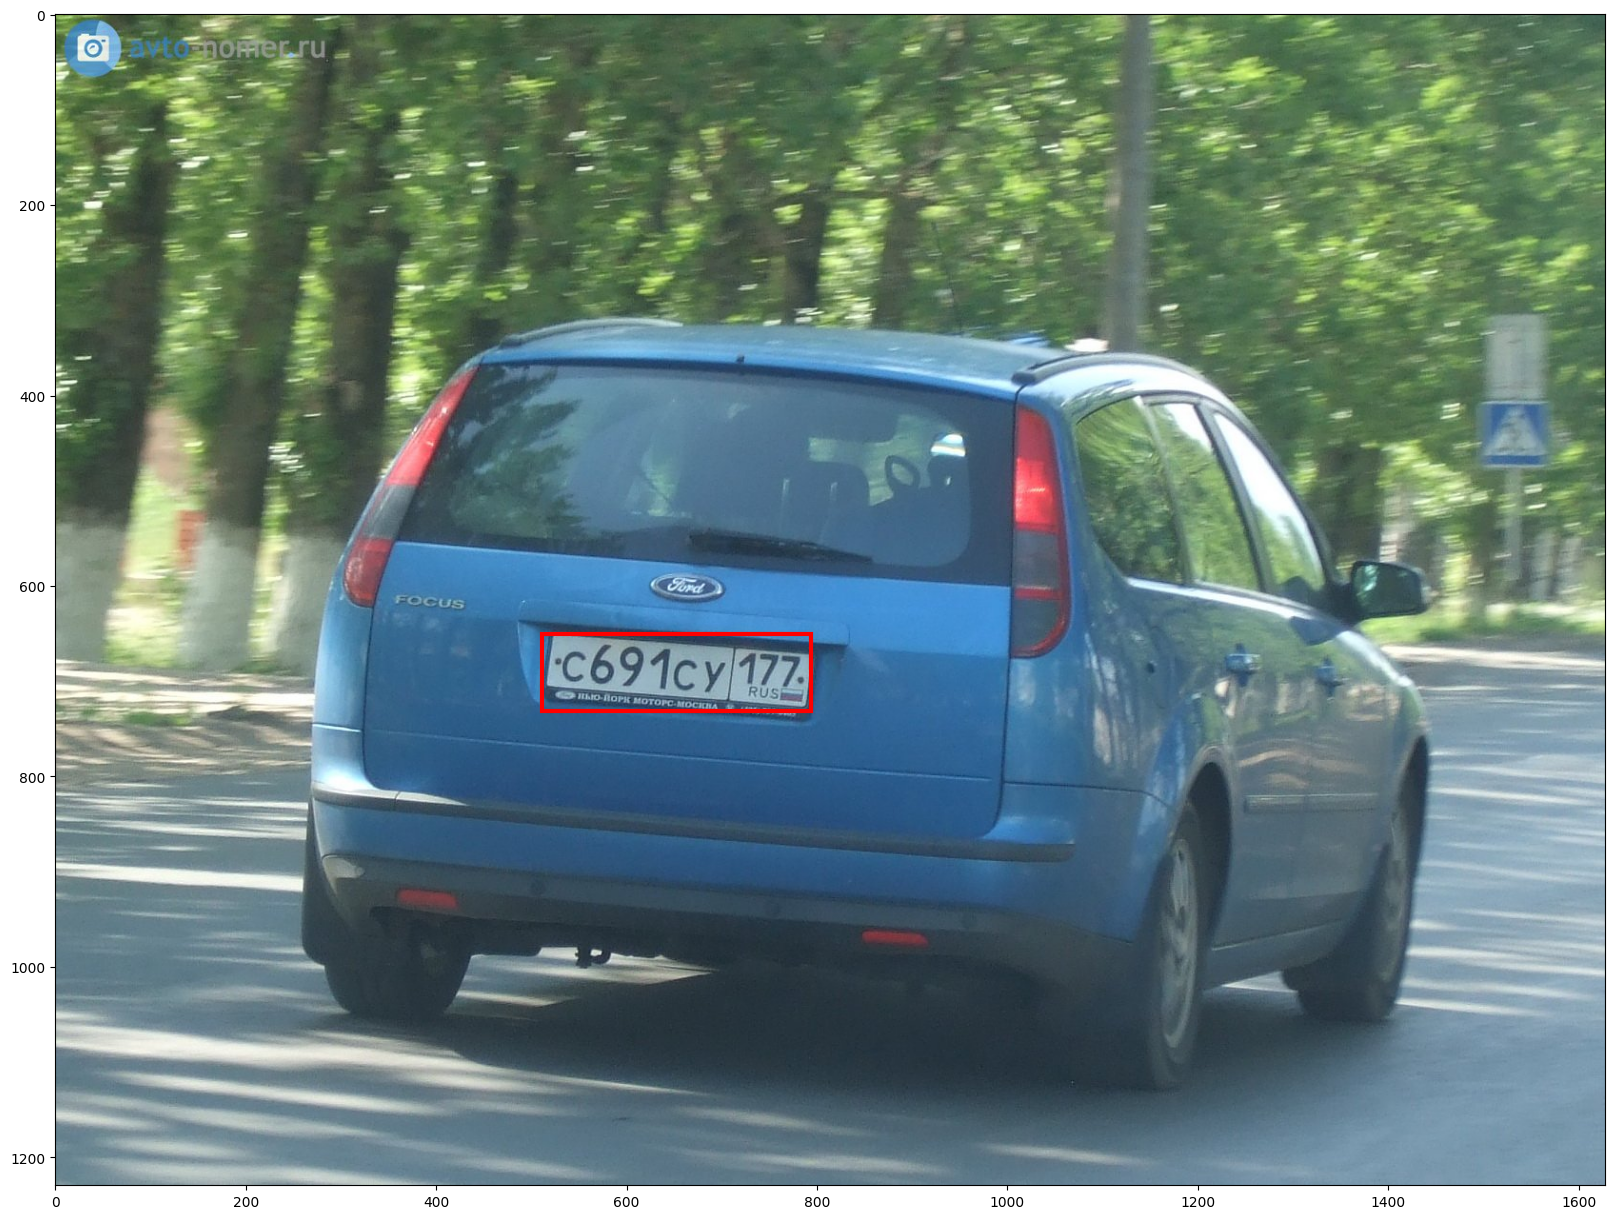

In [130]:
## Для визуализации предсказания по одному изображению используем метод visualize_image: 
## передаем путь до изображения

plates_recognition_inference.visualize_image('../vkcv2022-contest-02-carplates/data/test/25.jpg')

In [120]:
## Для предсказания списка изобрадений используем метод predict_img_list

data_folder = '../vkcv2022-contest-02-carplates/data/'
img_list = [os.path.join(data_folder, object['file']) for object in valset.img_list if len(object['nums'])==1]

results = plates_recognition_inference.predict_img_list(img_list)

100%|███████████████████████████████████████| 4907/4907 [07:50<00:00, 10.42it/s]


In [129]:
## Почитаем метрику Accuracy для валидационной выборки

from sklearn.metrics import accuracy_score

true_texts = [object['nums'][0]['text'] for object in valset.img_list if len(object['nums'])==1]
print(f'Accuracy score: {round(100*accuracy_score(true_texts, results), 2)}%')

Accuracy score: 53.15%
